# Pre-training

As in (Harsuko and Alkhalifah, 2022), pre-training of StorSeismic was intended to make the network learn the "features" of a seismic data. In this notebook, we will use the masked seismic data as the input and train the network to reconstruct the masked traces. The backbone of the network is BERT architecture (Devlin et al., 2018), obtained from HuggingFace's <code>transformers</code> library (https://github.com/huggingface/transformers).

## Load required modules

In [18]:
from transformers import BertConfig, BertForMaskedLM
import transformers
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
from radam import RAdam
import sys
import pandas as pd
import itertools

from storseismic.modules import *
from storseismic.train import run_pretraining
from storseismic.utils import *

pd.set_option('display.max_rows', None)
torch.cuda.empty_cache()

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Initialization

### Pre-training configuration

In [25]:
config = BertConfig()

# Model Parameter
config.hidden_size = 256
config.num_hidden_layers = 4
config.num_attention_heads = 4
config.num_hidden_ffn = 4

config.vocab_size = 271 # Time samples
config.intermediate_size = config.hidden_size*config.num_hidden_ffn
config.max_length = 20 # Offsets
config.max_position_embeddings = config.max_length
config.position_embedding_type = 'sincos'
config.input_type = 'trace'
config.embedding_type = 'none'
config.type_vocab_size = 2
config.output_hidden_states = True
config.output_attentions = True
config.output_scores = True
# Toggle Pre-LN BERT
config.pre_ln = True # True, False

# Training Parameter
config.batch_size = 256
config.lr = 5e-4
config.epoch = 1000
config.patience = 20

# I/O parameter
config.parent_dir = './results/pretrain/'
config.dataset = './data/pretrain/'

print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "batch_size": 256,
  "classifier_dropout": null,
  "dataset": "./data/pretrain/",
  "embedding_type": "none",
  "epoch": 1000,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "lr": 0.0005,
  "max_position_embeddings": 20,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./results/pretrain/",
  "patience": 20,
  "position_embedding_type": "sincos",
  "pre_ln": true,
  "transformers_version": "4.10.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 271
}



### Load data and wrap in Pytorch DataLoader

In [3]:
train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

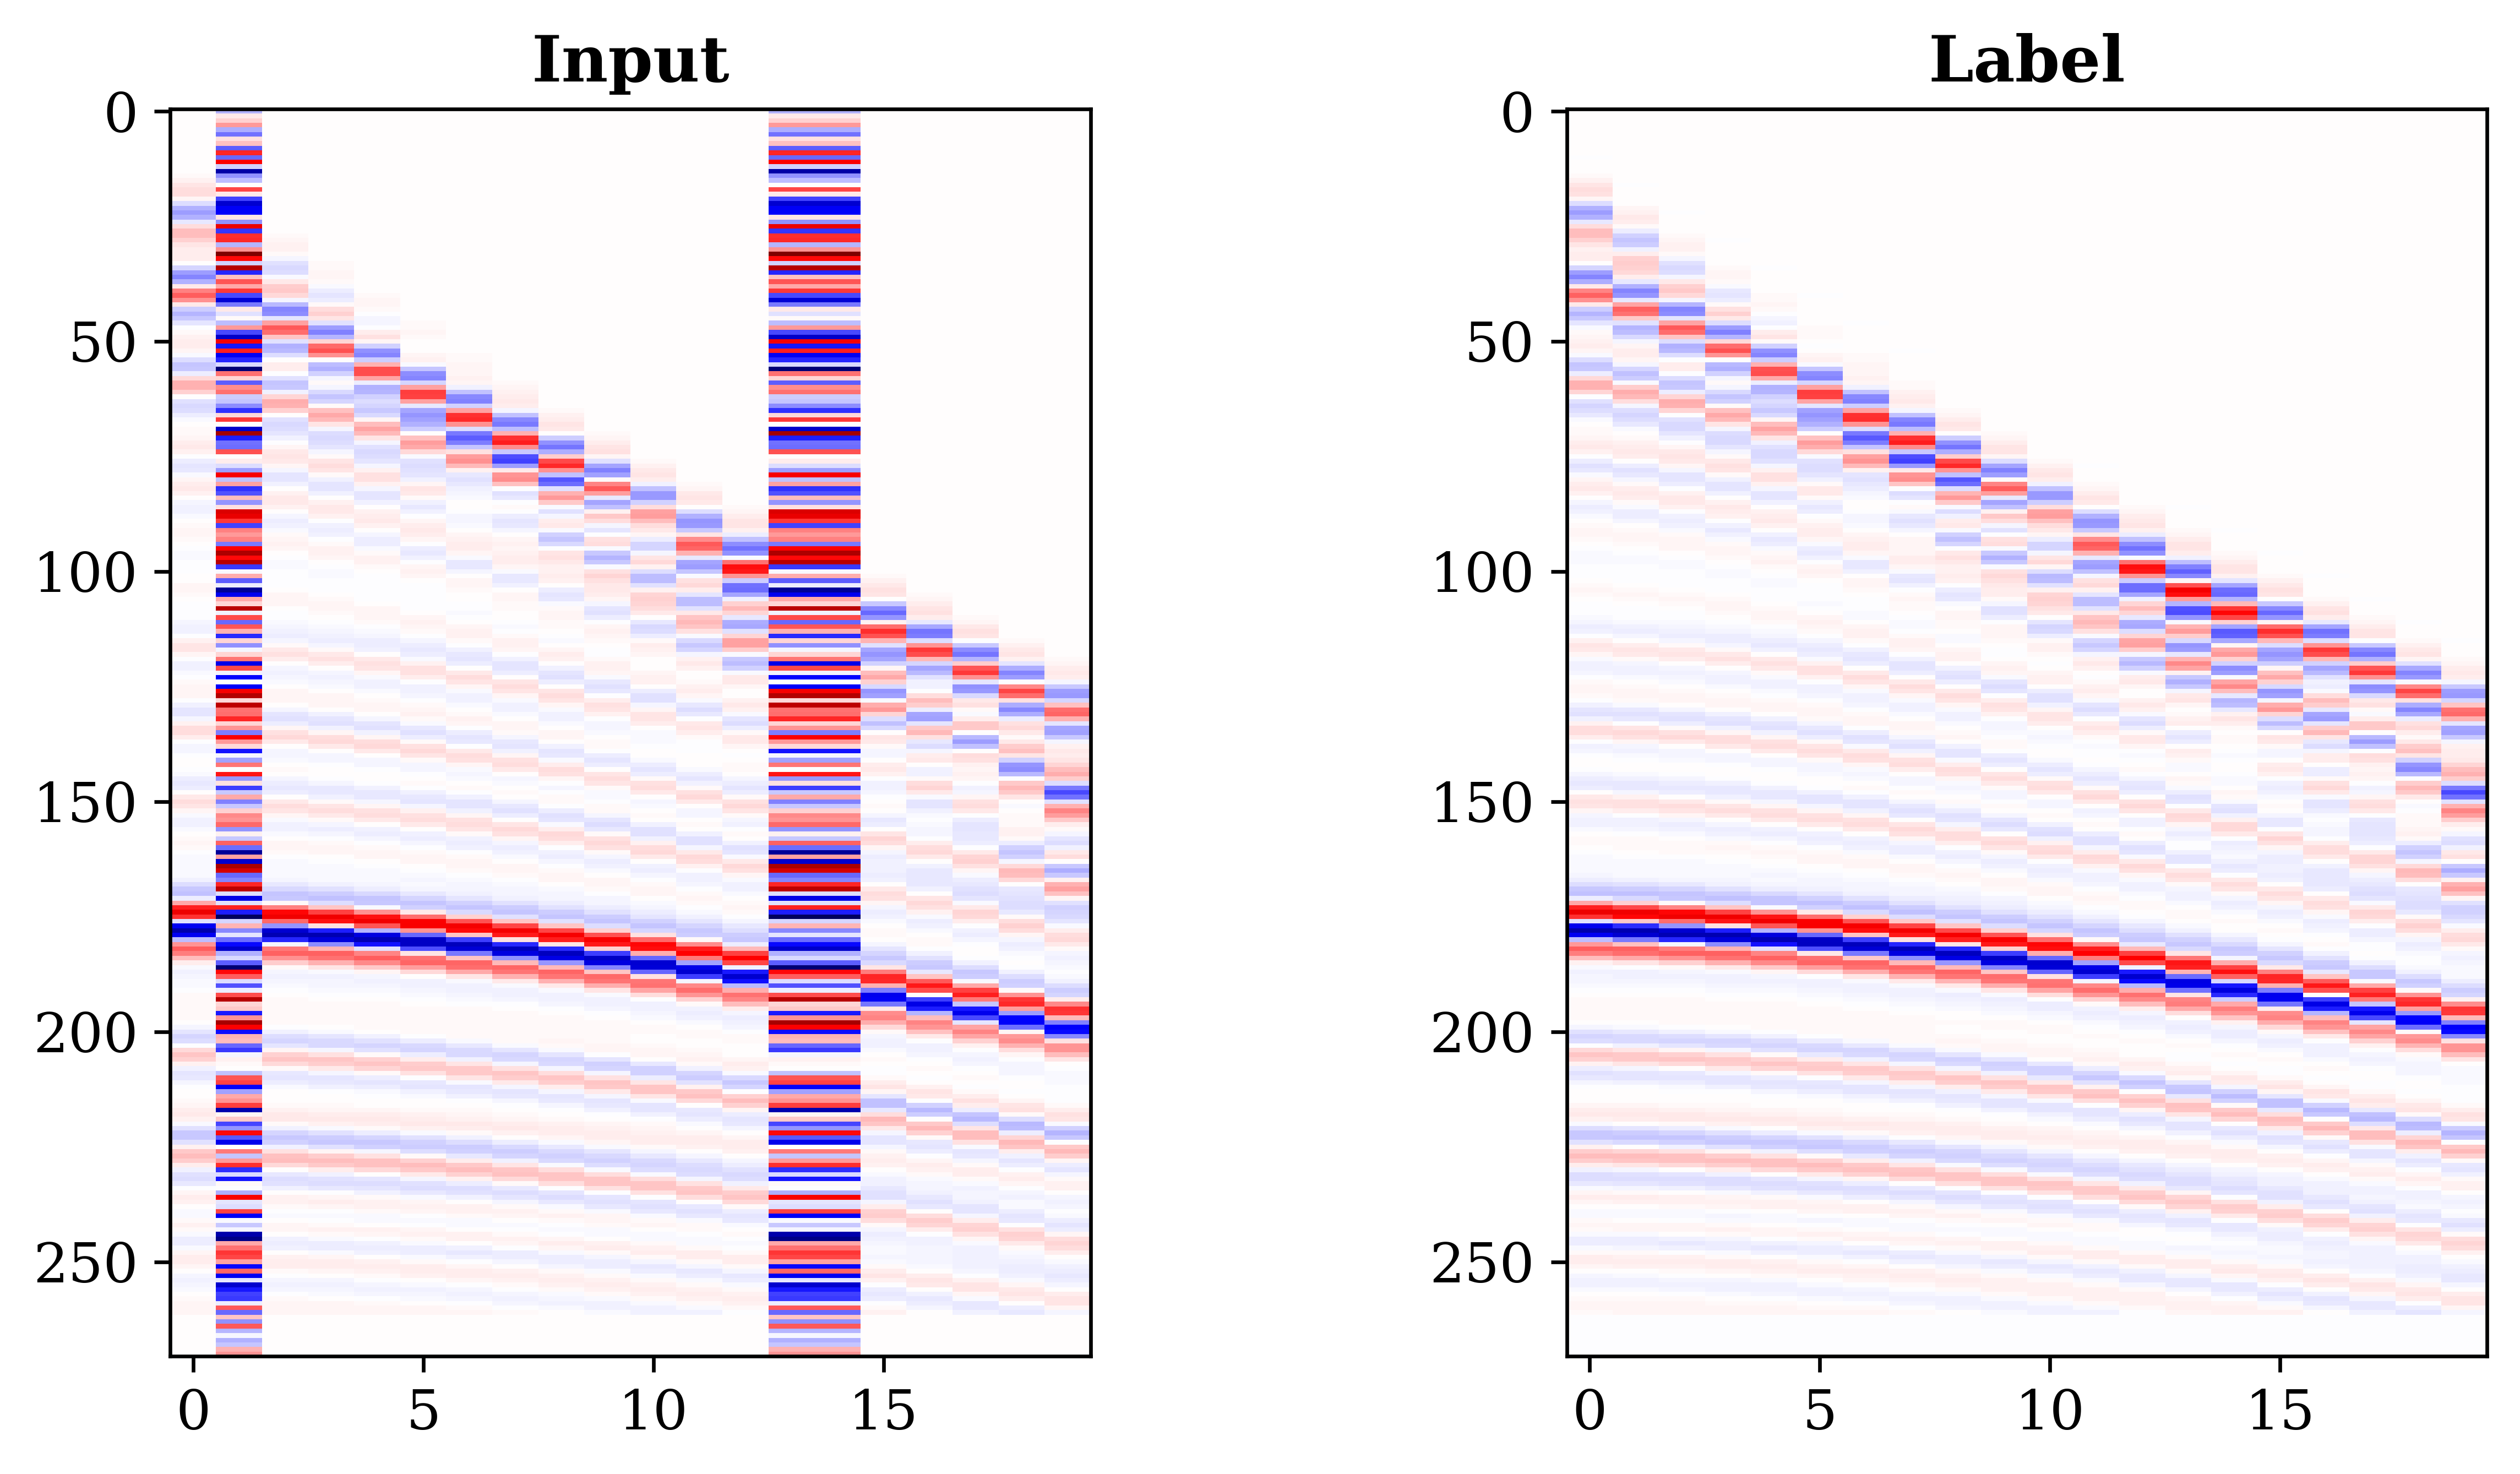

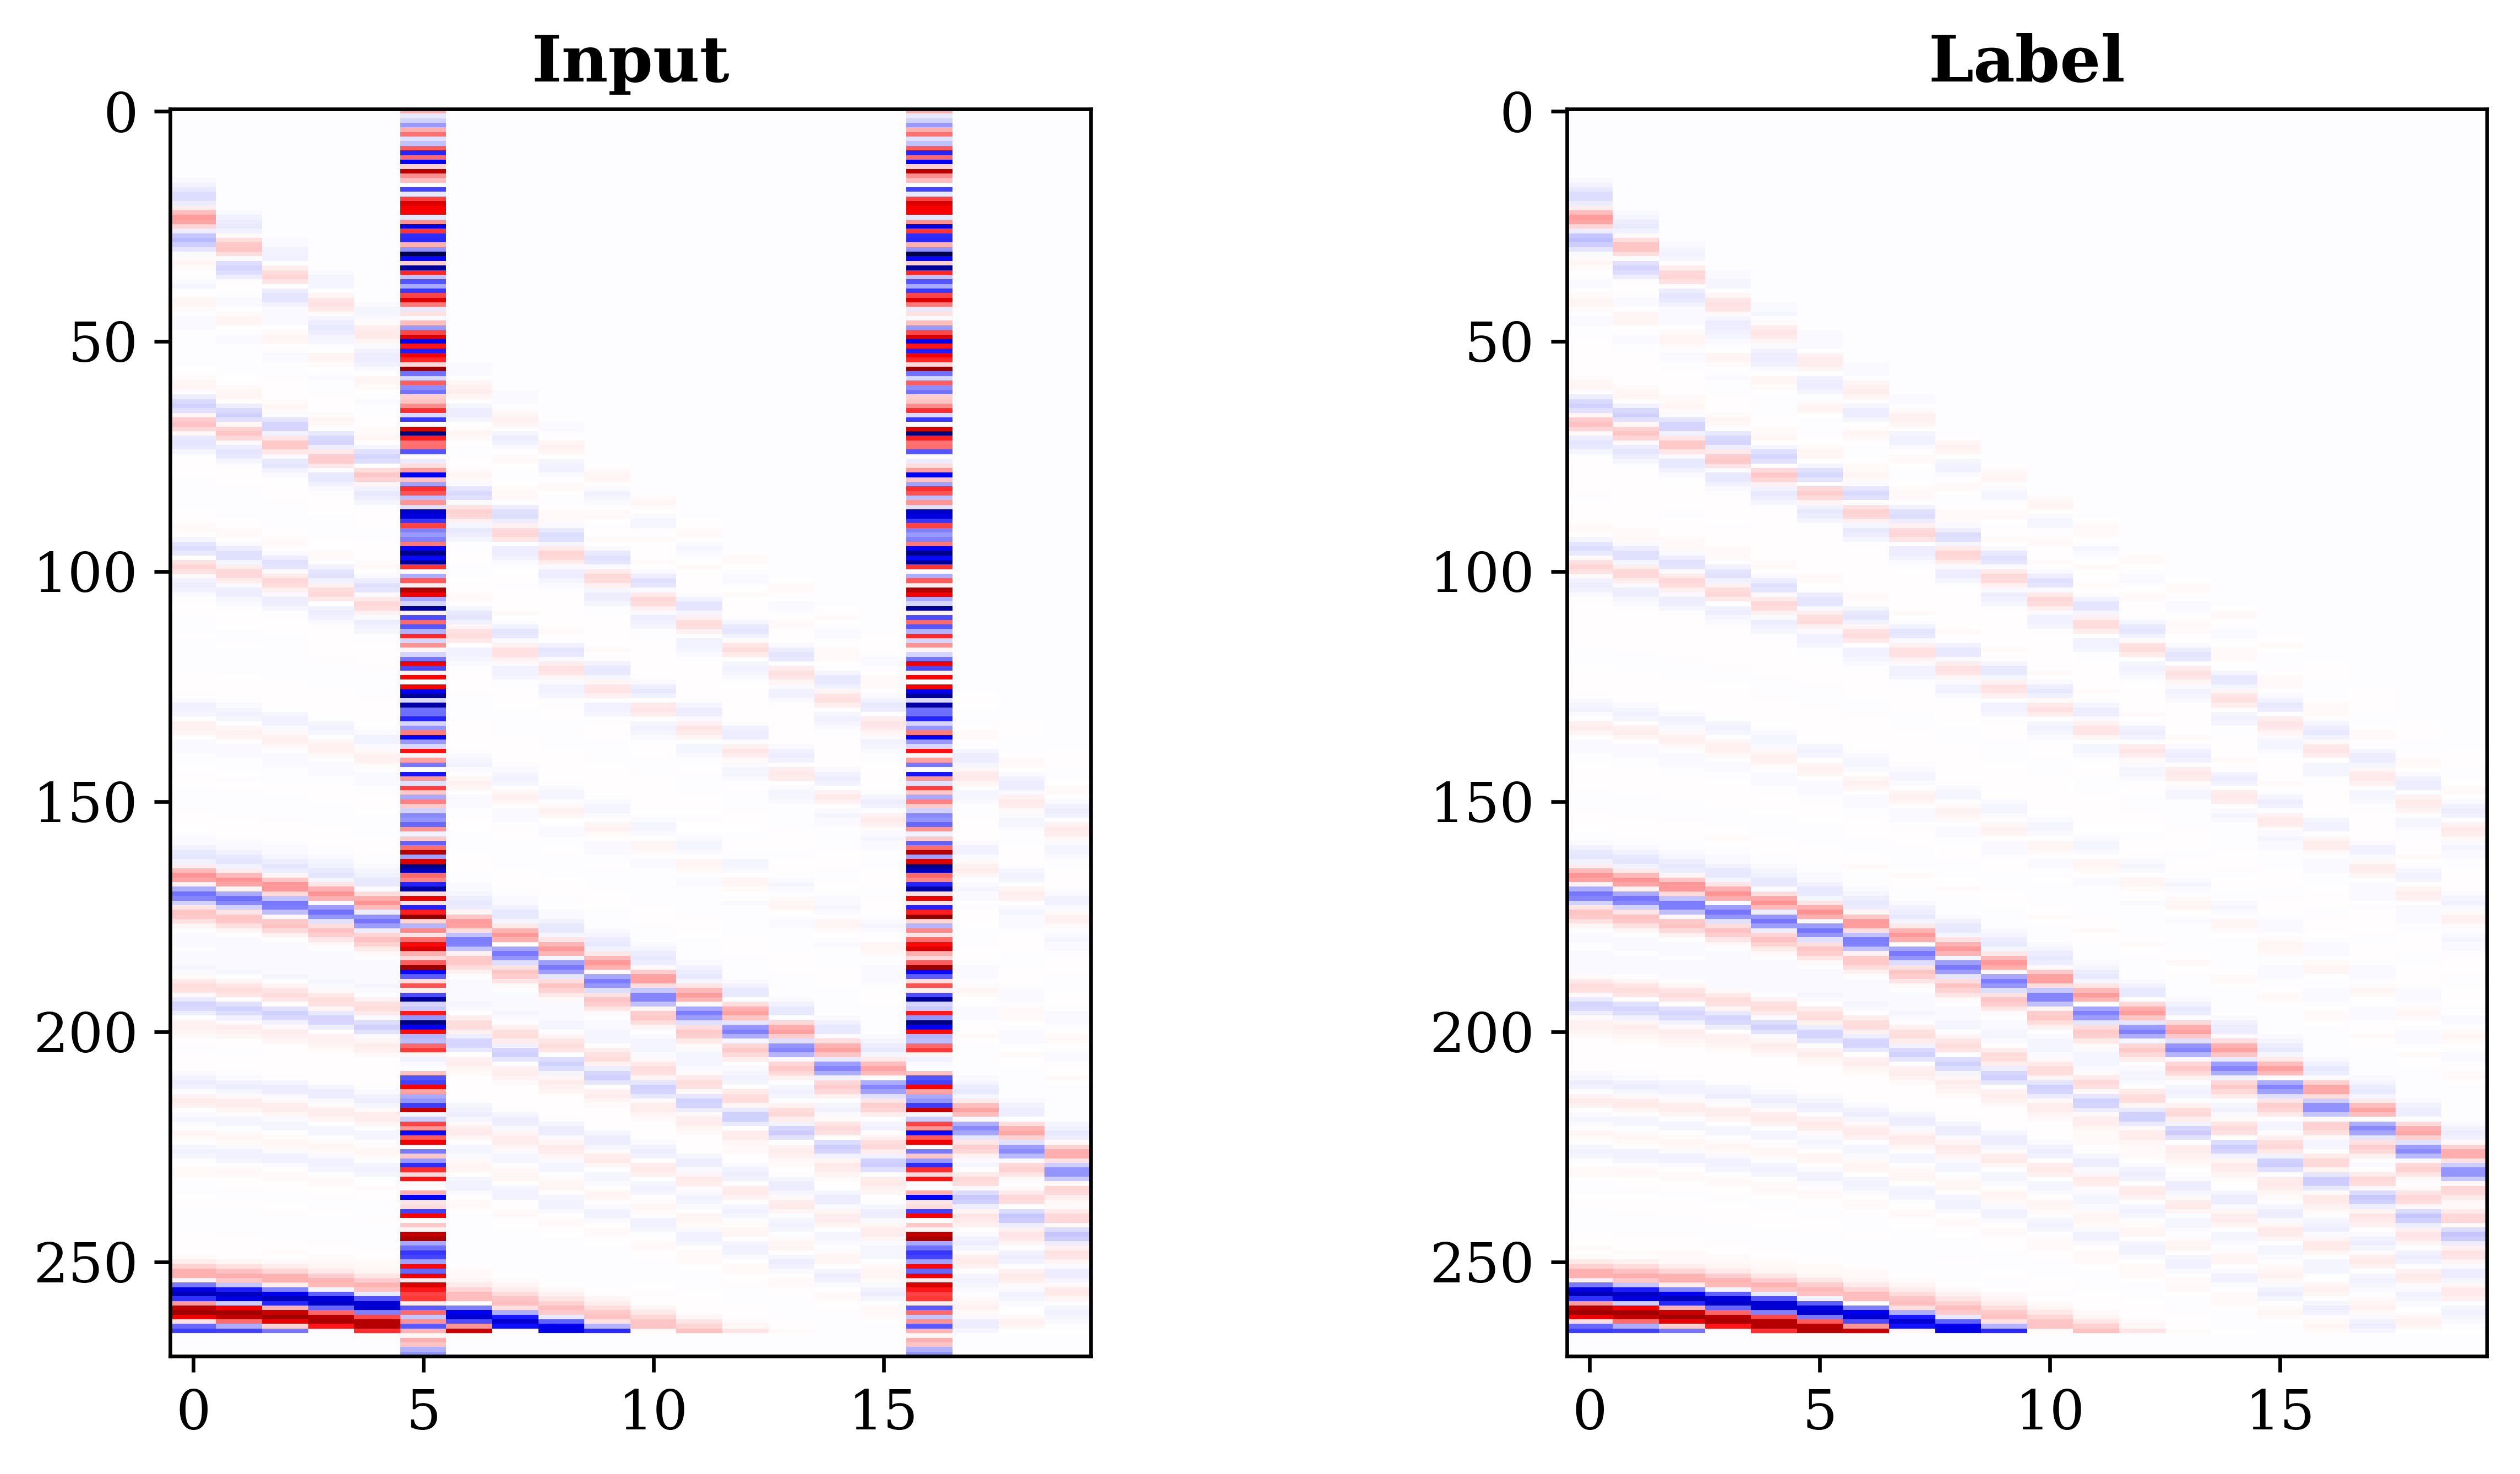

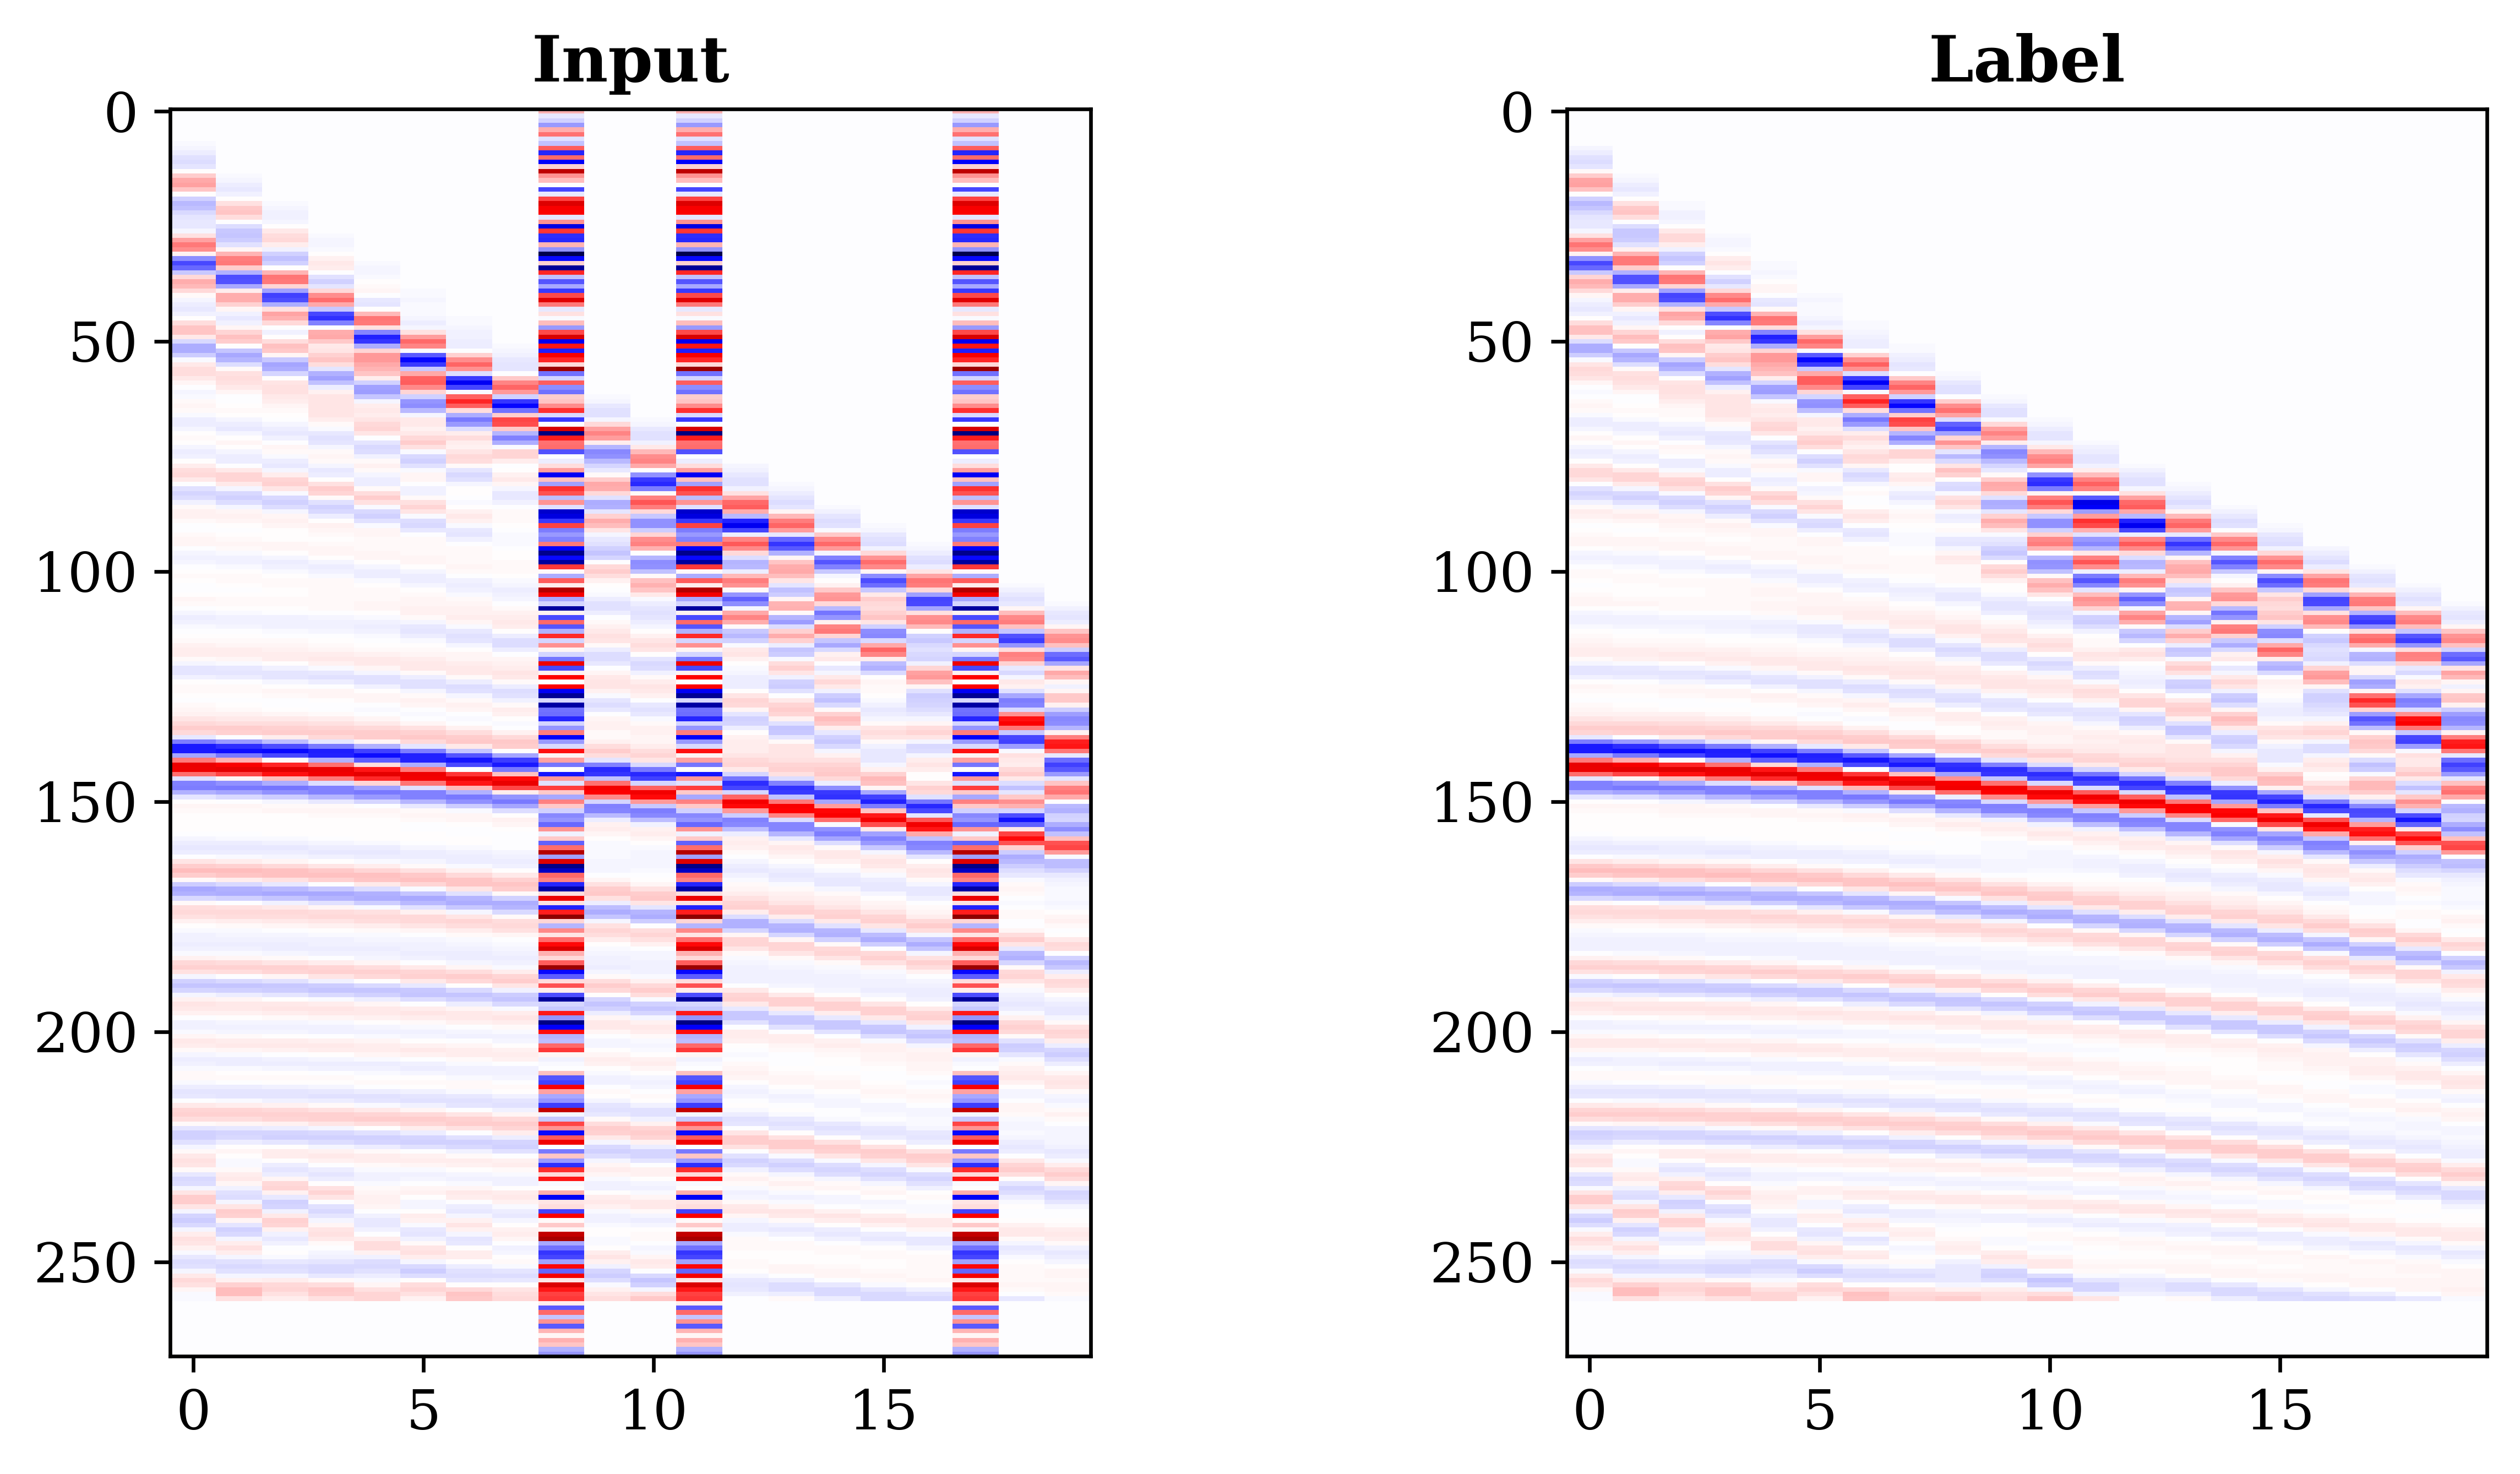

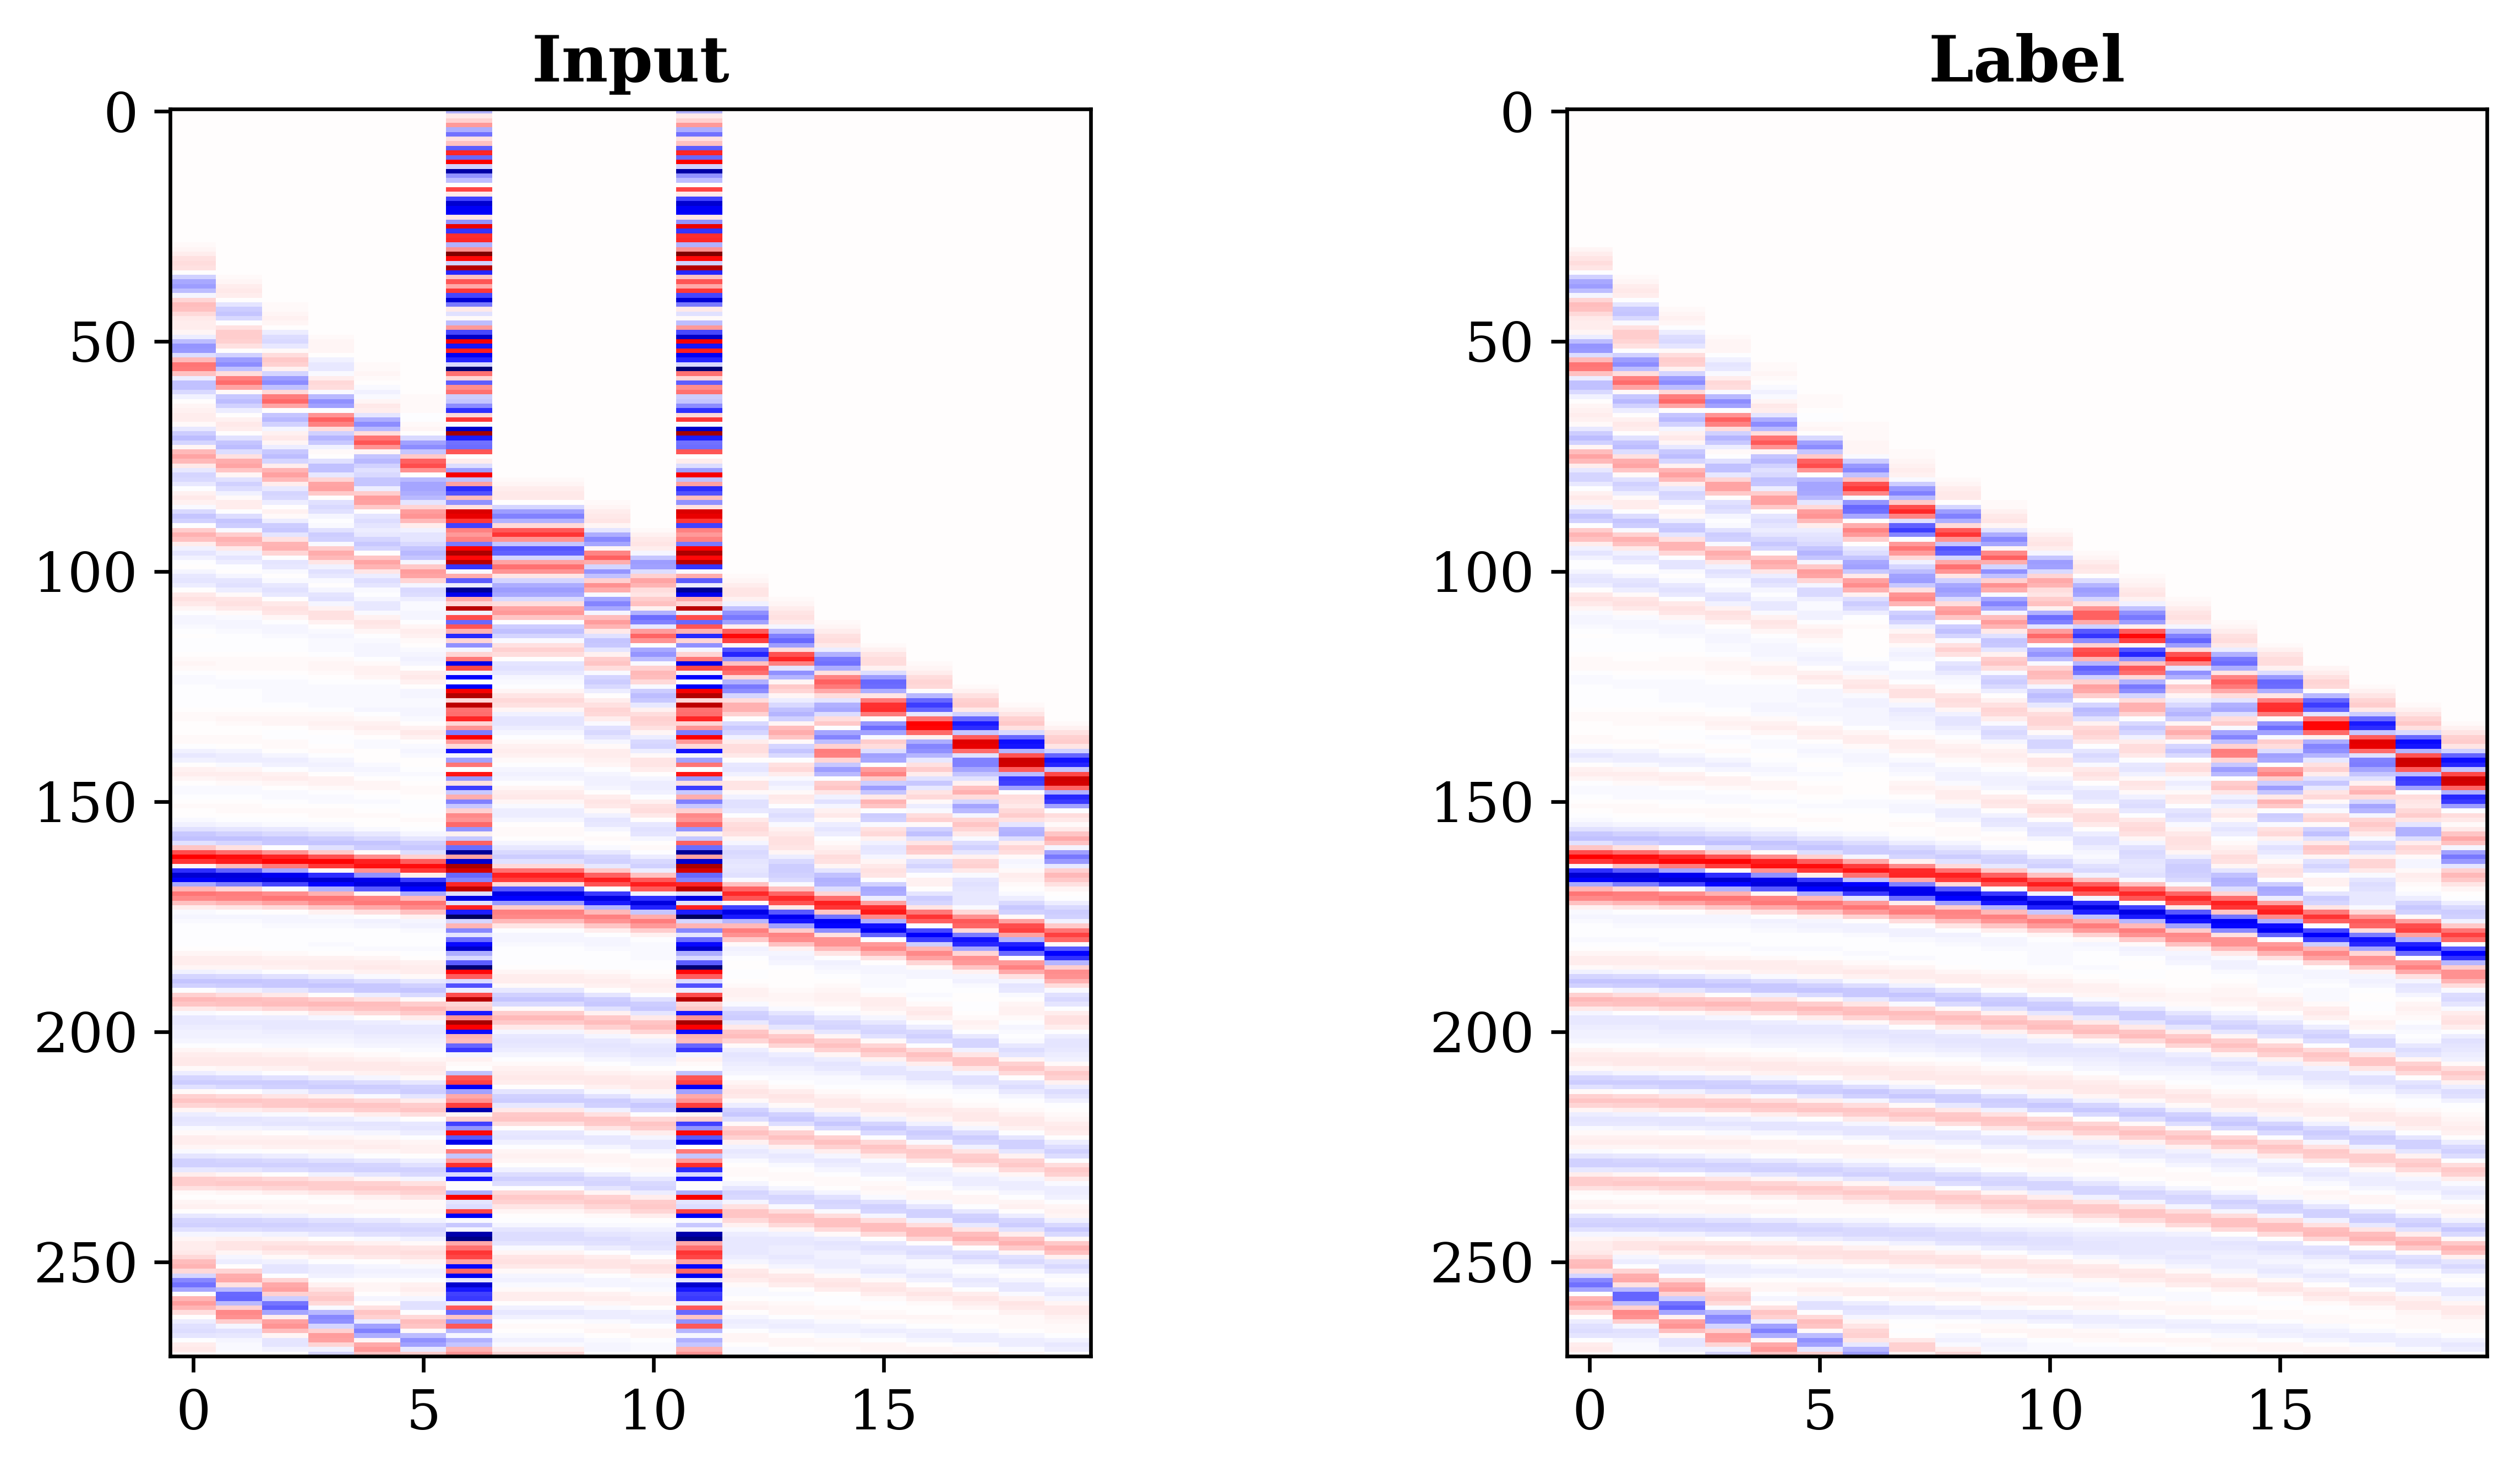

In [26]:
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for i, X in enumerate(train_dataloader):
    if i == 0:
        for j in range(4):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(X['inputs_embeds'][j, :, :].swapaxes(0, 1) - X['inputs_embeds'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[0].set_title("Input")
            ax[1].imshow(X['labels'][j, :, :].swapaxes(0, 1) - X['labels'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[1].set_title("Label")

## Setup StorSeismic pre-training model

In [27]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

### Swap built-in modules with the pre-defined ones

#### Swap the embedding and the prediction head

In [5]:
transformers.models.bert.modeling_bert.BertEmbeddings = BertEmbeddings
transformers.models.bert.modeling_bert.BertOnlyMLMHead = BertOnlyMLMHead

#### Check existing starting model before changing other modules

In [6]:
starting_model_fn = ('_').join([str(config.hidden_size), str(config.num_hidden_layers), "startingmodel.pt"])
if not os.path.exists(os.path.join(config.parent_dir, "starting_model")):
    os.makedirs(os.path.join(config.parent_dir, "starting_model"))
if not os.path.exists(os.path.join(config.parent_dir, "starting_model", starting_model_fn)):
    model = BertForMaskedLM(config)
    torch.save(model, os.path.join(config.parent_dir, "starting_model", starting_model_fn))

#### Swap with Pre-LN or Post-LN

We will use Pre-LN BERT instead of Post-LN BERT, which is more insensitive to hyperparameter tuning (Xiong et al., 2020).

In [7]:
if config.pre_ln:
    transformers.models.bert.modeling_bert.BertSelfOutput = PreLNBertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = PreLNBertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = PreLNBertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = PreLNBertOutput

else:
    transformers.models.bert.modeling_bert.BertSelfOutput = BertSelfOutput
    transformers.models.bert.modeling_bert.BertAttention = BertAttention
    transformers.models.bert.modeling_bert.BertIntermediate = BertIntermediate
    transformers.models.bert.modeling_bert.BertOutput = BertOutput

### Instantiate model

In [8]:
model = BertForMaskedLM(config)

#### Load weights from starting model (to preserve starting point on every run)

In [9]:
model_state_dict = model.state_dict()
if config.pre_ln:
    starting_model = torch.load(os.path.join(config.parent_dir, "starting_model", starting_model_fn))
    layernorm_key_a = [k for k in starting_model.state_dict().keys() if 'LayerNorm' in k]
    layernorm_key_b = [k for k in model.state_dict().keys() if 'LayerNorm' in k]
    for key in starting_model.state_dict().keys():
        if 'LayerNorm' not in key:
            model_state_dict[key] = starting_model.state_dict()[key]

    for key_a, key_b in zip(layernorm_key_a, layernorm_key_b):
        model_state_dict[key_b] = starting_model.state_dict()[key_a]

    model.load_state_dict(model_state_dict)
else:
    starting_model = torch.load(os.path.join(config.parent_dir, "starting_model", starting_model_fn))
    model.load_state_dict(starting_model.state_dict())

#### Check number of trainable parameters

In [10]:
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_feature

In [11]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

,Name,Parameter
0,bert.embeddings.word_embeddings.weight,69376
1,bert.embeddings.word_embeddings.bias,256
2,bert.embeddings.LayerNorm.weight,256
3,bert.embeddings.LayerNorm.bias,256
4,bert.encoder.layer.0.attention.LayerNorm.weight,256
5,bert.encoder.layer.0.attention.LayerNorm.bias,256
6,bert.encoder.layer.0.attention.self.query.weight,65536
7,bert.encoder.layer.0.attention.self.query.bias,256
8,bert.encoder.layer.0.attention.self.key.weight,65536
9,bert.encoder.layer.0.attention.self.key.bias,256


Total Trainable Params: 3298831


3298831

#### Send model to device

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


## Training

### Set up training hyperparameters

In [13]:
# Optimizer
optim = RAdam(model.parameters(), lr=config.lr)

# Loss
loss_fn = nn.MSELoss(reduction='mean')

# Number of epochs
epochs = config.epoch

### Train

<IPython.core.display.Javascript object>


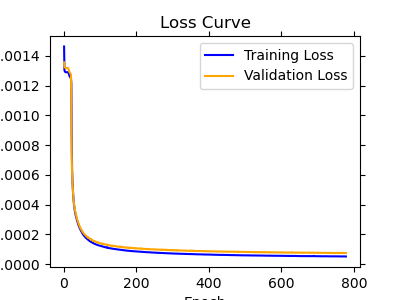

In [14]:
%matplotlib notebook

plt.ion()
f, ax = plt.subplots(figsize=(4, 3))

In [15]:
model, avg_train_loss, avg_valid_loss, time_per_epoch = \
run_pretraining(model, optim, loss_fn, train_dataloader, test_dataloader, epochs, device, 
                tmp_dir=config.parent_dir, patience=config.patience, plot=True, f=f, ax=ax)

%matplotlib inline
plt.ioff()

  0%|                                                   | 0/141 [00:00<?, ?it/s]/home/randycm/anaconda3/envs/transformers-2/lib/python3.8/site-packages/radam/radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Validation 0: 100%|███████████████| 36/36 [00:01<00:00, 26.15it/s, loss=0.00145]


Epoch time: 8.64 s
Total time elapsed: 8.64 s
---------------------------------------
Validation loss decreased (inf --> 0.001357).  Saving model ...


Validation 1: 100%|███████████████| 36/36 [00:00<00:00, 37.51it/s, loss=0.00138]


Epoch time: 7.26 s
Total time elapsed: 15.98 s
---------------------------------------
Validation loss decreased (0.001357 --> 0.001328).  Saving model ...


Validation 2: 100%|███████████████| 36/36 [00:00<00:00, 41.15it/s, loss=0.00129]


Epoch time: 6.76 s
Total time elapsed: 22.83 s
---------------------------------------
Validation loss decreased (0.001328 --> 0.001323).  Saving model ...


Validation 3: 100%|███████████████| 36/36 [00:00<00:00, 37.96it/s, loss=0.00138]


Epoch time: 6.85 s
Total time elapsed: 29.82 s
---------------------------------------
Validation loss decreased (0.001323 --> 0.001320).  Saving model ...


Validation 4: 100%|███████████████| 36/36 [00:00<00:00, 37.49it/s, loss=0.00138]


Epoch time: 6.82 s
Total time elapsed: 36.73 s
---------------------------------------
Validation loss decreased (0.001320 --> 0.001319).  Saving model ...


Validation 5: 100%|███████████████| 36/36 [00:00<00:00, 37.10it/s, loss=0.00124]


Epoch time: 7.02 s
Total time elapsed: 43.84 s
---------------------------------------
Validation loss decreased (0.001319 --> 0.001316).  Saving model ...


Validation 6: 100%|███████████████| 36/36 [00:01<00:00, 34.63it/s, loss=0.00131]


Epoch time: 7.10 s
Total time elapsed: 51.02 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 7: 100%|███████████████| 36/36 [00:00<00:00, 36.88it/s, loss=0.00129]


Epoch time: 7.04 s
Total time elapsed: 58.12 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 8: 100%|███████████████| 36/36 [00:00<00:00, 36.61it/s, loss=0.00137]


Epoch time: 6.94 s
Total time elapsed: 65.12 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 9: 100%|███████████████| 36/36 [00:00<00:00, 39.18it/s, loss=0.00131]


Epoch time: 7.00 s
Total time elapsed: 72.17 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 10: 100%|██████████████| 36/36 [00:00<00:00, 37.75it/s, loss=0.00133]


Epoch time: 6.82 s
Total time elapsed: 79.05 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 11: 100%|██████████████| 36/36 [00:00<00:00, 36.63it/s, loss=0.00133]


Epoch time: 6.94 s
Total time elapsed: 86.05 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 12: 100%|██████████████| 36/36 [00:00<00:00, 39.96it/s, loss=0.00131]


Epoch time: 6.95 s
Total time elapsed: 93.06 s
---------------------------------------
Validation loss decreased (0.001316 --> 0.001314).  Saving model ...


Validation 13: 100%|██████████████| 36/36 [00:00<00:00, 39.97it/s, loss=0.00136]


Epoch time: 6.70 s
Total time elapsed: 99.84 s
---------------------------------------
Validation loss decreased (0.001314 --> 0.001304).  Saving model ...


Validation 14: 100%|██████████████| 36/36 [00:00<00:00, 38.68it/s, loss=0.00129]


Epoch time: 6.84 s
Total time elapsed: 106.78 s
---------------------------------------
Validation loss decreased (0.001304 --> 0.001295).  Saving model ...


Validation 15: 100%|███████████████| 36/36 [00:00<00:00, 40.64it/s, loss=0.0013]


Epoch time: 6.73 s
Total time elapsed: 113.60 s
---------------------------------------
Validation loss decreased (0.001295 --> 0.001291).  Saving model ...


Validation 16: 100%|██████████████| 36/36 [00:00<00:00, 40.91it/s, loss=0.00125]


Epoch time: 6.77 s
Total time elapsed: 120.44 s
---------------------------------------
Validation loss decreased (0.001291 --> 0.001287).  Saving model ...


Validation 17: 100%|██████████████| 36/36 [00:01<00:00, 34.32it/s, loss=0.00136]


Epoch time: 7.11 s
Total time elapsed: 127.64 s
---------------------------------------
Validation loss decreased (0.001287 --> 0.001285).  Saving model ...


Validation 18: 100%|██████████████| 36/36 [00:00<00:00, 41.56it/s, loss=0.00126]


Epoch time: 6.80 s
Total time elapsed: 134.52 s
---------------------------------------
Validation loss decreased (0.001285 --> 0.001279).  Saving model ...


Validation 19: 100%|██████████████| 36/36 [00:00<00:00, 38.06it/s, loss=0.00122]


Epoch time: 6.63 s
Total time elapsed: 141.23 s
---------------------------------------
Validation loss decreased (0.001279 --> 0.001275).  Saving model ...


Validation 20: 100%|██████████████| 36/36 [00:00<00:00, 41.99it/s, loss=0.00115]


Epoch time: 6.89 s
Total time elapsed: 148.20 s
---------------------------------------
Validation loss decreased (0.001275 --> 0.001093).  Saving model ...


Validation 21: 100%|█████████████| 36/36 [00:00<00:00, 37.18it/s, loss=0.000737]


Epoch time: 6.76 s
Total time elapsed: 155.05 s
---------------------------------------
Validation loss decreased (0.001093 --> 0.000730).  Saving model ...


Validation 22: 100%|█████████████| 36/36 [00:00<00:00, 41.17it/s, loss=0.000682]


Epoch time: 6.81 s
Total time elapsed: 161.94 s
---------------------------------------
Validation loss decreased (0.000730 --> 0.000611).  Saving model ...


Validation 23: 100%|█████████████| 36/36 [00:00<00:00, 36.05it/s, loss=0.000558]


Epoch time: 6.87 s
Total time elapsed: 168.89 s
---------------------------------------
Validation loss decreased (0.000611 --> 0.000546).  Saving model ...


Validation 24: 100%|█████████████| 36/36 [00:00<00:00, 41.94it/s, loss=0.000548]


Epoch time: 6.87 s
Total time elapsed: 175.84 s
---------------------------------------
Validation loss decreased (0.000546 --> 0.000502).  Saving model ...


Validation 25: 100%|█████████████| 36/36 [00:00<00:00, 38.42it/s, loss=0.000455]


Epoch time: 6.63 s
Total time elapsed: 182.56 s
---------------------------------------
Validation loss decreased (0.000502 --> 0.000468).  Saving model ...


Validation 26: 100%|█████████████| 36/36 [00:00<00:00, 41.43it/s, loss=0.000471]


Epoch time: 6.73 s
Total time elapsed: 189.38 s
---------------------------------------
Validation loss decreased (0.000468 --> 0.000437).  Saving model ...


Validation 27: 100%|█████████████| 36/36 [00:00<00:00, 42.89it/s, loss=0.000462]


Epoch time: 6.73 s
Total time elapsed: 196.19 s
---------------------------------------
Validation loss decreased (0.000437 --> 0.000413).  Saving model ...


Validation 28: 100%|█████████████| 36/36 [00:01<00:00, 35.48it/s, loss=0.000393]


Epoch time: 6.70 s
Total time elapsed: 202.97 s
---------------------------------------
Validation loss decreased (0.000413 --> 0.000392).  Saving model ...


Validation 29: 100%|█████████████| 36/36 [00:00<00:00, 39.82it/s, loss=0.000362]


Epoch time: 6.68 s
Total time elapsed: 209.74 s
---------------------------------------
Validation loss decreased (0.000392 --> 0.000375).  Saving model ...


Validation 30: 100%|███████████████| 36/36 [00:00<00:00, 42.04it/s, loss=0.0004]


Epoch time: 6.84 s
Total time elapsed: 216.66 s
---------------------------------------
Validation loss decreased (0.000375 --> 0.000364).  Saving model ...


Validation 31: 100%|█████████████| 36/36 [00:00<00:00, 39.11it/s, loss=0.000455]


Epoch time: 6.66 s
Total time elapsed: 223.40 s
---------------------------------------
Validation loss decreased (0.000364 --> 0.000352).  Saving model ...


Validation 32: 100%|██████████████| 36/36 [00:00<00:00, 39.38it/s, loss=0.00034]


Epoch time: 6.65 s
Total time elapsed: 230.14 s
---------------------------------------
Validation loss decreased (0.000352 --> 0.000339).  Saving model ...


Validation 33: 100%|█████████████| 36/36 [00:00<00:00, 41.00it/s, loss=0.000349]


Epoch time: 6.82 s
Total time elapsed: 237.05 s
---------------------------------------
Validation loss decreased (0.000339 --> 0.000328).  Saving model ...


Validation 34: 100%|█████████████| 36/36 [00:00<00:00, 41.83it/s, loss=0.000306]


Epoch time: 6.66 s
Total time elapsed: 243.80 s
---------------------------------------
Validation loss decreased (0.000328 --> 0.000319).  Saving model ...


Validation 35: 100%|█████████████| 36/36 [00:00<00:00, 39.90it/s, loss=0.000278]


Epoch time: 6.63 s
Total time elapsed: 250.56 s
---------------------------------------
Validation loss decreased (0.000319 --> 0.000310).  Saving model ...


Validation 36: 100%|█████████████| 36/36 [00:00<00:00, 39.54it/s, loss=0.000286]


Epoch time: 6.66 s
Total time elapsed: 257.30 s
---------------------------------------
Validation loss decreased (0.000310 --> 0.000302).  Saving model ...


Validation 37: 100%|█████████████| 36/36 [00:00<00:00, 42.33it/s, loss=0.000337]


Epoch time: 6.80 s
Total time elapsed: 264.19 s
---------------------------------------
Validation loss decreased (0.000302 --> 0.000294).  Saving model ...


Validation 38: 100%|█████████████| 36/36 [00:00<00:00, 41.73it/s, loss=0.000314]


Epoch time: 6.64 s
Total time elapsed: 270.95 s
---------------------------------------
Validation loss decreased (0.000294 --> 0.000286).  Saving model ...


Validation 39: 100%|█████████████| 36/36 [00:01<00:00, 34.87it/s, loss=0.000299]


Epoch time: 7.30 s
Total time elapsed: 278.34 s
---------------------------------------
Validation loss decreased (0.000286 --> 0.000278).  Saving model ...


Validation 40: 100%|█████████████| 36/36 [00:00<00:00, 41.77it/s, loss=0.000223]


Epoch time: 6.88 s
Total time elapsed: 285.30 s
---------------------------------------
Validation loss decreased (0.000278 --> 0.000273).  Saving model ...


Validation 41: 100%|█████████████| 36/36 [00:00<00:00, 36.83it/s, loss=0.000242]


Epoch time: 7.77 s
Total time elapsed: 293.16 s
---------------------------------------
Validation loss decreased (0.000273 --> 0.000265).  Saving model ...


Validation 42: 100%|█████████████| 36/36 [00:00<00:00, 37.43it/s, loss=0.000262]


Epoch time: 7.29 s
Total time elapsed: 300.53 s
---------------------------------------
Validation loss decreased (0.000265 --> 0.000260).  Saving model ...


Validation 43: 100%|█████████████| 36/36 [00:00<00:00, 41.24it/s, loss=0.000253]


Epoch time: 6.89 s
Total time elapsed: 307.50 s
---------------------------------------
Validation loss decreased (0.000260 --> 0.000253).  Saving model ...


Validation 44: 100%|█████████████| 36/36 [00:00<00:00, 37.80it/s, loss=0.000199]


Epoch time: 6.73 s
Total time elapsed: 314.32 s
---------------------------------------
Validation loss decreased (0.000253 --> 0.000248).  Saving model ...


Validation 45: 100%|█████████████| 36/36 [00:00<00:00, 37.41it/s, loss=0.000245]


Epoch time: 7.05 s
Total time elapsed: 321.45 s
---------------------------------------
Validation loss decreased (0.000248 --> 0.000243).  Saving model ...


Validation 46: 100%|█████████████| 36/36 [00:00<00:00, 40.24it/s, loss=0.000184]


Epoch time: 6.86 s
Total time elapsed: 328.42 s
---------------------------------------
Validation loss decreased (0.000243 --> 0.000236).  Saving model ...


Validation 47: 100%|█████████████| 36/36 [00:00<00:00, 37.49it/s, loss=0.000261]


Epoch time: 7.52 s
Total time elapsed: 336.02 s
---------------------------------------
Validation loss decreased (0.000236 --> 0.000234).  Saving model ...


Validation 48: 100%|█████████████| 36/36 [00:00<00:00, 36.89it/s, loss=0.000251]


Epoch time: 7.50 s
Total time elapsed: 343.61 s
---------------------------------------
Validation loss decreased (0.000234 --> 0.000229).  Saving model ...


Validation 49: 100%|██████████████| 36/36 [00:00<00:00, 40.21it/s, loss=0.00023]


Epoch time: 6.90 s
Total time elapsed: 350.60 s
---------------------------------------
Validation loss decreased (0.000229 --> 0.000226).  Saving model ...


Validation 50: 100%|█████████████| 36/36 [00:01<00:00, 35.90it/s, loss=0.000198]


Epoch time: 6.71 s
Total time elapsed: 357.39 s
---------------------------------------
Validation loss decreased (0.000226 --> 0.000220).  Saving model ...


Validation 51: 100%|█████████████| 36/36 [00:00<00:00, 38.15it/s, loss=0.000203]


Epoch time: 6.99 s
Total time elapsed: 364.47 s
---------------------------------------
Validation loss decreased (0.000220 --> 0.000216).  Saving model ...


Validation 52: 100%|█████████████| 36/36 [00:00<00:00, 40.86it/s, loss=0.000258]


Epoch time: 6.62 s
Total time elapsed: 371.17 s
---------------------------------------
Validation loss decreased (0.000216 --> 0.000216).  Saving model ...


Validation 53: 100%|█████████████| 36/36 [00:00<00:00, 42.00it/s, loss=0.000186]


Epoch time: 7.27 s
Total time elapsed: 378.53 s
---------------------------------------
Validation loss decreased (0.000216 --> 0.000210).  Saving model ...


Validation 54: 100%|█████████████| 36/36 [00:00<00:00, 38.16it/s, loss=0.000195]


Epoch time: 6.65 s
Total time elapsed: 385.36 s
---------------------------------------
Validation loss decreased (0.000210 --> 0.000207).  Saving model ...


Validation 55: 100%|█████████████| 36/36 [00:00<00:00, 37.87it/s, loss=0.000167]


Epoch time: 7.19 s
Total time elapsed: 392.68 s
---------------------------------------
Validation loss decreased (0.000207 --> 0.000203).  Saving model ...


Validation 56: 100%|█████████████| 36/36 [00:00<00:00, 37.32it/s, loss=0.000175]


Epoch time: 7.07 s
Total time elapsed: 399.83 s
---------------------------------------
Validation loss decreased (0.000203 --> 0.000200).  Saving model ...


Validation 57: 100%|█████████████| 36/36 [00:00<00:00, 39.96it/s, loss=0.000205]


Epoch time: 7.05 s
Total time elapsed: 407.02 s
---------------------------------------
Validation loss decreased (0.000200 --> 0.000199).  Saving model ...


Validation 58: 100%|█████████████| 36/36 [00:00<00:00, 37.65it/s, loss=0.000222]


Epoch time: 6.75 s
Total time elapsed: 413.86 s
---------------------------------------
Validation loss decreased (0.000199 --> 0.000196).  Saving model ...


Validation 59: 100%|█████████████| 36/36 [00:00<00:00, 42.01it/s, loss=0.000206]


Epoch time: 6.91 s
Total time elapsed: 420.94 s
---------------------------------------
Validation loss decreased (0.000196 --> 0.000194).  Saving model ...


Validation 60: 100%|█████████████| 36/36 [00:00<00:00, 42.05it/s, loss=0.000189]


Epoch time: 6.57 s
Total time elapsed: 427.59 s
---------------------------------------
Validation loss decreased (0.000194 --> 0.000191).  Saving model ...


Validation 61: 100%|█████████████| 36/36 [00:01<00:00, 34.57it/s, loss=0.000187]


Epoch time: 6.86 s
Total time elapsed: 434.53 s
---------------------------------------
Validation loss decreased (0.000191 --> 0.000190).  Saving model ...


Validation 62: 100%|██████████████| 36/36 [00:00<00:00, 37.13it/s, loss=0.00019]


Epoch time: 7.20 s
Total time elapsed: 441.82 s
---------------------------------------
Validation loss decreased (0.000190 --> 0.000186).  Saving model ...


Validation 63: 100%|█████████████| 36/36 [00:00<00:00, 37.12it/s, loss=0.000172]


Epoch time: 7.07 s
Total time elapsed: 448.98 s
---------------------------------------
Validation loss decreased (0.000186 --> 0.000185).  Saving model ...


Validation 64: 100%|█████████████| 36/36 [00:00<00:00, 40.34it/s, loss=0.000177]


Epoch time: 7.39 s
Total time elapsed: 456.53 s
---------------------------------------
Validation loss decreased (0.000185 --> 0.000183).  Saving model ...


Validation 65: 100%|██████████████| 36/36 [00:00<00:00, 38.73it/s, loss=0.00016]


Epoch time: 6.91 s
Total time elapsed: 463.52 s
---------------------------------------
Validation loss decreased (0.000183 --> 0.000180).  Saving model ...


Validation 66: 100%|█████████████| 36/36 [00:00<00:00, 39.15it/s, loss=0.000201]


Epoch time: 6.82 s
Total time elapsed: 470.42 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 67: 100%|█████████████| 36/36 [00:00<00:00, 39.05it/s, loss=0.000223]


Epoch time: 7.01 s
Total time elapsed: 477.49 s
---------------------------------------
Validation loss decreased (0.000180 --> 0.000177).  Saving model ...


Validation 68: 100%|█████████████| 36/36 [00:00<00:00, 41.79it/s, loss=0.000187]


Epoch time: 7.11 s
Total time elapsed: 484.68 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 69: 100%|█████████████| 36/36 [00:01<00:00, 35.37it/s, loss=0.000197]


Epoch time: 6.80 s
Total time elapsed: 491.55 s
---------------------------------------
Validation loss decreased (0.000177 --> 0.000175).  Saving model ...


Validation 70: 100%|█████████████| 36/36 [00:00<00:00, 41.68it/s, loss=0.000179]


Epoch time: 6.83 s
Total time elapsed: 498.45 s
---------------------------------------
Validation loss decreased (0.000175 --> 0.000172).  Saving model ...


Validation 71: 100%|█████████████| 36/36 [00:00<00:00, 41.83it/s, loss=0.000197]


Epoch time: 6.88 s
Total time elapsed: 505.43 s
---------------------------------------
Validation loss decreased (0.000172 --> 0.000171).  Saving model ...


Validation 72: 100%|█████████████| 36/36 [00:00<00:00, 38.00it/s, loss=0.000179]


Epoch time: 6.78 s
Total time elapsed: 512.29 s
---------------------------------------
Validation loss decreased (0.000171 --> 0.000169).  Saving model ...


Validation 73: 100%|█████████████| 36/36 [00:01<00:00, 35.67it/s, loss=0.000164]


Epoch time: 6.97 s
Total time elapsed: 519.34 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 74: 100%|█████████████| 36/36 [00:00<00:00, 39.10it/s, loss=0.000141]


Epoch time: 6.84 s
Total time elapsed: 526.26 s
---------------------------------------
Validation loss decreased (0.000169 --> 0.000165).  Saving model ...


Validation 75: 100%|█████████████| 36/36 [00:00<00:00, 42.16it/s, loss=0.000178]


Epoch time: 6.97 s
Total time elapsed: 533.34 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 76: 100%|█████████████| 36/36 [00:00<00:00, 40.71it/s, loss=0.000152]


Epoch time: 6.75 s
Total time elapsed: 540.15 s
---------------------------------------
Validation loss decreased (0.000165 --> 0.000164).  Saving model ...


Validation 77: 100%|█████████████| 36/36 [00:01<00:00, 33.77it/s, loss=0.000134]


Epoch time: 6.88 s
Total time elapsed: 547.12 s
---------------------------------------
Validation loss decreased (0.000164 --> 0.000161).  Saving model ...


Validation 78: 100%|█████████████| 36/36 [00:00<00:00, 41.11it/s, loss=0.000138]


Epoch time: 6.95 s
Total time elapsed: 554.16 s
---------------------------------------
Validation loss decreased (0.000161 --> 0.000161).  Saving model ...


Validation 79: 100%|█████████████| 36/36 [00:00<00:00, 41.17it/s, loss=0.000187]


Epoch time: 6.83 s
Total time elapsed: 561.08 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 80: 100%|██████████████| 36/36 [00:00<00:00, 42.03it/s, loss=0.00012]


Epoch time: 6.68 s
Total time elapsed: 567.82 s
---------------------------------------
Validation loss decreased (0.000161 --> 0.000157).  Saving model ...


Validation 81: 100%|█████████████| 36/36 [00:00<00:00, 40.86it/s, loss=0.000144]


Epoch time: 6.73 s
Total time elapsed: 574.64 s
---------------------------------------
Validation loss decreased (0.000157 --> 0.000156).  Saving model ...


Validation 82: 100%|█████████████| 36/36 [00:00<00:00, 36.01it/s, loss=0.000158]


Epoch time: 6.82 s
Total time elapsed: 581.55 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 83: 100%|█████████████| 36/36 [00:00<00:00, 36.87it/s, loss=0.000186]


Epoch time: 7.00 s
Total time elapsed: 588.60 s
---------------------------------------
Validation loss decreased (0.000156 --> 0.000155).  Saving model ...


Validation 84: 100%|█████████████| 36/36 [00:00<00:00, 40.03it/s, loss=0.000141]


Epoch time: 7.03 s
Total time elapsed: 595.72 s
---------------------------------------
Validation loss decreased (0.000155 --> 0.000154).  Saving model ...


Validation 85: 100%|█████████████| 36/36 [00:00<00:00, 36.65it/s, loss=0.000161]


Epoch time: 6.85 s
Total time elapsed: 602.66 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 86: 100%|██████████████| 36/36 [00:00<00:00, 40.13it/s, loss=0.00019]


Epoch time: 6.88 s
Total time elapsed: 609.61 s
---------------------------------------
Validation loss decreased (0.000154 --> 0.000153).  Saving model ...


Validation 87: 100%|█████████████| 36/36 [00:00<00:00, 39.99it/s, loss=0.000174]


Epoch time: 6.89 s
Total time elapsed: 616.58 s
---------------------------------------
Validation loss decreased (0.000153 --> 0.000152).  Saving model ...


Validation 88: 100%|██████████████| 36/36 [00:00<00:00, 39.21it/s, loss=0.00012]


Epoch time: 6.83 s
Total time elapsed: 623.50 s
---------------------------------------
Validation loss decreased (0.000152 --> 0.000149).  Saving model ...


Validation 89: 100%|█████████████| 36/36 [00:00<00:00, 39.80it/s, loss=0.000155]


Epoch time: 6.91 s
Total time elapsed: 630.50 s
---------------------------------------
Validation loss decreased (0.000149 --> 0.000149).  Saving model ...


Validation 90: 100%|█████████████| 36/36 [00:01<00:00, 34.97it/s, loss=0.000145]


Epoch time: 6.92 s
Total time elapsed: 637.50 s
---------------------------------------
Validation loss decreased (0.000149 --> 0.000148).  Saving model ...


Validation 91: 100%|█████████████| 36/36 [00:00<00:00, 40.43it/s, loss=0.000136]


Epoch time: 6.94 s
Total time elapsed: 644.52 s
---------------------------------------
Validation loss decreased (0.000148 --> 0.000147).  Saving model ...


Validation 92: 100%|██████████████| 36/36 [00:00<00:00, 38.46it/s, loss=0.00016]


Epoch time: 7.19 s
Total time elapsed: 651.79 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 93: 100%|█████████████| 36/36 [00:00<00:00, 39.86it/s, loss=0.000188]


Epoch time: 6.87 s
Total time elapsed: 658.75 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 94: 100%|█████████████| 36/36 [00:00<00:00, 37.26it/s, loss=0.000154]


Epoch time: 6.80 s
Total time elapsed: 665.61 s
---------------------------------------
Validation loss decreased (0.000147 --> 0.000146).  Saving model ...


Validation 95: 100%|█████████████| 36/36 [00:01<00:00, 34.94it/s, loss=0.000143]


Epoch time: 6.95 s
Total time elapsed: 672.64 s
---------------------------------------
Validation loss decreased (0.000146 --> 0.000145).  Saving model ...


Validation 96: 100%|█████████████| 36/36 [00:00<00:00, 40.35it/s, loss=0.000149]


Epoch time: 7.10 s
Total time elapsed: 679.83 s
---------------------------------------
Validation loss decreased (0.000145 --> 0.000143).  Saving model ...


Validation 97: 100%|█████████████| 36/36 [00:00<00:00, 40.07it/s, loss=0.000162]


Epoch time: 7.07 s
Total time elapsed: 686.99 s
---------------------------------------
Validation loss decreased (0.000143 --> 0.000143).  Saving model ...


Validation 98: 100%|█████████████| 36/36 [00:00<00:00, 38.84it/s, loss=0.000143]


Epoch time: 6.94 s
Total time elapsed: 694.02 s
---------------------------------------
Validation loss decreased (0.000143 --> 0.000142).  Saving model ...


Validation 99: 100%|█████████████| 36/36 [00:00<00:00, 37.06it/s, loss=0.000161]


Epoch time: 6.84 s
Total time elapsed: 700.94 s
---------------------------------------
Validation loss decreased (0.000142 --> 0.000141).  Saving model ...


Validation 100: 100%|████████████| 36/36 [00:00<00:00, 40.72it/s, loss=0.000154]


Epoch time: 6.88 s
Total time elapsed: 707.90 s
---------------------------------------
Validation loss decreased (0.000141 --> 0.000141).  Saving model ...


Validation 101: 100%|████████████| 36/36 [00:00<00:00, 40.82it/s, loss=0.000124]


Epoch time: 6.95 s
Total time elapsed: 714.94 s
---------------------------------------
Validation loss decreased (0.000141 --> 0.000140).  Saving model ...


Validation 102: 100%|████████████| 36/36 [00:00<00:00, 40.26it/s, loss=0.000129]


Epoch time: 6.69 s
Total time elapsed: 721.72 s
---------------------------------------
Validation loss decreased (0.000140 --> 0.000139).  Saving model ...


Validation 103: 100%|████████████| 36/36 [00:00<00:00, 39.76it/s, loss=0.000139]


Epoch time: 6.68 s
Total time elapsed: 728.55 s
---------------------------------------
Validation loss decreased (0.000139 --> 0.000138).  Saving model ...


Validation 104: 100%|████████████| 36/36 [00:00<00:00, 37.02it/s, loss=0.000155]


Epoch time: 6.75 s
Total time elapsed: 735.38 s
---------------------------------------
Validation loss decreased (0.000138 --> 0.000137).  Saving model ...


Validation 105: 100%|████████████| 36/36 [00:00<00:00, 38.30it/s, loss=0.000154]


Epoch time: 7.46 s
Total time elapsed: 742.93 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 106: 100%|████████████| 36/36 [00:00<00:00, 36.39it/s, loss=0.000131]


Epoch time: 7.12 s
Total time elapsed: 750.11 s
---------------------------------------
Validation loss decreased (0.000137 --> 0.000137).  Saving model ...


Validation 107: 100%|████████████| 36/36 [00:00<00:00, 41.08it/s, loss=0.000118]


Epoch time: 7.72 s
Total time elapsed: 757.91 s
---------------------------------------
Validation loss decreased (0.000137 --> 0.000136).  Saving model ...


Validation 108: 100%|████████████| 36/36 [00:00<00:00, 41.20it/s, loss=0.000133]


Epoch time: 6.89 s
Total time elapsed: 764.88 s
---------------------------------------
Validation loss decreased (0.000136 --> 0.000136).  Saving model ...


Validation 109: 100%|████████████| 36/36 [00:00<00:00, 41.31it/s, loss=0.000144]


Epoch time: 6.76 s
Total time elapsed: 771.73 s
---------------------------------------
Validation loss decreased (0.000136 --> 0.000135).  Saving model ...


Validation 110: 100%|█████████████| 36/36 [00:00<00:00, 36.41it/s, loss=0.00014]


Epoch time: 7.68 s
Total time elapsed: 779.50 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 111: 100%|████████████| 36/36 [00:01<00:00, 33.68it/s, loss=0.000131]


Epoch time: 9.20 s
Total time elapsed: 788.77 s
---------------------------------------
Validation loss decreased (0.000135 --> 0.000134).  Saving model ...


Validation 112: 100%|████████████| 36/36 [00:01<00:00, 32.63it/s, loss=0.000126]


Epoch time: 8.56 s
Total time elapsed: 797.44 s
---------------------------------------
Validation loss decreased (0.000134 --> 0.000133).  Saving model ...


Validation 113: 100%|████████████| 36/36 [00:01<00:00, 32.54it/s, loss=0.000148]


Epoch time: 8.19 s
Total time elapsed: 805.72 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 114: 100%|████████████| 36/36 [00:01<00:00, 34.66it/s, loss=0.000134]


Epoch time: 8.69 s
Total time elapsed: 814.49 s
---------------------------------------
Validation loss decreased (0.000133 --> 0.000133).  Saving model ...


Validation 115: 100%|█████████████| 36/36 [00:01<00:00, 34.90it/s, loss=0.00013]


Epoch time: 7.80 s
Total time elapsed: 822.38 s
---------------------------------------
Validation loss decreased (0.000133 --> 0.000132).  Saving model ...


Validation 116: 100%|████████████| 36/36 [00:01<00:00, 33.67it/s, loss=0.000105]


Epoch time: 7.29 s
Total time elapsed: 829.77 s
---------------------------------------
Validation loss decreased (0.000132 --> 0.000131).  Saving model ...


Validation 117: 100%|████████████| 36/36 [00:00<00:00, 36.62it/s, loss=0.000161]


Epoch time: 7.31 s
Total time elapsed: 837.20 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 118: 100%|████████████| 36/36 [00:00<00:00, 36.76it/s, loss=0.000164]


Epoch time: 7.28 s
Total time elapsed: 844.54 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 119: 100%|████████████| 36/36 [00:00<00:00, 41.00it/s, loss=0.000115]


Epoch time: 7.19 s
Total time elapsed: 851.80 s
---------------------------------------
Validation loss decreased (0.000131 --> 0.000130).  Saving model ...


Validation 120: 100%|████████████| 36/36 [00:00<00:00, 37.11it/s, loss=0.000123]


Epoch time: 6.90 s
Total time elapsed: 858.79 s
---------------------------------------
Validation loss decreased (0.000130 --> 0.000129).  Saving model ...


Validation 121: 100%|█████████████| 36/36 [00:00<00:00, 40.63it/s, loss=0.00013]


Epoch time: 6.93 s
Total time elapsed: 865.80 s
---------------------------------------
Validation loss decreased (0.000129 --> 0.000129).  Saving model ...


Validation 122: 100%|████████████| 36/36 [00:01<00:00, 35.80it/s, loss=0.000104]


Epoch time: 6.87 s
Total time elapsed: 872.76 s
---------------------------------------
Validation loss decreased (0.000129 --> 0.000128).  Saving model ...


Validation 123: 100%|████████████| 36/36 [00:00<00:00, 41.16it/s, loss=0.000117]


Epoch time: 7.59 s
Total time elapsed: 880.44 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 124: 100%|████████████| 36/36 [00:00<00:00, 40.71it/s, loss=0.000158]


Epoch time: 6.89 s
Total time elapsed: 887.39 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 125: 100%|████████████| 36/36 [00:01<00:00, 35.85it/s, loss=0.000142]


Epoch time: 7.19 s
Total time elapsed: 894.65 s
---------------------------------------
Validation loss decreased (0.000128 --> 0.000127).  Saving model ...


Validation 126: 100%|████████████| 36/36 [00:00<00:00, 40.17it/s, loss=0.000117]


Epoch time: 6.96 s
Total time elapsed: 901.69 s
---------------------------------------
Validation loss decreased (0.000127 --> 0.000126).  Saving model ...


Validation 127: 100%|████████████| 36/36 [00:00<00:00, 38.77it/s, loss=0.000133]


Epoch time: 6.75 s
Total time elapsed: 908.55 s
---------------------------------------
Validation loss decreased (0.000126 --> 0.000126).  Saving model ...


Validation 128: 100%|████████████| 36/36 [00:00<00:00, 38.58it/s, loss=0.000119]


Epoch time: 7.03 s
Total time elapsed: 915.66 s
---------------------------------------
Validation loss decreased (0.000126 --> 0.000126).  Saving model ...


Validation 129: 100%|████████████| 36/36 [00:00<00:00, 36.26it/s, loss=0.000104]


Epoch time: 7.41 s
Total time elapsed: 923.15 s
---------------------------------------
Validation loss decreased (0.000126 --> 0.000124).  Saving model ...


Validation 130: 100%|█████████████| 36/36 [00:00<00:00, 39.87it/s, loss=9.76e-5]


Epoch time: 7.68 s
Total time elapsed: 930.92 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 131: 100%|████████████| 36/36 [00:00<00:00, 41.27it/s, loss=0.000103]


Epoch time: 6.90 s
Total time elapsed: 937.88 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 132: 100%|████████████| 36/36 [00:00<00:00, 41.94it/s, loss=0.000118]


Epoch time: 6.58 s
Total time elapsed: 944.53 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 133: 100%|████████████| 36/36 [00:00<00:00, 36.44it/s, loss=0.000122]


Epoch time: 6.91 s
Total time elapsed: 951.50 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 134: 100%|████████████| 36/36 [00:00<00:00, 41.04it/s, loss=0.000126]


Epoch time: 6.98 s
Total time elapsed: 958.54 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 135: 100%|████████████| 36/36 [00:00<00:00, 40.37it/s, loss=0.000106]


Epoch time: 6.73 s
Total time elapsed: 965.33 s
---------------------------------------
Validation loss decreased (0.000124 --> 0.000122).  Saving model ...


Validation 136: 100%|████████████| 36/36 [00:00<00:00, 37.12it/s, loss=0.000115]


Epoch time: 6.80 s
Total time elapsed: 972.22 s
---------------------------------------
Validation loss decreased (0.000122 --> 0.000122).  Saving model ...


Validation 137: 100%|████████████| 36/36 [00:00<00:00, 40.85it/s, loss=0.000139]


Epoch time: 7.82 s
Total time elapsed: 980.13 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 138: 100%|████████████| 36/36 [00:00<00:00, 37.79it/s, loss=0.000111]


Epoch time: 7.25 s
Total time elapsed: 987.43 s
---------------------------------------
Validation loss decreased (0.000122 --> 0.000122).  Saving model ...


Validation 139: 100%|████████████| 36/36 [00:00<00:00, 40.67it/s, loss=0.000123]


Epoch time: 6.92 s
Total time elapsed: 994.44 s
---------------------------------------
Validation loss decreased (0.000122 --> 0.000122).  Saving model ...


Validation 140: 100%|█████████████| 36/36 [00:00<00:00, 36.31it/s, loss=9.99e-5]


Epoch time: 7.40 s
Total time elapsed: 1002.04 s
---------------------------------------
Validation loss decreased (0.000122 --> 0.000121).  Saving model ...


Validation 141: 100%|█████████████| 36/36 [00:00<00:00, 36.70it/s, loss=9.97e-5]


Epoch time: 7.27 s
Total time elapsed: 1009.39 s
---------------------------------------
Validation loss decreased (0.000121 --> 0.000120).  Saving model ...


Validation 142: 100%|████████████| 36/36 [00:00<00:00, 41.16it/s, loss=0.000104]


Epoch time: 7.01 s
Total time elapsed: 1016.49 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 143: 100%|████████████| 36/36 [00:00<00:00, 36.72it/s, loss=0.000145]


Epoch time: 6.87 s
Total time elapsed: 1023.42 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 144: 100%|█████████████| 36/36 [00:00<00:00, 40.67it/s, loss=0.00013]


Epoch time: 7.03 s
Total time elapsed: 1030.51 s
---------------------------------------
Validation loss decreased (0.000120 --> 0.000119).  Saving model ...


Validation 145: 100%|████████████| 36/36 [00:00<00:00, 40.12it/s, loss=0.000113]


Epoch time: 6.79 s
Total time elapsed: 1037.39 s
---------------------------------------
Validation loss decreased (0.000119 --> 0.000119).  Saving model ...


Validation 146: 100%|████████████| 36/36 [00:00<00:00, 36.75it/s, loss=0.000105]


Epoch time: 7.33 s
Total time elapsed: 1044.81 s
---------------------------------------
Validation loss decreased (0.000119 --> 0.000119).  Saving model ...


Validation 147: 100%|████████████| 36/36 [00:01<00:00, 33.25it/s, loss=0.000113]


Epoch time: 8.08 s
Total time elapsed: 1053.05 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 148: 100%|████████████| 36/36 [00:01<00:00, 34.77it/s, loss=0.000107]


Epoch time: 7.38 s
Total time elapsed: 1060.49 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 149: 100%|████████████| 36/36 [00:01<00:00, 33.15it/s, loss=0.000112]


Epoch time: 7.46 s
Total time elapsed: 1068.02 s
---------------------------------------
Validation loss decreased (0.000119 --> 0.000118).  Saving model ...


Validation 150: 100%|████████████| 36/36 [00:01<00:00, 35.99it/s, loss=0.000116]


Epoch time: 7.12 s
Total time elapsed: 1075.23 s
---------------------------------------
Validation loss decreased (0.000118 --> 0.000117).  Saving model ...


Validation 151: 100%|█████████████| 36/36 [00:00<00:00, 36.28it/s, loss=9.03e-5]


Epoch time: 7.76 s
Total time elapsed: 1083.08 s
---------------------------------------
Validation loss decreased (0.000117 --> 0.000117).  Saving model ...


Validation 152: 100%|████████████| 36/36 [00:00<00:00, 36.57it/s, loss=0.000116]


Epoch time: 7.23 s
Total time elapsed: 1090.40 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 153: 100%|████████████| 36/36 [00:00<00:00, 36.98it/s, loss=0.000122]


Epoch time: 6.94 s
Total time elapsed: 1097.40 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 154: 100%|████████████| 36/36 [00:00<00:00, 40.61it/s, loss=0.000119]


Epoch time: 6.80 s
Total time elapsed: 1104.26 s
---------------------------------------
Validation loss decreased (0.000117 --> 0.000116).  Saving model ...


Validation 155: 100%|█████████████| 36/36 [00:00<00:00, 41.18it/s, loss=0.00011]


Epoch time: 6.87 s
Total time elapsed: 1111.22 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 156: 100%|████████████| 36/36 [00:00<00:00, 40.80it/s, loss=0.000155]


Epoch time: 6.68 s
Total time elapsed: 1117.95 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 157: 100%|█████████████| 36/36 [00:01<00:00, 34.83it/s, loss=8.28e-5]


Epoch time: 6.87 s
Total time elapsed: 1124.89 s
---------------------------------------
Validation loss decreased (0.000116 --> 0.000116).  Saving model ...


Validation 158: 100%|████████████| 36/36 [00:00<00:00, 40.94it/s, loss=0.000121]


Epoch time: 6.92 s
Total time elapsed: 1131.89 s
---------------------------------------
Validation loss decreased (0.000116 --> 0.000115).  Saving model ...


Validation 159: 100%|████████████| 36/36 [00:00<00:00, 42.01it/s, loss=0.000121]


Epoch time: 6.66 s
Total time elapsed: 1138.64 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 160: 100%|█████████████| 36/36 [00:00<00:00, 41.49it/s, loss=8.99e-5]


Epoch time: 6.64 s
Total time elapsed: 1145.34 s
---------------------------------------
Validation loss decreased (0.000115 --> 0.000114).  Saving model ...


Validation 161: 100%|████████████| 36/36 [00:00<00:00, 38.84it/s, loss=0.000123]


Epoch time: 6.56 s
Total time elapsed: 1152.05 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 162: 100%|█████████████| 36/36 [00:00<00:00, 39.97it/s, loss=9.46e-5]


Epoch time: 6.72 s
Total time elapsed: 1158.82 s
---------------------------------------
Validation loss decreased (0.000114 --> 0.000113).  Saving model ...


Validation 163: 100%|█████████████| 36/36 [00:00<00:00, 41.38it/s, loss=9.32e-5]


Epoch time: 6.81 s
Total time elapsed: 1165.71 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 164: 100%|████████████| 36/36 [00:00<00:00, 40.64it/s, loss=0.000125]


Epoch time: 7.16 s
Total time elapsed: 1172.93 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 165: 100%|████████████| 36/36 [00:00<00:00, 37.36it/s, loss=0.000136]


Epoch time: 6.72 s
Total time elapsed: 1179.71 s
---------------------------------------
Validation loss decreased (0.000113 --> 0.000113).  Saving model ...


Validation 166: 100%|████████████| 36/36 [00:00<00:00, 41.02it/s, loss=0.000109]


Epoch time: 6.68 s
Total time elapsed: 1186.48 s
---------------------------------------
Validation loss decreased (0.000113 --> 0.000113).  Saving model ...


Validation 167: 100%|████████████| 36/36 [00:00<00:00, 41.37it/s, loss=0.000109]


Epoch time: 6.91 s
Total time elapsed: 1193.47 s
---------------------------------------
Validation loss decreased (0.000113 --> 0.000113).  Saving model ...


Validation 168: 100%|██████████████| 36/36 [00:00<00:00, 38.59it/s, loss=7.9e-5]


Epoch time: 6.73 s
Total time elapsed: 1200.28 s
---------------------------------------
Validation loss decreased (0.000113 --> 0.000111).  Saving model ...


Validation 169: 100%|████████████| 36/36 [00:00<00:00, 38.75it/s, loss=0.000115]


Epoch time: 6.63 s
Total time elapsed: 1207.00 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 170: 100%|████████████| 36/36 [00:00<00:00, 39.38it/s, loss=0.000116]


Epoch time: 6.75 s
Total time elapsed: 1213.80 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 171: 100%|████████████| 36/36 [00:00<00:00, 41.68it/s, loss=0.000108]


Epoch time: 6.84 s
Total time elapsed: 1220.70 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 172: 100%|█████████████| 36/36 [00:00<00:00, 41.63it/s, loss=9.88e-5]


Epoch time: 6.74 s
Total time elapsed: 1227.52 s
---------------------------------------
Validation loss decreased (0.000111 --> 0.000111).  Saving model ...


Validation 173: 100%|████████████| 36/36 [00:00<00:00, 36.78it/s, loss=0.000102]


Epoch time: 6.74 s
Total time elapsed: 1234.34 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 174: 100%|████████████| 36/36 [00:00<00:00, 40.63it/s, loss=0.000132]


Epoch time: 6.75 s
Total time elapsed: 1241.15 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 175: 100%|█████████████| 36/36 [00:00<00:00, 41.57it/s, loss=9.78e-5]


Epoch time: 6.71 s
Total time elapsed: 1247.92 s
---------------------------------------
Validation loss decreased (0.000111 --> 0.000110).  Saving model ...


Validation 176: 100%|██████████████| 36/36 [00:00<00:00, 41.30it/s, loss=9.7e-5]


Epoch time: 6.70 s
Total time elapsed: 1254.70 s
---------------------------------------
Validation loss decreased (0.000110 --> 0.000110).  Saving model ...


Validation 177: 100%|██████████████| 36/36 [00:00<00:00, 41.29it/s, loss=0.0001]


Epoch time: 6.68 s
Total time elapsed: 1261.59 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 178: 100%|█████████████| 36/36 [00:00<00:00, 37.29it/s, loss=9.95e-5]


Epoch time: 6.75 s
Total time elapsed: 1268.40 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 179: 100%|████████████| 36/36 [00:00<00:00, 39.21it/s, loss=0.000129]


Epoch time: 6.78 s
Total time elapsed: 1275.24 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 180: 100%|██████████████| 36/36 [00:00<00:00, 41.27it/s, loss=9.4e-5]


Epoch time: 6.73 s
Total time elapsed: 1282.03 s
---------------------------------------
Validation loss decreased (0.000110 --> 0.000109).  Saving model ...


Validation 181: 100%|████████████| 36/36 [00:00<00:00, 39.78it/s, loss=0.000109]


Epoch time: 6.71 s
Total time elapsed: 1288.82 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 182: 100%|████████████| 36/36 [00:00<00:00, 37.56it/s, loss=0.000134]


Epoch time: 6.79 s
Total time elapsed: 1295.67 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 183: 100%|████████████| 36/36 [00:00<00:00, 41.13it/s, loss=0.000103]


Epoch time: 7.80 s
Total time elapsed: 1303.53 s
---------------------------------------
Validation loss decreased (0.000109 --> 0.000109).  Saving model ...


Validation 184: 100%|████████████| 36/36 [00:00<00:00, 40.89it/s, loss=0.000122]


Epoch time: 6.91 s
Total time elapsed: 1310.52 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 185: 100%|████████████| 36/36 [00:00<00:00, 41.39it/s, loss=0.000112]


Epoch time: 6.75 s
Total time elapsed: 1317.33 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 186: 100%|█████████████| 36/36 [00:00<00:00, 36.60it/s, loss=9.77e-5]


Epoch time: 6.78 s
Total time elapsed: 1324.16 s
---------------------------------------
Validation loss decreased (0.000109 --> 0.000108).  Saving model ...


Validation 187: 100%|████████████| 36/36 [00:00<00:00, 43.37it/s, loss=0.000131]


Epoch time: 6.84 s
Total time elapsed: 1331.08 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 188: 100%|████████████| 36/36 [00:00<00:00, 43.64it/s, loss=0.000111]


Epoch time: 6.60 s
Total time elapsed: 1337.74 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 189: 100%|████████████| 36/36 [00:00<00:00, 43.92it/s, loss=0.000121]


Epoch time: 6.28 s
Total time elapsed: 1344.08 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 190: 100%|██████████████| 36/36 [00:00<00:00, 40.42it/s, loss=9.7e-5]


Epoch time: 6.40 s
Total time elapsed: 1350.53 s
---------------------------------------
Validation loss decreased (0.000108 --> 0.000108).  Saving model ...


Validation 191: 100%|████████████| 36/36 [00:00<00:00, 39.10it/s, loss=0.000118]


Epoch time: 6.42 s
Total time elapsed: 1357.03 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 192: 100%|████████████| 36/36 [00:00<00:00, 43.64it/s, loss=0.000108]


Epoch time: 6.40 s
Total time elapsed: 1363.49 s
---------------------------------------
Validation loss decreased (0.000108 --> 0.000107).  Saving model ...


Validation 193: 100%|█████████████| 36/36 [00:00<00:00, 44.41it/s, loss=8.84e-5]


Epoch time: 6.49 s
Total time elapsed: 1370.05 s
---------------------------------------
Validation loss decreased (0.000107 --> 0.000107).  Saving model ...


Validation 194: 100%|█████████████| 36/36 [00:00<00:00, 43.83it/s, loss=0.00011]


Epoch time: 6.50 s
Total time elapsed: 1376.70 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 195: 100%|████████████| 36/36 [00:00<00:00, 43.84it/s, loss=0.000133]


Epoch time: 6.30 s
Total time elapsed: 1383.06 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 196: 100%|████████████| 36/36 [00:00<00:00, 38.92it/s, loss=0.000103]


Epoch time: 6.47 s
Total time elapsed: 1389.58 s
---------------------------------------
Validation loss decreased (0.000107 --> 0.000106).  Saving model ...


Validation 197: 100%|████████████| 36/36 [00:00<00:00, 42.92it/s, loss=0.000104]


Epoch time: 6.47 s
Total time elapsed: 1396.14 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 198: 100%|████████████| 36/36 [00:00<00:00, 43.18it/s, loss=0.000104]


Epoch time: 6.59 s
Total time elapsed: 1402.78 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 199: 100%|█████████████| 36/36 [00:00<00:00, 44.04it/s, loss=8.81e-5]


Epoch time: 6.38 s
Total time elapsed: 1409.26 s
---------------------------------------
Validation loss decreased (0.000106 --> 0.000106).  Saving model ...


Validation 200: 100%|████████████| 36/36 [00:00<00:00, 42.18it/s, loss=0.000107]


Epoch time: 6.38 s
Total time elapsed: 1415.73 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 201: 100%|████████████| 36/36 [00:00<00:00, 43.15it/s, loss=0.000105]


Epoch time: 6.46 s
Total time elapsed: 1422.24 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 202: 100%|██████████████| 36/36 [00:00<00:00, 38.10it/s, loss=8.2e-5]


Epoch time: 6.48 s
Total time elapsed: 1428.78 s
---------------------------------------
Validation loss decreased (0.000106 --> 0.000105).  Saving model ...


Validation 203: 100%|█████████████| 36/36 [00:00<00:00, 43.61it/s, loss=9.31e-5]


Epoch time: 6.55 s
Total time elapsed: 1435.41 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 204: 100%|████████████| 36/36 [00:00<00:00, 43.80it/s, loss=0.000111]


Epoch time: 6.62 s
Total time elapsed: 1442.08 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 205: 100%|████████████| 36/36 [00:00<00:00, 43.70it/s, loss=0.000104]


Epoch time: 6.39 s
Total time elapsed: 1448.53 s
---------------------------------------
Validation loss decreased (0.000105 --> 0.000105).  Saving model ...


Validation 206: 100%|█████████████| 36/36 [00:00<00:00, 43.88it/s, loss=9.91e-5]


Epoch time: 6.37 s
Total time elapsed: 1454.99 s
---------------------------------------
Validation loss decreased (0.000105 --> 0.000105).  Saving model ...


Validation 207: 100%|█████████████| 36/36 [00:00<00:00, 38.41it/s, loss=9.32e-5]


Epoch time: 6.49 s
Total time elapsed: 1461.56 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 208: 100%|█████████████| 36/36 [00:00<00:00, 44.11it/s, loss=9.34e-5]


Epoch time: 6.49 s
Total time elapsed: 1468.12 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 209: 100%|████████████| 36/36 [00:00<00:00, 40.60it/s, loss=0.000126]


Epoch time: 6.69 s
Total time elapsed: 1474.87 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 210: 100%|█████████████| 36/36 [00:00<00:00, 43.98it/s, loss=9.67e-5]


Epoch time: 6.30 s
Total time elapsed: 1481.22 s
---------------------------------------
Validation loss decreased (0.000105 --> 0.000104).  Saving model ...


Validation 211: 100%|█████████████| 36/36 [00:00<00:00, 38.99it/s, loss=8.71e-5]


Epoch time: 6.45 s
Total time elapsed: 1487.75 s
---------------------------------------
Validation loss decreased (0.000104 --> 0.000103).  Saving model ...


Validation 212: 100%|████████████| 36/36 [00:00<00:00, 43.73it/s, loss=0.000107]


Epoch time: 6.62 s
Total time elapsed: 1494.50 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 213: 100%|██████████████| 36/36 [00:00<00:00, 42.59it/s, loss=9.1e-5]


Epoch time: 6.61 s
Total time elapsed: 1501.17 s
---------------------------------------
Validation loss decreased (0.000103 --> 0.000103).  Saving model ...


Validation 214: 100%|█████████████| 36/36 [00:00<00:00, 43.29it/s, loss=9.28e-5]


Epoch time: 6.44 s
Total time elapsed: 1507.69 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 215: 100%|████████████| 36/36 [00:00<00:00, 43.08it/s, loss=0.000128]


Epoch time: 6.41 s
Total time elapsed: 1514.16 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 216: 100%|█████████████| 36/36 [00:00<00:00, 43.91it/s, loss=9.48e-5]


Epoch time: 6.29 s
Total time elapsed: 1520.51 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 217: 100%|█████████████| 36/36 [00:00<00:00, 39.18it/s, loss=8.01e-5]


Epoch time: 6.46 s
Total time elapsed: 1527.03 s
---------------------------------------
Validation loss decreased (0.000103 --> 0.000103).  Saving model ...


Validation 218: 100%|█████████████| 36/36 [00:00<00:00, 43.28it/s, loss=9.91e-5]


Epoch time: 6.51 s
Total time elapsed: 1533.67 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 219: 100%|████████████| 36/36 [00:00<00:00, 41.47it/s, loss=0.000105]


Epoch time: 6.71 s
Total time elapsed: 1540.45 s
---------------------------------------
Validation loss decreased (0.000103 --> 0.000103).  Saving model ...


Validation 220: 100%|██████████████| 36/36 [00:00<00:00, 42.27it/s, loss=0.0001]


Epoch time: 6.72 s
Total time elapsed: 1547.32 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 221: 100%|████████████| 36/36 [00:00<00:00, 44.00it/s, loss=0.000119]


Epoch time: 6.80 s
Total time elapsed: 1554.17 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 222: 100%|████████████| 36/36 [00:00<00:00, 38.87it/s, loss=0.000104]


Epoch time: 6.51 s
Total time elapsed: 1560.74 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 223: 100%|████████████| 36/36 [00:00<00:00, 43.70it/s, loss=0.000103]


Epoch time: 6.63 s
Total time elapsed: 1567.43 s
---------------------------------------
Validation loss decreased (0.000103 --> 0.000102).  Saving model ...


Validation 224: 100%|█████████████| 36/36 [00:00<00:00, 43.77it/s, loss=0.00011]


Epoch time: 6.53 s
Total time elapsed: 1574.05 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 225: 100%|█████████████| 36/36 [00:00<00:00, 36.87it/s, loss=9.75e-5]


Epoch time: 6.74 s
Total time elapsed: 1580.84 s
---------------------------------------
Validation loss decreased (0.000102 --> 0.000102).  Saving model ...


Validation 226: 100%|█████████████| 36/36 [00:00<00:00, 40.06it/s, loss=8.58e-5]


Epoch time: 7.40 s
Total time elapsed: 1588.33 s
---------------------------------------
Validation loss decreased (0.000102 --> 0.000101).  Saving model ...


Validation 227: 100%|█████████████| 36/36 [00:00<00:00, 40.71it/s, loss=8.71e-5]


Epoch time: 6.74 s
Total time elapsed: 1595.16 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 228: 100%|████████████| 36/36 [00:01<00:00, 35.45it/s, loss=0.000124]


Epoch time: 6.74 s
Total time elapsed: 1601.96 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 229: 100%|████████████| 36/36 [00:00<00:00, 40.56it/s, loss=0.000104]


Epoch time: 6.69 s
Total time elapsed: 1608.71 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 230: 100%|█████████████| 36/36 [00:00<00:00, 41.66it/s, loss=9.93e-5]


Epoch time: 6.75 s
Total time elapsed: 1615.52 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 231: 100%|█████████████| 36/36 [00:00<00:00, 42.35it/s, loss=7.31e-5]


Epoch time: 6.66 s
Total time elapsed: 1622.23 s
---------------------------------------
Validation loss decreased (0.000101 --> 0.000100).  Saving model ...


Validation 232: 100%|█████████████| 36/36 [00:00<00:00, 41.52it/s, loss=9.34e-5]


Epoch time: 6.58 s
Total time elapsed: 1628.89 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 233: 100%|█████████████| 36/36 [00:00<00:00, 41.42it/s, loss=9.92e-5]


Epoch time: 6.60 s
Total time elapsed: 1635.55 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 234: 100%|████████████| 36/36 [00:00<00:00, 37.37it/s, loss=0.000125]


Epoch time: 6.92 s
Total time elapsed: 1642.53 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 235: 100%|████████████| 36/36 [00:00<00:00, 41.62it/s, loss=0.000104]


Epoch time: 6.87 s
Total time elapsed: 1649.46 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 236: 100%|████████████| 36/36 [00:00<00:00, 41.39it/s, loss=0.000125]


Epoch time: 6.64 s
Total time elapsed: 1656.16 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 237: 100%|██████████████| 36/36 [00:00<00:00, 36.28it/s, loss=9.7e-5]


Epoch time: 7.69 s
Total time elapsed: 1663.91 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 238: 100%|████████████| 36/36 [00:00<00:00, 37.53it/s, loss=0.000105]


Epoch time: 7.14 s
Total time elapsed: 1671.12 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 239: 100%|█████████████| 36/36 [00:00<00:00, 37.50it/s, loss=9.89e-5]


Epoch time: 6.76 s
Total time elapsed: 1677.94 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 240: 100%|█████████████| 36/36 [00:00<00:00, 41.05it/s, loss=8.05e-5]


Epoch time: 6.96 s
Total time elapsed: 1684.96 s
---------------------------------------
Validation loss decreased (0.000100 --> 0.000099).  Saving model ...


Validation 241: 100%|█████████████| 36/36 [00:00<00:00, 41.50it/s, loss=9.96e-5]


Epoch time: 6.63 s
Total time elapsed: 1691.67 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 242: 100%|████████████| 36/36 [00:00<00:00, 36.23it/s, loss=0.000101]


Epoch time: 6.82 s
Total time elapsed: 1698.56 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 243: 100%|█████████████| 36/36 [00:00<00:00, 41.49it/s, loss=9.73e-5]


Epoch time: 6.74 s
Total time elapsed: 1705.36 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 244: 100%|████████████| 36/36 [00:00<00:00, 41.31it/s, loss=0.000125]


Epoch time: 6.82 s
Total time elapsed: 1712.23 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 245: 100%|█████████████| 36/36 [00:00<00:00, 41.32it/s, loss=9.25e-5]


Epoch time: 6.78 s
Total time elapsed: 1719.07 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 246: 100%|█████████████| 36/36 [00:00<00:00, 41.13it/s, loss=9.26e-5]


Epoch time: 6.61 s
Total time elapsed: 1725.74 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 247: 100%|██████████████| 36/36 [00:00<00:00, 37.90it/s, loss=0.0001]


Epoch time: 6.76 s
Total time elapsed: 1732.56 s
---------------------------------------
Validation loss decreased (0.000099 --> 0.000099).  Saving model ...


Validation 248: 100%|█████████████| 36/36 [00:00<00:00, 38.27it/s, loss=9.29e-5]


Epoch time: 6.72 s
Total time elapsed: 1739.36 s
---------------------------------------
Validation loss decreased (0.000099 --> 0.000099).  Saving model ...


Validation 249: 100%|█████████████| 36/36 [00:00<00:00, 41.67it/s, loss=8.87e-5]


Epoch time: 6.80 s
Total time elapsed: 1746.24 s
---------------------------------------
Validation loss decreased (0.000099 --> 0.000098).  Saving model ...


Validation 250: 100%|█████████████| 36/36 [00:00<00:00, 42.48it/s, loss=9.75e-5]


Epoch time: 6.73 s
Total time elapsed: 1753.06 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 251: 100%|█████████████| 36/36 [00:00<00:00, 37.26it/s, loss=0.00011]


Epoch time: 6.70 s
Total time elapsed: 1759.82 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 252: 100%|████████████| 36/36 [00:00<00:00, 41.27it/s, loss=0.000103]


Epoch time: 6.76 s
Total time elapsed: 1766.64 s
---------------------------------------
Validation loss decreased (0.000098 --> 0.000098).  Saving model ...


Validation 253: 100%|██████████████| 36/36 [00:00<00:00, 41.33it/s, loss=9.4e-5]


Epoch time: 6.89 s
Total time elapsed: 1773.62 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 254: 100%|█████████████| 36/36 [00:00<00:00, 41.54it/s, loss=9.88e-5]


Epoch time: 6.65 s
Total time elapsed: 1780.33 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 255: 100%|█████████████| 36/36 [00:00<00:00, 36.94it/s, loss=8.28e-5]


Epoch time: 6.77 s
Total time elapsed: 1787.16 s
---------------------------------------
Validation loss decreased (0.000098 --> 0.000097).  Saving model ...


Validation 256: 100%|█████████████| 36/36 [00:00<00:00, 40.89it/s, loss=9.67e-5]


Epoch time: 6.88 s
Total time elapsed: 1794.13 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 257: 100%|█████████████| 36/36 [00:00<00:00, 42.15it/s, loss=9.35e-5]


Epoch time: 6.77 s
Total time elapsed: 1800.96 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 258: 100%|█████████████| 36/36 [00:00<00:00, 38.28it/s, loss=8.65e-5]


Epoch time: 7.16 s
Total time elapsed: 1808.18 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 259: 100%|████████████| 36/36 [00:00<00:00, 37.02it/s, loss=0.000101]


Epoch time: 6.80 s
Total time elapsed: 1815.04 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 260: 100%|█████████████| 36/36 [00:00<00:00, 40.97it/s, loss=8.99e-5]


Epoch time: 7.58 s
Total time elapsed: 1822.68 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 261: 100%|█████████████| 36/36 [00:00<00:00, 41.15it/s, loss=8.46e-5]


Epoch time: 6.85 s
Total time elapsed: 1829.59 s
---------------------------------------
Validation loss decreased (0.000097 --> 0.000097).  Saving model ...


Validation 262: 100%|█████████████| 36/36 [00:00<00:00, 38.00it/s, loss=8.36e-5]


Epoch time: 6.73 s
Total time elapsed: 1836.40 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 263: 100%|█████████████| 36/36 [00:00<00:00, 41.51it/s, loss=7.84e-5]


Epoch time: 7.47 s
Total time elapsed: 1843.93 s
---------------------------------------
Validation loss decreased (0.000097 --> 0.000097).  Saving model ...


Validation 264: 100%|██████████████| 36/36 [00:00<00:00, 41.25it/s, loss=8.7e-5]


Epoch time: 6.84 s
Total time elapsed: 1850.86 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 265: 100%|█████████████| 36/36 [00:00<00:00, 40.87it/s, loss=8.91e-5]


Epoch time: 6.62 s
Total time elapsed: 1857.54 s
---------------------------------------
Validation loss decreased (0.000097 --> 0.000097).  Saving model ...


Validation 266: 100%|████████████| 36/36 [00:01<00:00, 33.60it/s, loss=0.000111]


Epoch time: 7.36 s
Total time elapsed: 1864.99 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 267: 100%|█████████████| 36/36 [00:00<00:00, 41.61it/s, loss=8.95e-5]


Epoch time: 6.68 s
Total time elapsed: 1871.73 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 268: 100%|█████████████| 36/36 [00:00<00:00, 41.69it/s, loss=8.88e-5]


Epoch time: 6.67 s
Total time elapsed: 1878.47 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 269: 100%|████████████| 36/36 [00:00<00:00, 40.13it/s, loss=0.000136]


Epoch time: 6.88 s
Total time elapsed: 1885.41 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 270: 100%|█████████████| 36/36 [00:00<00:00, 39.26it/s, loss=7.98e-5]


Epoch time: 6.74 s
Total time elapsed: 1892.21 s
---------------------------------------
Validation loss decreased (0.000097 --> 0.000097).  Saving model ...


Validation 271: 100%|█████████████| 36/36 [00:00<00:00, 38.76it/s, loss=7.42e-5]


Epoch time: 6.76 s
Total time elapsed: 1899.05 s
---------------------------------------
Validation loss decreased (0.000097 --> 0.000096).  Saving model ...


Validation 272: 100%|██████████████| 36/36 [00:00<00:00, 40.64it/s, loss=9.6e-5]


Epoch time: 7.00 s
Total time elapsed: 1906.13 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 273: 100%|█████████████| 36/36 [00:00<00:00, 41.88it/s, loss=8.12e-5]


Epoch time: 6.70 s
Total time elapsed: 1912.89 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 274: 100%|████████████| 36/36 [00:00<00:00, 40.98it/s, loss=0.000114]


Epoch time: 6.68 s
Total time elapsed: 1919.63 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 275: 100%|█████████████| 36/36 [00:00<00:00, 41.43it/s, loss=8.97e-5]


Epoch time: 6.84 s
Total time elapsed: 1926.56 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 276: 100%|████████████| 36/36 [00:00<00:00, 36.06it/s, loss=0.000113]


Epoch time: 6.89 s
Total time elapsed: 1933.51 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 277: 100%|██████████████| 36/36 [00:01<00:00, 34.70it/s, loss=0.0001]


Epoch time: 7.20 s
Total time elapsed: 1940.78 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 278: 100%|█████████████| 36/36 [00:00<00:00, 36.16it/s, loss=9.17e-5]


Epoch time: 6.80 s
Total time elapsed: 1947.63 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 279: 100%|█████████████| 36/36 [00:00<00:00, 40.61it/s, loss=7.47e-5]


Epoch time: 6.98 s
Total time elapsed: 1954.67 s
---------------------------------------
Validation loss decreased (0.000096 --> 0.000095).  Saving model ...


Validation 280: 100%|████████████| 36/36 [00:00<00:00, 36.96it/s, loss=0.000119]


Epoch time: 6.93 s
Total time elapsed: 1961.68 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 281: 100%|█████████████| 36/36 [00:00<00:00, 41.04it/s, loss=7.02e-5]


Epoch time: 6.97 s
Total time elapsed: 1968.72 s
---------------------------------------
Validation loss decreased (0.000095 --> 0.000095).  Saving model ...


Validation 282: 100%|████████████| 36/36 [00:00<00:00, 41.69it/s, loss=0.000113]


Epoch time: 6.58 s
Total time elapsed: 1975.38 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 283: 100%|████████████| 36/36 [00:00<00:00, 41.07it/s, loss=0.000126]


Epoch time: 6.87 s
Total time elapsed: 1982.31 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 284: 100%|█████████████| 36/36 [00:00<00:00, 37.65it/s, loss=9.29e-5]


Epoch time: 6.75 s
Total time elapsed: 1989.12 s
---------------------------------------
Validation loss decreased (0.000095 --> 0.000095).  Saving model ...


Validation 285: 100%|█████████████| 36/36 [00:00<00:00, 38.87it/s, loss=9.08e-5]


Epoch time: 6.74 s
Total time elapsed: 1995.95 s
---------------------------------------
Validation loss decreased (0.000095 --> 0.000095).  Saving model ...


Validation 286: 100%|█████████████| 36/36 [00:00<00:00, 41.83it/s, loss=9.45e-5]


Epoch time: 6.73 s
Total time elapsed: 2002.77 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 287: 100%|██████████████| 36/36 [00:00<00:00, 41.25it/s, loss=9.8e-5]


Epoch time: 6.63 s
Total time elapsed: 2009.46 s
---------------------------------------
Validation loss decreased (0.000095 --> 0.000095).  Saving model ...


Validation 288: 100%|█████████████| 36/36 [00:00<00:00, 37.66it/s, loss=8.15e-5]


Epoch time: 6.75 s
Total time elapsed: 2016.32 s
---------------------------------------
Validation loss decreased (0.000095 --> 0.000094).  Saving model ...


Validation 289: 100%|██████████████| 36/36 [00:00<00:00, 42.55it/s, loss=9.9e-5]


Epoch time: 6.64 s
Total time elapsed: 2023.04 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 290: 100%|████████████| 36/36 [00:00<00:00, 41.76it/s, loss=0.000113]


Epoch time: 6.72 s
Total time elapsed: 2029.82 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 291: 100%|████████████| 36/36 [00:00<00:00, 42.38it/s, loss=0.000105]


Epoch time: 6.69 s
Total time elapsed: 2036.58 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 292: 100%|█████████████| 36/36 [00:00<00:00, 41.52it/s, loss=8.63e-5]


Epoch time: 7.43 s
Total time elapsed: 2044.07 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 293: 100%|█████████████| 36/36 [00:00<00:00, 37.72it/s, loss=9.71e-5]


Epoch time: 6.82 s
Total time elapsed: 2050.95 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 294: 100%|█████████████| 36/36 [00:00<00:00, 41.15it/s, loss=8.34e-5]


Epoch time: 6.92 s
Total time elapsed: 2057.93 s
---------------------------------------
Validation loss decreased (0.000094 --> 0.000094).  Saving model ...


Validation 295: 100%|█████████████| 36/36 [00:00<00:00, 41.38it/s, loss=9.75e-5]


Epoch time: 6.63 s
Total time elapsed: 2064.65 s
---------------------------------------
Validation loss decreased (0.000094 --> 0.000094).  Saving model ...


Validation 296: 100%|█████████████| 36/36 [00:01<00:00, 35.62it/s, loss=8.42e-5]


Epoch time: 6.71 s
Total time elapsed: 2071.44 s
---------------------------------------
Validation loss decreased (0.000094 --> 0.000094).  Saving model ...


Validation 297: 100%|████████████| 36/36 [00:00<00:00, 42.02it/s, loss=0.000103]


Epoch time: 6.68 s
Total time elapsed: 2078.21 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 298: 100%|████████████| 36/36 [00:00<00:00, 41.38it/s, loss=0.000108]


Epoch time: 6.67 s
Total time elapsed: 2084.94 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 299: 100%|████████████| 36/36 [00:00<00:00, 38.10it/s, loss=0.000104]


Epoch time: 7.12 s
Total time elapsed: 2092.13 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 300: 100%|█████████████| 36/36 [00:00<00:00, 40.25it/s, loss=9.67e-5]


Epoch time: 6.79 s
Total time elapsed: 2098.98 s
---------------------------------------
Validation loss decreased (0.000094 --> 0.000093).  Saving model ...


Validation 301: 100%|████████████| 36/36 [00:00<00:00, 41.15it/s, loss=0.000125]


Epoch time: 6.69 s
Total time elapsed: 2105.76 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 302: 100%|█████████████| 36/36 [00:00<00:00, 37.78it/s, loss=8.88e-5]


Epoch time: 7.32 s
Total time elapsed: 2113.13 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 303: 100%|████████████| 36/36 [00:00<00:00, 40.52it/s, loss=0.000116]


Epoch time: 7.47 s
Total time elapsed: 2120.66 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 304: 100%|████████████| 36/36 [00:00<00:00, 40.81it/s, loss=0.000103]


Epoch time: 6.88 s
Total time elapsed: 2127.61 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 305: 100%|█████████████| 36/36 [00:00<00:00, 37.89it/s, loss=8.09e-5]


Epoch time: 6.70 s
Total time elapsed: 2134.43 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 306: 100%|█████████████| 36/36 [00:00<00:00, 41.13it/s, loss=8.64e-5]


Epoch time: 6.70 s
Total time elapsed: 2141.19 s
---------------------------------------
Validation loss decreased (0.000093 --> 0.000093).  Saving model ...


Validation 307: 100%|█████████████| 36/36 [00:00<00:00, 41.76it/s, loss=8.15e-5]


Epoch time: 6.77 s
Total time elapsed: 2148.04 s
---------------------------------------
Validation loss decreased (0.000093 --> 0.000093).  Saving model ...


Validation 308: 100%|█████████████| 36/36 [00:01<00:00, 35.99it/s, loss=8.23e-5]


Epoch time: 6.89 s
Total time elapsed: 2155.07 s
---------------------------------------
Validation loss decreased (0.000093 --> 0.000092).  Saving model ...


Validation 309: 100%|█████████████| 36/36 [00:00<00:00, 37.49it/s, loss=9.29e-5]


Epoch time: 7.15 s
Total time elapsed: 2162.38 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 310: 100%|█████████████| 36/36 [00:00<00:00, 38.05it/s, loss=7.43e-5]


Epoch time: 6.92 s
Total time elapsed: 2169.36 s
---------------------------------------
Validation loss decreased (0.000092 --> 0.000092).  Saving model ...


Validation 311: 100%|█████████████| 36/36 [00:00<00:00, 40.77it/s, loss=9.19e-5]


Epoch time: 6.64 s
Total time elapsed: 2176.09 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 312: 100%|████████████| 36/36 [00:00<00:00, 39.81it/s, loss=0.000119]


Epoch time: 6.88 s
Total time elapsed: 2183.04 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 313: 100%|█████████████| 36/36 [00:00<00:00, 38.51it/s, loss=7.69e-5]


Epoch time: 6.78 s
Total time elapsed: 2189.88 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 314: 100%|████████████| 36/36 [00:00<00:00, 41.42it/s, loss=0.000133]


Epoch time: 6.79 s
Total time elapsed: 2196.73 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 315: 100%|█████████████| 36/36 [00:01<00:00, 35.17it/s, loss=6.92e-5]


Epoch time: 6.82 s
Total time elapsed: 2203.61 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 316: 100%|█████████████| 36/36 [00:00<00:00, 41.17it/s, loss=8.77e-5]


Epoch time: 7.08 s
Total time elapsed: 2210.75 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 317: 100%|██████████████| 36/36 [00:00<00:00, 41.86it/s, loss=8.7e-5]


Epoch time: 7.14 s
Total time elapsed: 2217.95 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 318: 100%|█████████████| 36/36 [00:00<00:00, 37.17it/s, loss=8.86e-5]


Epoch time: 6.74 s
Total time elapsed: 2224.76 s
---------------------------------------
Validation loss decreased (0.000092 --> 0.000092).  Saving model ...


Validation 319: 100%|████████████| 36/36 [00:00<00:00, 41.71it/s, loss=0.000111]


Epoch time: 7.45 s
Total time elapsed: 2232.29 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 320: 100%|████████████| 36/36 [00:00<00:00, 42.20it/s, loss=0.000104]


Epoch time: 6.50 s
Total time elapsed: 2238.85 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 321: 100%|█████████████| 36/36 [00:00<00:00, 40.95it/s, loss=8.77e-5]


Epoch time: 6.80 s
Total time elapsed: 2245.71 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 322: 100%|█████████████| 36/36 [00:00<00:00, 42.19it/s, loss=9.12e-5]


Epoch time: 6.70 s
Total time elapsed: 2252.47 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 323: 100%|████████████| 36/36 [00:00<00:00, 41.97it/s, loss=0.000107]


Epoch time: 6.73 s
Total time elapsed: 2259.26 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 324: 100%|█████████████| 36/36 [00:00<00:00, 38.26it/s, loss=6.84e-5]


Epoch time: 6.71 s
Total time elapsed: 2266.03 s
---------------------------------------
Validation loss decreased (0.000092 --> 0.000091).  Saving model ...


Validation 325: 100%|█████████████| 36/36 [00:00<00:00, 41.53it/s, loss=9.92e-5]


Epoch time: 6.94 s
Total time elapsed: 2273.05 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 326: 100%|█████████████| 36/36 [00:00<00:00, 38.44it/s, loss=7.25e-5]


Epoch time: 6.72 s
Total time elapsed: 2279.83 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 327: 100%|████████████| 36/36 [00:00<00:00, 41.62it/s, loss=0.000104]


Epoch time: 6.91 s
Total time elapsed: 2286.80 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 328: 100%|██████████████| 36/36 [00:00<00:00, 36.71it/s, loss=9.8e-5]


Epoch time: 7.48 s
Total time elapsed: 2294.34 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 329: 100%|████████████| 36/36 [00:00<00:00, 41.16it/s, loss=0.000101]


Epoch time: 6.76 s
Total time elapsed: 2301.16 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 330: 100%|█████████████| 36/36 [00:00<00:00, 41.97it/s, loss=8.16e-5]


Epoch time: 6.71 s
Total time elapsed: 2307.93 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 331: 100%|█████████████| 36/36 [00:00<00:00, 41.11it/s, loss=7.96e-5]


Epoch time: 6.79 s
Total time elapsed: 2314.77 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 332: 100%|████████████████| 36/36 [00:00<00:00, 38.16it/s, loss=8e-5]


Epoch time: 6.67 s
Total time elapsed: 2321.51 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 333: 100%|█████████████| 36/36 [00:00<00:00, 43.07it/s, loss=8.23e-5]


Epoch time: 7.24 s
Total time elapsed: 2328.81 s
---------------------------------------
Validation loss decreased (0.000091 --> 0.000090).  Saving model ...


Validation 334: 100%|████████████| 36/36 [00:00<00:00, 41.62it/s, loss=0.000107]


Epoch time: 6.83 s
Total time elapsed: 2335.71 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 335: 100%|█████████████| 36/36 [00:00<00:00, 40.86it/s, loss=8.32e-5]


Epoch time: 6.68 s
Total time elapsed: 2342.52 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 336: 100%|████████████| 36/36 [00:00<00:00, 37.25it/s, loss=0.000107]


Epoch time: 6.59 s
Total time elapsed: 2349.17 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 337: 100%|█████████████| 36/36 [00:00<00:00, 38.63it/s, loss=9.41e-5]


Epoch time: 6.67 s
Total time elapsed: 2355.89 s
---------------------------------------
Validation loss decreased (0.000090 --> 0.000090).  Saving model ...


Validation 338: 100%|█████████████| 36/36 [00:00<00:00, 43.48it/s, loss=9.19e-5]


Epoch time: 6.61 s
Total time elapsed: 2362.58 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 339: 100%|████████████| 36/36 [00:00<00:00, 42.04it/s, loss=0.000104]


Epoch time: 6.67 s
Total time elapsed: 2369.32 s
---------------------------------------
Validation loss decreased (0.000090 --> 0.000090).  Saving model ...


Validation 340: 100%|█████████████| 36/36 [00:00<00:00, 37.04it/s, loss=9.27e-5]


Epoch time: 6.99 s
Total time elapsed: 2376.39 s
---------------------------------------
Validation loss decreased (0.000090 --> 0.000090).  Saving model ...


Validation 341: 100%|█████████████| 36/36 [00:00<00:00, 39.84it/s, loss=7.18e-5]


Epoch time: 6.93 s
Total time elapsed: 2383.40 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 342: 100%|█████████████| 36/36 [00:01<00:00, 35.97it/s, loss=8.67e-5]


Epoch time: 6.97 s
Total time elapsed: 2390.45 s
---------------------------------------
Validation loss decreased (0.000090 --> 0.000090).  Saving model ...


Validation 343: 100%|██████████████| 36/36 [00:00<00:00, 41.80it/s, loss=6.9e-5]


Epoch time: 7.05 s
Total time elapsed: 2397.58 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 344: 100%|████████████| 36/36 [00:00<00:00, 37.25it/s, loss=0.000108]


Epoch time: 6.78 s
Total time elapsed: 2404.43 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 345: 100%|█████████████| 36/36 [00:00<00:00, 41.41it/s, loss=7.28e-5]


Epoch time: 6.90 s
Total time elapsed: 2411.38 s
---------------------------------------
Validation loss decreased (0.000090 --> 0.000089).  Saving model ...


Validation 346: 100%|█████████████| 36/36 [00:00<00:00, 36.87it/s, loss=8.05e-5]


Epoch time: 6.85 s
Total time elapsed: 2418.32 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 347: 100%|█████████████| 36/36 [00:00<00:00, 40.92it/s, loss=9.64e-5]


Epoch time: 6.79 s
Total time elapsed: 2425.17 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 348: 100%|█████████████| 36/36 [00:00<00:00, 38.25it/s, loss=8.01e-5]


Epoch time: 6.73 s
Total time elapsed: 2431.96 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 349: 100%|██████████████| 36/36 [00:00<00:00, 36.65it/s, loss=9.3e-5]


Epoch time: 6.71 s
Total time elapsed: 2438.73 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 350: 100%|█████████████| 36/36 [00:00<00:00, 42.15it/s, loss=8.18e-5]


Epoch time: 6.65 s
Total time elapsed: 2445.44 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 351: 100%|████████████| 36/36 [00:00<00:00, 41.09it/s, loss=0.000106]


Epoch time: 6.86 s
Total time elapsed: 2452.36 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 352: 100%|██████████████| 36/36 [00:00<00:00, 41.36it/s, loss=7.5e-5]


Epoch time: 6.67 s
Total time elapsed: 2459.09 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 353: 100%|█████████████| 36/36 [00:00<00:00, 41.93it/s, loss=8.27e-5]


Epoch time: 6.52 s
Total time elapsed: 2465.68 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 354: 100%|████████████| 36/36 [00:00<00:00, 37.14it/s, loss=0.000102]


Epoch time: 6.71 s
Total time elapsed: 2472.45 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 355: 100%|████████████| 36/36 [00:00<00:00, 40.93it/s, loss=0.000111]


Epoch time: 6.69 s
Total time elapsed: 2479.20 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 356: 100%|█████████████| 36/36 [00:00<00:00, 42.94it/s, loss=8.94e-5]


Epoch time: 6.66 s
Total time elapsed: 2485.92 s
---------------------------------------
Validation loss decreased (0.000089 --> 0.000088).  Saving model ...


Validation 357: 100%|████████████| 36/36 [00:00<00:00, 42.76it/s, loss=0.000102]


Epoch time: 6.65 s
Total time elapsed: 2492.65 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 358: 100%|██████████████| 36/36 [00:00<00:00, 41.61it/s, loss=9.5e-5]


Epoch time: 6.46 s
Total time elapsed: 2499.18 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 359: 100%|██████████████| 36/36 [00:00<00:00, 38.52it/s, loss=8.6e-5]


Epoch time: 6.71 s
Total time elapsed: 2505.95 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 360: 100%|█████████████| 36/36 [00:00<00:00, 37.16it/s, loss=9.23e-5]


Epoch time: 6.60 s
Total time elapsed: 2512.61 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 361: 100%|██████████████| 36/36 [00:00<00:00, 41.38it/s, loss=8.3e-5]


Epoch time: 6.72 s
Total time elapsed: 2519.38 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 362: 100%|█████████████| 36/36 [00:00<00:00, 41.43it/s, loss=7.59e-5]


Epoch time: 6.81 s
Total time elapsed: 2526.25 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 363: 100%|█████████████| 36/36 [00:00<00:00, 36.60it/s, loss=8.64e-5]


Epoch time: 7.46 s
Total time elapsed: 2533.78 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 364: 100%|█████████████| 36/36 [00:00<00:00, 41.66it/s, loss=6.42e-5]


Epoch time: 6.66 s
Total time elapsed: 2540.49 s
---------------------------------------
Validation loss decreased (0.000088 --> 0.000088).  Saving model ...


Validation 365: 100%|█████████████| 36/36 [00:00<00:00, 38.16it/s, loss=9.32e-5]


Epoch time: 6.89 s
Total time elapsed: 2547.47 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 366: 100%|█████████████| 36/36 [00:00<00:00, 41.13it/s, loss=7.35e-5]


Epoch time: 6.75 s
Total time elapsed: 2554.28 s
---------------------------------------
Validation loss decreased (0.000088 --> 0.000088).  Saving model ...


Validation 367: 100%|█████████████| 36/36 [00:00<00:00, 39.33it/s, loss=8.63e-5]


Epoch time: 6.76 s
Total time elapsed: 2561.13 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 368: 100%|█████████████| 36/36 [00:00<00:00, 37.17it/s, loss=7.15e-5]


Epoch time: 6.66 s
Total time elapsed: 2567.84 s
---------------------------------------
Validation loss decreased (0.000088 --> 0.000087).  Saving model ...


Validation 369: 100%|█████████████| 36/36 [00:00<00:00, 41.20it/s, loss=0.00011]


Epoch time: 6.95 s
Total time elapsed: 2574.87 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 370: 100%|█████████████| 36/36 [00:00<00:00, 37.56it/s, loss=8.75e-5]


Epoch time: 6.66 s
Total time elapsed: 2581.59 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 371: 100%|████████████| 36/36 [00:00<00:00, 43.04it/s, loss=0.000102]


Epoch time: 6.73 s
Total time elapsed: 2588.38 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 372: 100%|████████████| 36/36 [00:00<00:00, 41.61it/s, loss=0.000109]


Epoch time: 6.74 s
Total time elapsed: 2595.18 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 373: 100%|█████████████| 36/36 [00:00<00:00, 42.82it/s, loss=8.65e-5]


Epoch time: 6.61 s
Total time elapsed: 2601.85 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 374: 100%|█████████████| 36/36 [00:00<00:00, 37.26it/s, loss=8.89e-5]


Epoch time: 6.61 s
Total time elapsed: 2608.51 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 375: 100%|█████████████| 36/36 [00:00<00:00, 40.88it/s, loss=8.94e-5]


Epoch time: 6.63 s
Total time elapsed: 2615.20 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 376: 100%|█████████████| 36/36 [00:00<00:00, 43.36it/s, loss=6.83e-5]


Epoch time: 6.68 s
Total time elapsed: 2621.94 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 377: 100%|█████████████| 36/36 [00:00<00:00, 43.11it/s, loss=9.36e-5]


Epoch time: 6.54 s
Total time elapsed: 2628.54 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 378: 100%|████████████| 36/36 [00:00<00:00, 38.69it/s, loss=0.000109]


Epoch time: 6.56 s
Total time elapsed: 2635.16 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 379: 100%|█████████████| 36/36 [00:00<00:00, 39.60it/s, loss=8.68e-5]


Epoch time: 6.65 s
Total time elapsed: 2641.87 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 380: 100%|█████████████| 36/36 [00:00<00:00, 40.68it/s, loss=9.53e-5]


Epoch time: 6.66 s
Total time elapsed: 2648.59 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 381: 100%|█████████████| 36/36 [00:00<00:00, 41.27it/s, loss=9.42e-5]


Epoch time: 6.81 s
Total time elapsed: 2655.46 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 382: 100%|████████████| 36/36 [00:00<00:00, 36.54it/s, loss=0.000125]


Epoch time: 6.96 s
Total time elapsed: 2662.49 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 383: 100%|█████████████| 36/36 [00:00<00:00, 37.64it/s, loss=7.41e-5]


Epoch time: 6.98 s
Total time elapsed: 2669.53 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 384: 100%|█████████████| 36/36 [00:00<00:00, 42.05it/s, loss=7.47e-5]


Epoch time: 6.80 s
Total time elapsed: 2676.39 s
---------------------------------------
Validation loss decreased (0.000087 --> 0.000087).  Saving model ...


Validation 385: 100%|█████████████| 36/36 [00:00<00:00, 41.67it/s, loss=8.42e-5]


Epoch time: 6.77 s
Total time elapsed: 2683.25 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 386: 100%|█████████████| 36/36 [00:01<00:00, 34.75it/s, loss=7.47e-5]


Epoch time: 6.76 s
Total time elapsed: 2690.07 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 387: 100%|█████████████| 36/36 [00:00<00:00, 41.70it/s, loss=8.16e-5]


Epoch time: 6.76 s
Total time elapsed: 2696.88 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 388: 100%|█████████████| 36/36 [00:00<00:00, 41.84it/s, loss=7.41e-5]


Epoch time: 6.78 s
Total time elapsed: 2703.72 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 389: 100%|█████████████| 36/36 [00:00<00:00, 40.51it/s, loss=9.77e-5]


Epoch time: 6.68 s
Total time elapsed: 2710.47 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 390: 100%|█████████████| 36/36 [00:00<00:00, 36.80it/s, loss=8.22e-5]


Epoch time: 6.79 s
Total time elapsed: 2717.33 s
---------------------------------------
Validation loss decreased (0.000087 --> 0.000086).  Saving model ...


Validation 391: 100%|████████████| 36/36 [00:00<00:00, 40.32it/s, loss=0.000118]


Epoch time: 6.75 s
Total time elapsed: 2724.17 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 392: 100%|█████████████| 36/36 [00:00<00:00, 41.38it/s, loss=9.63e-5]


Epoch time: 6.70 s
Total time elapsed: 2730.94 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 393: 100%|█████████████| 36/36 [00:00<00:00, 39.14it/s, loss=8.26e-5]


Epoch time: 6.65 s
Total time elapsed: 2737.65 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 394: 100%|█████████████| 36/36 [00:00<00:00, 39.18it/s, loss=8.45e-5]


Epoch time: 7.24 s
Total time elapsed: 2744.95 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 395: 100%|█████████████| 36/36 [00:00<00:00, 39.33it/s, loss=7.97e-5]


Epoch time: 7.01 s
Total time elapsed: 2752.02 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 396: 100%|█████████████| 36/36 [00:00<00:00, 41.57it/s, loss=9.65e-5]


Epoch time: 6.71 s
Total time elapsed: 2758.79 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 397: 100%|████████████| 36/36 [00:01<00:00, 34.49it/s, loss=0.000113]


Epoch time: 7.29 s
Total time elapsed: 2766.14 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 398: 100%|█████████████| 36/36 [00:00<00:00, 41.22it/s, loss=8.97e-5]


Epoch time: 6.94 s
Total time elapsed: 2773.14 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 399: 100%|█████████████| 36/36 [00:00<00:00, 41.68it/s, loss=7.91e-5]


Epoch time: 6.68 s
Total time elapsed: 2779.88 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 400: 100%|█████████████| 36/36 [00:00<00:00, 37.00it/s, loss=8.04e-5]


Epoch time: 6.80 s
Total time elapsed: 2786.74 s
---------------------------------------
Validation loss decreased (0.000086 --> 0.000086).  Saving model ...


Validation 401: 100%|█████████████| 36/36 [00:00<00:00, 41.32it/s, loss=7.72e-5]


Epoch time: 7.90 s
Total time elapsed: 2794.74 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 402: 100%|█████████████| 36/36 [00:00<00:00, 42.11it/s, loss=8.59e-5]


Epoch time: 6.76 s
Total time elapsed: 2801.56 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 403: 100%|█████████████| 36/36 [00:00<00:00, 41.24it/s, loss=8.58e-5]


Epoch time: 6.71 s
Total time elapsed: 2808.33 s
---------------------------------------
Validation loss decreased (0.000086 --> 0.000086).  Saving model ...


Validation 404: 100%|████████████| 36/36 [00:01<00:00, 35.82it/s, loss=0.000101]


Epoch time: 6.99 s
Total time elapsed: 2815.41 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 405: 100%|█████████████| 36/36 [00:00<00:00, 36.74it/s, loss=9.02e-5]


Epoch time: 7.63 s
Total time elapsed: 2823.10 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 406: 100%|█████████████| 36/36 [00:00<00:00, 41.64it/s, loss=7.85e-5]


Epoch time: 6.80 s
Total time elapsed: 2829.96 s
---------------------------------------
Validation loss decreased (0.000086 --> 0.000086).  Saving model ...


Validation 407: 100%|█████████████| 36/36 [00:01<00:00, 34.54it/s, loss=9.89e-5]


Epoch time: 8.40 s
Total time elapsed: 2838.45 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 408: 100%|█████████████| 36/36 [00:01<00:00, 35.60it/s, loss=9.56e-5]


Epoch time: 7.25 s
Total time elapsed: 2845.77 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 409: 100%|█████████████| 36/36 [00:00<00:00, 39.49it/s, loss=7.68e-5]


Epoch time: 7.04 s
Total time elapsed: 2852.88 s
---------------------------------------
Validation loss decreased (0.000086 --> 0.000085).  Saving model ...


Validation 410: 100%|█████████████| 36/36 [00:00<00:00, 40.28it/s, loss=7.94e-5]


Epoch time: 6.72 s
Total time elapsed: 2859.68 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 411: 100%|█████████████| 36/36 [00:00<00:00, 36.02it/s, loss=7.87e-5]


Epoch time: 6.94 s
Total time elapsed: 2866.68 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 412: 100%|█████████████| 36/36 [00:00<00:00, 41.19it/s, loss=6.77e-5]


Epoch time: 7.13 s
Total time elapsed: 2873.87 s
---------------------------------------
Validation loss decreased (0.000085 --> 0.000085).  Saving model ...


Validation 413: 100%|█████████████| 36/36 [00:00<00:00, 36.35it/s, loss=9.92e-5]


Epoch time: 6.87 s
Total time elapsed: 2880.83 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 414: 100%|██████████████| 36/36 [00:00<00:00, 41.47it/s, loss=8.1e-5]


Epoch time: 6.99 s
Total time elapsed: 2887.88 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 415: 100%|█████████████| 36/36 [00:00<00:00, 40.60it/s, loss=8.33e-5]


Epoch time: 6.71 s
Total time elapsed: 2894.66 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 416: 100%|█████████████| 36/36 [00:01<00:00, 35.51it/s, loss=8.43e-5]


Epoch time: 6.88 s
Total time elapsed: 2901.60 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 417: 100%|██████████████| 36/36 [00:00<00:00, 37.28it/s, loss=9.3e-5]


Epoch time: 7.52 s
Total time elapsed: 2909.18 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 418: 100%|█████████████| 36/36 [00:00<00:00, 37.69it/s, loss=8.67e-5]


Epoch time: 6.89 s
Total time elapsed: 2916.13 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 419: 100%|█████████████| 36/36 [00:00<00:00, 41.79it/s, loss=8.34e-5]


Epoch time: 6.82 s
Total time elapsed: 2923.01 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 420: 100%|█████████████| 36/36 [00:00<00:00, 38.72it/s, loss=8.36e-5]


Epoch time: 6.78 s
Total time elapsed: 2929.86 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 421: 100%|█████████████| 36/36 [00:00<00:00, 42.44it/s, loss=8.37e-5]


Epoch time: 6.67 s
Total time elapsed: 2936.59 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 422: 100%|█████████████| 36/36 [00:00<00:00, 42.67it/s, loss=6.77e-5]


Epoch time: 6.71 s
Total time elapsed: 2943.36 s
---------------------------------------
Validation loss decreased (0.000085 --> 0.000085).  Saving model ...


Validation 423: 100%|█████████████| 36/36 [00:00<00:00, 37.28it/s, loss=6.49e-5]


Epoch time: 6.51 s
Total time elapsed: 2949.96 s
---------------------------------------
Validation loss decreased (0.000085 --> 0.000085).  Saving model ...


Validation 424: 100%|█████████████| 36/36 [00:00<00:00, 39.61it/s, loss=7.85e-5]


Epoch time: 6.69 s
Total time elapsed: 2956.73 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 425: 100%|████████████| 36/36 [00:00<00:00, 41.90it/s, loss=0.000117]


Epoch time: 6.76 s
Total time elapsed: 2963.54 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 426: 100%|█████████████| 36/36 [00:00<00:00, 40.34it/s, loss=8.78e-5]


Epoch time: 6.62 s
Total time elapsed: 2970.22 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 427: 100%|█████████████| 36/36 [00:00<00:00, 42.46it/s, loss=7.06e-5]


Epoch time: 6.58 s
Total time elapsed: 2976.87 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 428: 100%|█████████████| 36/36 [00:00<00:00, 38.75it/s, loss=7.34e-5]


Epoch time: 6.56 s
Total time elapsed: 2983.49 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 429: 100%|█████████████| 36/36 [00:00<00:00, 43.19it/s, loss=7.79e-5]


Epoch time: 6.61 s
Total time elapsed: 2990.16 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 430: 100%|█████████████| 36/36 [00:00<00:00, 43.58it/s, loss=9.63e-5]


Epoch time: 6.60 s
Total time elapsed: 2996.83 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 431: 100%|█████████████| 36/36 [00:00<00:00, 43.76it/s, loss=8.12e-5]


Epoch time: 6.39 s
Total time elapsed: 3003.28 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 432: 100%|█████████████| 36/36 [00:00<00:00, 44.05it/s, loss=8.26e-5]


Epoch time: 6.31 s
Total time elapsed: 3009.65 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 433: 100%|█████████████| 36/36 [00:00<00:00, 40.89it/s, loss=9.26e-5]


Epoch time: 6.41 s
Total time elapsed: 3016.12 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 434: 100%|█████████████| 36/36 [00:00<00:00, 41.03it/s, loss=8.54e-5]


Epoch time: 6.38 s
Total time elapsed: 3022.57 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 435: 100%|█████████████| 36/36 [00:00<00:00, 40.47it/s, loss=8.87e-5]


Epoch time: 6.57 s
Total time elapsed: 3029.20 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 436: 100%|█████████████| 36/36 [00:00<00:00, 43.07it/s, loss=9.34e-5]


Epoch time: 6.56 s
Total time elapsed: 3035.81 s
---------------------------------------
Validation loss decreased (0.000085 --> 0.000084).  Saving model ...


Validation 437: 100%|█████████████| 36/36 [00:00<00:00, 43.69it/s, loss=8.42e-5]


Epoch time: 6.39 s
Total time elapsed: 3042.28 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 438: 100%|█████████████| 36/36 [00:00<00:00, 43.80it/s, loss=8.05e-5]


Epoch time: 6.34 s
Total time elapsed: 3048.68 s
---------------------------------------
Validation loss decreased (0.000084 --> 0.000084).  Saving model ...


Validation 439: 100%|█████████████| 36/36 [00:00<00:00, 43.68it/s, loss=8.97e-5]


Epoch time: 6.28 s
Total time elapsed: 3055.04 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 440: 100%|█████████████| 36/36 [00:00<00:00, 39.08it/s, loss=7.74e-5]


Epoch time: 6.47 s
Total time elapsed: 3061.57 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 441: 100%|█████████████| 36/36 [00:00<00:00, 42.83it/s, loss=7.72e-5]


Epoch time: 6.67 s
Total time elapsed: 3068.30 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 442: 100%|█████████████| 36/36 [00:00<00:00, 43.17it/s, loss=7.23e-5]


Epoch time: 6.64 s
Total time elapsed: 3075.00 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 443: 100%|█████████████| 36/36 [00:00<00:00, 39.62it/s, loss=7.38e-5]


Epoch time: 6.66 s
Total time elapsed: 3081.72 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 444: 100%|█████████████| 36/36 [00:00<00:00, 38.12it/s, loss=5.68e-5]


Epoch time: 6.48 s
Total time elapsed: 3088.26 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 445: 100%|█████████████| 36/36 [00:00<00:00, 43.08it/s, loss=9.01e-5]


Epoch time: 6.79 s
Total time elapsed: 3095.12 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 446: 100%|█████████████| 36/36 [00:00<00:00, 42.22it/s, loss=7.36e-5]


Epoch time: 6.69 s
Total time elapsed: 3101.86 s
---------------------------------------
Validation loss decreased (0.000084 --> 0.000084).  Saving model ...


Validation 447: 100%|█████████████| 36/36 [00:00<00:00, 42.72it/s, loss=8.03e-5]


Epoch time: 6.43 s
Total time elapsed: 3108.37 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 448: 100%|█████████████| 36/36 [00:00<00:00, 37.66it/s, loss=7.16e-5]


Epoch time: 6.51 s
Total time elapsed: 3114.94 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 449: 100%|████████████| 36/36 [00:00<00:00, 43.25it/s, loss=0.000104]


Epoch time: 6.70 s
Total time elapsed: 3121.70 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 450: 100%|█████████████| 36/36 [00:00<00:00, 43.40it/s, loss=8.39e-5]


Epoch time: 6.66 s
Total time elapsed: 3128.42 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 451: 100%|█████████████| 36/36 [00:00<00:00, 42.35it/s, loss=6.39e-5]


Epoch time: 6.48 s
Total time elapsed: 3134.95 s
---------------------------------------
Validation loss decreased (0.000084 --> 0.000083).  Saving model ...


Validation 452: 100%|██████████████| 36/36 [00:00<00:00, 38.68it/s, loss=7.7e-5]


Epoch time: 6.55 s
Total time elapsed: 3141.58 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 453: 100%|█████████████| 36/36 [00:00<00:00, 43.42it/s, loss=9.23e-5]


Epoch time: 6.56 s
Total time elapsed: 3148.20 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 454: 100%|██████████████| 36/36 [00:00<00:00, 39.57it/s, loss=6.8e-5]


Epoch time: 6.74 s
Total time elapsed: 3155.00 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 455: 100%|████████████| 36/36 [00:00<00:00, 43.63it/s, loss=0.000112]


Epoch time: 6.40 s
Total time elapsed: 3161.46 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 456: 100%|█████████████| 36/36 [00:00<00:00, 38.80it/s, loss=9.08e-5]


Epoch time: 6.46 s
Total time elapsed: 3167.98 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 457: 100%|█████████████| 36/36 [00:00<00:00, 43.87it/s, loss=8.94e-5]


Epoch time: 6.57 s
Total time elapsed: 3174.60 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 458: 100%|█████████████| 36/36 [00:00<00:00, 43.56it/s, loss=8.31e-5]


Epoch time: 6.63 s
Total time elapsed: 3181.29 s
---------------------------------------
Validation loss decreased (0.000083 --> 0.000083).  Saving model ...


Validation 459: 100%|████████████| 36/36 [00:00<00:00, 42.89it/s, loss=0.000113]


Epoch time: 6.40 s
Total time elapsed: 3187.78 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 460: 100%|██████████████| 36/36 [00:00<00:00, 38.05it/s, loss=8.1e-5]


Epoch time: 6.57 s
Total time elapsed: 3194.40 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 461: 100%|█████████████| 36/36 [00:00<00:00, 43.33it/s, loss=8.56e-5]


Epoch time: 6.56 s
Total time elapsed: 3201.02 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 462: 100%|█████████████| 36/36 [00:00<00:00, 40.58it/s, loss=8.34e-5]


Epoch time: 6.66 s
Total time elapsed: 3207.74 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 463: 100%|█████████████| 36/36 [00:00<00:00, 43.50it/s, loss=6.27e-5]


Epoch time: 6.41 s
Total time elapsed: 3214.21 s
---------------------------------------
Validation loss decreased (0.000083 --> 0.000083).  Saving model ...


Validation 464: 100%|█████████████| 36/36 [00:00<00:00, 42.68it/s, loss=9.46e-5]


Epoch time: 6.41 s
Total time elapsed: 3220.70 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 465: 100%|█████████████| 36/36 [00:00<00:00, 38.87it/s, loss=8.01e-5]


Epoch time: 6.57 s
Total time elapsed: 3227.34 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 466: 100%|█████████████| 36/36 [00:00<00:00, 43.41it/s, loss=7.41e-5]


Epoch time: 6.48 s
Total time elapsed: 3233.90 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 467: 100%|████████████| 36/36 [00:00<00:00, 43.69it/s, loss=0.000105]


Epoch time: 6.57 s
Total time elapsed: 3240.53 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 468: 100%|████████████| 36/36 [00:00<00:00, 43.65it/s, loss=0.000109]


Epoch time: 6.54 s
Total time elapsed: 3247.13 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 469: 100%|█████████████| 36/36 [00:00<00:00, 43.46it/s, loss=9.45e-5]


Epoch time: 6.37 s
Total time elapsed: 3253.56 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 470: 100%|█████████████| 36/36 [00:00<00:00, 43.51it/s, loss=7.44e-5]


Epoch time: 6.30 s
Total time elapsed: 3259.91 s
---------------------------------------
Validation loss decreased (0.000083 --> 0.000082).  Saving model ...


Validation 471: 100%|█████████████| 36/36 [00:00<00:00, 38.21it/s, loss=7.37e-5]


Epoch time: 6.56 s
Total time elapsed: 3266.56 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 472: 100%|█████████████| 36/36 [00:00<00:00, 43.68it/s, loss=7.75e-5]


Epoch time: 6.60 s
Total time elapsed: 3273.22 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 473: 100%|██████████████| 36/36 [00:00<00:00, 40.41it/s, loss=6.9e-5]


Epoch time: 6.55 s
Total time elapsed: 3279.83 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 474: 100%|██████████████| 36/36 [00:00<00:00, 43.96it/s, loss=8.2e-5]


Epoch time: 6.30 s
Total time elapsed: 3286.19 s
---------------------------------------
Validation loss decreased (0.000082 --> 0.000082).  Saving model ...


Validation 475: 100%|█████████████| 36/36 [00:00<00:00, 41.88it/s, loss=7.45e-5]


Epoch time: 6.44 s
Total time elapsed: 3292.71 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 476: 100%|█████████████| 36/36 [00:00<00:00, 39.00it/s, loss=9.67e-5]


Epoch time: 6.43 s
Total time elapsed: 3299.20 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 477: 100%|█████████████| 36/36 [00:00<00:00, 43.42it/s, loss=8.24e-5]


Epoch time: 6.40 s
Total time elapsed: 3305.65 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 478: 100%|█████████████| 36/36 [00:00<00:00, 41.98it/s, loss=5.99e-5]


Epoch time: 6.57 s
Total time elapsed: 3312.28 s
---------------------------------------
Validation loss decreased (0.000082 --> 0.000082).  Saving model ...


Validation 479: 100%|█████████████| 36/36 [00:00<00:00, 42.12it/s, loss=7.25e-5]


Epoch time: 6.72 s
Total time elapsed: 3319.08 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 480: 100%|████████████| 36/36 [00:00<00:00, 38.20it/s, loss=0.000112]


Epoch time: 6.74 s
Total time elapsed: 3325.88 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 481: 100%|█████████████| 36/36 [00:01<00:00, 35.81it/s, loss=7.48e-5]


Epoch time: 6.86 s
Total time elapsed: 3332.80 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 482: 100%|█████████████| 36/36 [00:00<00:00, 41.65it/s, loss=9.49e-5]


Epoch time: 6.91 s
Total time elapsed: 3339.77 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 483: 100%|█████████████| 36/36 [00:00<00:00, 41.44it/s, loss=9.48e-5]


Epoch time: 6.74 s
Total time elapsed: 3346.57 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 484: 100%|█████████████| 36/36 [00:01<00:00, 33.38it/s, loss=7.84e-5]


Epoch time: 6.97 s
Total time elapsed: 3353.61 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 485: 100%|█████████████| 36/36 [00:01<00:00, 35.87it/s, loss=6.75e-5]


Epoch time: 7.19 s
Total time elapsed: 3360.87 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 486: 100%|█████████████| 36/36 [00:00<00:00, 43.13it/s, loss=6.47e-5]


Epoch time: 6.70 s
Total time elapsed: 3367.64 s
---------------------------------------
Validation loss decreased (0.000082 --> 0.000082).  Saving model ...


Validation 487: 100%|█████████████| 36/36 [00:00<00:00, 38.97it/s, loss=9.27e-5]


Epoch time: 6.74 s
Total time elapsed: 3374.46 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 488: 100%|█████████████| 36/36 [00:00<00:00, 42.93it/s, loss=7.75e-5]


Epoch time: 6.81 s
Total time elapsed: 3381.33 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 489: 100%|█████████████| 36/36 [00:00<00:00, 42.35it/s, loss=9.59e-5]


Epoch time: 6.37 s
Total time elapsed: 3387.77 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 490: 100%|████████████| 36/36 [00:00<00:00, 43.28it/s, loss=0.000114]


Epoch time: 6.49 s
Total time elapsed: 3394.32 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 491: 100%|██████████████| 36/36 [00:00<00:00, 38.41it/s, loss=9.4e-5]


Epoch time: 6.49 s
Total time elapsed: 3400.87 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 492: 100%|█████████████| 36/36 [00:00<00:00, 40.34it/s, loss=8.03e-5]


Epoch time: 6.74 s
Total time elapsed: 3407.67 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 493: 100%|█████████████| 36/36 [00:00<00:00, 42.58it/s, loss=8.73e-5]


Epoch time: 6.63 s
Total time elapsed: 3414.36 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 494: 100%|█████████████| 36/36 [00:00<00:00, 38.16it/s, loss=7.94e-5]


Epoch time: 6.56 s
Total time elapsed: 3420.98 s
---------------------------------------
Validation loss decreased (0.000082 --> 0.000081).  Saving model ...


Validation 495: 100%|████████████| 36/36 [00:00<00:00, 42.24it/s, loss=0.000115]


Epoch time: 6.66 s
Total time elapsed: 3427.73 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 496: 100%|██████████████| 36/36 [00:00<00:00, 41.66it/s, loss=7.5e-5]


Epoch time: 6.74 s
Total time elapsed: 3434.53 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 497: 100%|█████████████| 36/36 [00:00<00:00, 42.77it/s, loss=7.09e-5]


Epoch time: 6.62 s
Total time elapsed: 3441.21 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 498: 100%|█████████████| 36/36 [00:00<00:00, 43.22it/s, loss=7.28e-5]


Epoch time: 6.56 s
Total time elapsed: 3447.83 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 499: 100%|█████████████| 36/36 [00:00<00:00, 42.69it/s, loss=6.68e-5]


Epoch time: 6.39 s
Total time elapsed: 3454.28 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 500: 100%|█████████████| 36/36 [00:00<00:00, 38.46it/s, loss=8.88e-5]


Epoch time: 6.47 s
Total time elapsed: 3460.81 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 501: 100%|█████████████| 36/36 [00:00<00:00, 39.61it/s, loss=9.39e-5]


Epoch time: 6.66 s
Total time elapsed: 3467.53 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 502: 100%|████████████| 36/36 [00:00<00:00, 41.74it/s, loss=0.000105]


Epoch time: 7.31 s
Total time elapsed: 3474.90 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 503: 100%|█████████████| 36/36 [00:00<00:00, 42.43it/s, loss=7.51e-5]


Epoch time: 6.89 s
Total time elapsed: 3481.85 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 504: 100%|█████████████| 36/36 [00:00<00:00, 43.08it/s, loss=8.87e-5]


Epoch time: 6.46 s
Total time elapsed: 3488.37 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 505: 100%|█████████████| 36/36 [00:00<00:00, 43.09it/s, loss=6.55e-5]


Epoch time: 6.35 s
Total time elapsed: 3494.78 s
---------------------------------------
Validation loss decreased (0.000081 --> 0.000081).  Saving model ...


Validation 506: 100%|█████████████| 36/36 [00:00<00:00, 40.46it/s, loss=6.68e-5]


Epoch time: 6.49 s
Total time elapsed: 3501.36 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 507: 100%|█████████████| 36/36 [00:00<00:00, 40.02it/s, loss=6.51e-5]


Epoch time: 6.66 s
Total time elapsed: 3508.08 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 508: 100%|█████████████| 36/36 [00:00<00:00, 40.97it/s, loss=6.43e-5]


Epoch time: 6.72 s
Total time elapsed: 3514.87 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 509: 100%|█████████████| 36/36 [00:00<00:00, 41.02it/s, loss=6.72e-5]


Epoch time: 6.72 s
Total time elapsed: 3521.65 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 510: 100%|█████████████| 36/36 [00:00<00:00, 42.41it/s, loss=7.92e-5]


Epoch time: 6.50 s
Total time elapsed: 3528.21 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 511: 100%|█████████████| 36/36 [00:00<00:00, 39.17it/s, loss=7.63e-5]


Epoch time: 6.54 s
Total time elapsed: 3534.81 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 512: 100%|█████████████| 36/36 [00:00<00:00, 37.13it/s, loss=9.84e-5]


Epoch time: 6.73 s
Total time elapsed: 3541.60 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 513: 100%|█████████████| 36/36 [00:00<00:00, 42.64it/s, loss=9.14e-5]


Epoch time: 6.63 s
Total time elapsed: 3548.29 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 514: 100%|█████████████| 36/36 [00:00<00:00, 43.02it/s, loss=6.26e-5]


Epoch time: 6.63 s
Total time elapsed: 3554.99 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 515: 100%|█████████████| 36/36 [00:00<00:00, 42.99it/s, loss=8.77e-5]


Epoch time: 6.49 s
Total time elapsed: 3561.54 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 516: 100%|█████████████| 36/36 [00:00<00:00, 42.55it/s, loss=7.24e-5]


Epoch time: 6.48 s
Total time elapsed: 3568.08 s
---------------------------------------
Validation loss decreased (0.000081 --> 0.000081).  Saving model ...


Validation 517: 100%|█████████████| 36/36 [00:00<00:00, 38.21it/s, loss=7.42e-5]


Epoch time: 6.55 s
Total time elapsed: 3574.72 s
---------------------------------------
Validation loss decreased (0.000081 --> 0.000081).  Saving model ...


Validation 518: 100%|████████████| 36/36 [00:00<00:00, 42.74it/s, loss=0.000106]


Epoch time: 6.64 s
Total time elapsed: 3581.45 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 519: 100%|█████████████| 36/36 [00:00<00:00, 38.87it/s, loss=8.46e-5]


Epoch time: 6.79 s
Total time elapsed: 3588.30 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 520: 100%|█████████████| 36/36 [00:00<00:00, 42.03it/s, loss=6.46e-5]


Epoch time: 6.56 s
Total time elapsed: 3594.92 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 521: 100%|██████████████| 36/36 [00:00<00:00, 38.03it/s, loss=8.2e-5]


Epoch time: 6.62 s
Total time elapsed: 3601.60 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 522: 100%|█████████████| 36/36 [00:00<00:00, 41.94it/s, loss=7.89e-5]


Epoch time: 6.77 s
Total time elapsed: 3608.43 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 523: 100%|█████████████| 36/36 [00:00<00:00, 42.13it/s, loss=6.78e-5]


Epoch time: 6.72 s
Total time elapsed: 3615.20 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 524: 100%|█████████████| 36/36 [00:00<00:00, 42.20it/s, loss=7.28e-5]


Epoch time: 6.66 s
Total time elapsed: 3621.92 s
---------------------------------------
Validation loss decreased (0.000081 --> 0.000081).  Saving model ...


Validation 525: 100%|█████████████| 36/36 [00:00<00:00, 42.72it/s, loss=8.07e-5]


Epoch time: 6.54 s
Total time elapsed: 3628.54 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 526: 100%|█████████████| 36/36 [00:00<00:00, 38.93it/s, loss=8.21e-5]


Epoch time: 6.56 s
Total time elapsed: 3635.17 s
---------------------------------------
Validation loss decreased (0.000081 --> 0.000080).  Saving model ...


Validation 527: 100%|█████████████| 36/36 [00:00<00:00, 39.82it/s, loss=6.83e-5]


Epoch time: 6.64 s
Total time elapsed: 3641.89 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 528: 100%|█████████████| 36/36 [00:00<00:00, 42.71it/s, loss=6.58e-5]


Epoch time: 6.67 s
Total time elapsed: 3648.62 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 529: 100%|████████████| 36/36 [00:00<00:00, 43.52it/s, loss=0.000117]


Epoch time: 6.52 s
Total time elapsed: 3655.20 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 530: 100%|█████████████| 36/36 [00:00<00:00, 38.71it/s, loss=6.63e-5]


Epoch time: 6.55 s
Total time elapsed: 3661.81 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 531: 100%|█████████████| 36/36 [00:00<00:00, 42.18it/s, loss=7.57e-5]


Epoch time: 6.57 s
Total time elapsed: 3668.45 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 532: 100%|██████████████| 36/36 [00:00<00:00, 43.28it/s, loss=7.5e-5]


Epoch time: 6.62 s
Total time elapsed: 3675.12 s
---------------------------------------
Validation loss decreased (0.000080 --> 0.000080).  Saving model ...


Validation 533: 100%|█████████████| 36/36 [00:00<00:00, 42.60it/s, loss=6.04e-5]


Epoch time: 6.63 s
Total time elapsed: 3681.84 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 534: 100%|█████████████| 36/36 [00:00<00:00, 43.23it/s, loss=8.65e-5]


Epoch time: 6.38 s
Total time elapsed: 3688.28 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 535: 100%|█████████████| 36/36 [00:00<00:00, 37.81it/s, loss=5.39e-5]


Epoch time: 6.49 s
Total time elapsed: 3694.83 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 536: 100%|█████████████| 36/36 [00:00<00:00, 40.90it/s, loss=8.41e-5]


Epoch time: 6.44 s
Total time elapsed: 3701.34 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 537: 100%|█████████████| 36/36 [00:00<00:00, 40.00it/s, loss=6.91e-5]


Epoch time: 6.45 s
Total time elapsed: 3707.85 s
---------------------------------------
Validation loss decreased (0.000080 --> 0.000080).  Saving model ...


Validation 538: 100%|█████████████| 36/36 [00:00<00:00, 42.89it/s, loss=8.99e-5]


Epoch time: 6.59 s
Total time elapsed: 3714.54 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 539: 100%|█████████████| 36/36 [00:00<00:00, 43.09it/s, loss=8.92e-5]


Epoch time: 6.61 s
Total time elapsed: 3721.21 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 540: 100%|█████████████| 36/36 [00:00<00:00, 42.66it/s, loss=7.73e-5]


Epoch time: 6.50 s
Total time elapsed: 3727.77 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 541: 100%|█████████████| 36/36 [00:00<00:00, 42.26it/s, loss=7.27e-5]


Epoch time: 6.43 s
Total time elapsed: 3734.26 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 542: 100%|████████████| 36/36 [00:00<00:00, 38.06it/s, loss=0.000103]


Epoch time: 6.51 s
Total time elapsed: 3740.86 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 543: 100%|█████████████| 36/36 [00:00<00:00, 42.08it/s, loss=7.89e-5]


Epoch time: 6.64 s
Total time elapsed: 3747.56 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 544: 100%|█████████████| 36/36 [00:00<00:00, 43.02it/s, loss=9.85e-5]


Epoch time: 6.66 s
Total time elapsed: 3754.28 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 545: 100%|█████████████| 36/36 [00:00<00:00, 42.62it/s, loss=8.88e-5]


Epoch time: 6.51 s
Total time elapsed: 3760.85 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 546: 100%|█████████████| 36/36 [00:00<00:00, 39.61it/s, loss=6.96e-5]


Epoch time: 6.45 s
Total time elapsed: 3767.36 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 547: 100%|█████████████| 36/36 [00:00<00:00, 38.98it/s, loss=8.02e-5]


Epoch time: 6.56 s
Total time elapsed: 3773.99 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 548: 100%|█████████████| 36/36 [00:00<00:00, 43.25it/s, loss=8.27e-5]


Epoch time: 6.54 s
Total time elapsed: 3780.59 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 549: 100%|█████████████| 36/36 [00:00<00:00, 42.41it/s, loss=8.41e-5]


Epoch time: 6.71 s
Total time elapsed: 3787.36 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 550: 100%|█████████████| 36/36 [00:00<00:00, 42.99it/s, loss=9.11e-5]


Epoch time: 6.53 s
Total time elapsed: 3793.95 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 551: 100%|████████████| 36/36 [00:00<00:00, 43.28it/s, loss=0.000129]


Epoch time: 6.34 s
Total time elapsed: 3800.35 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 552: 100%|████████████| 36/36 [00:00<00:00, 39.92it/s, loss=0.000115]


Epoch time: 6.46 s
Total time elapsed: 3806.86 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 553: 100%|█████████████| 36/36 [00:00<00:00, 40.34it/s, loss=6.67e-5]


Epoch time: 6.71 s
Total time elapsed: 3813.64 s
---------------------------------------
Validation loss decreased (0.000080 --> 0.000080).  Saving model ...


Validation 554: 100%|████████████| 36/36 [00:00<00:00, 39.95it/s, loss=0.000105]


Epoch time: 6.69 s
Total time elapsed: 3820.41 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 555: 100%|█████████████| 36/36 [00:00<00:00, 43.07it/s, loss=8.01e-5]


Epoch time: 6.51 s
Total time elapsed: 3826.98 s
---------------------------------------
Validation loss decreased (0.000080 --> 0.000080).  Saving model ...


Validation 556: 100%|██████████████| 36/36 [00:00<00:00, 43.59it/s, loss=7.2e-5]


Epoch time: 6.29 s
Total time elapsed: 3833.35 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 557: 100%|█████████████| 36/36 [00:00<00:00, 38.61it/s, loss=6.66e-5]


Epoch time: 6.45 s
Total time elapsed: 3839.86 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 558: 100%|█████████████| 36/36 [00:00<00:00, 42.71it/s, loss=9.14e-5]


Epoch time: 6.61 s
Total time elapsed: 3846.53 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 559: 100%|████████████| 36/36 [00:00<00:00, 43.46it/s, loss=0.000112]


Epoch time: 6.56 s
Total time elapsed: 3853.15 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 560: 100%|████████████| 36/36 [00:00<00:00, 43.15it/s, loss=0.000103]


Epoch time: 6.60 s
Total time elapsed: 3859.81 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 561: 100%|██████████████| 36/36 [00:00<00:00, 38.08it/s, loss=7.9e-5]


Epoch time: 6.50 s
Total time elapsed: 3866.37 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 562: 100%|█████████████| 36/36 [00:00<00:00, 42.07it/s, loss=6.88e-5]


Epoch time: 6.52 s
Total time elapsed: 3872.95 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 563: 100%|█████████████| 36/36 [00:00<00:00, 42.07it/s, loss=8.31e-5]


Epoch time: 7.73 s
Total time elapsed: 3880.74 s
---------------------------------------
Validation loss decreased (0.000080 --> 0.000080).  Saving model ...


Validation 564: 100%|█████████████| 36/36 [00:00<00:00, 41.98it/s, loss=6.54e-5]


Epoch time: 6.60 s
Total time elapsed: 3887.43 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 565: 100%|█████████████| 36/36 [00:01<00:00, 35.41it/s, loss=6.46e-5]


Epoch time: 6.91 s
Total time elapsed: 3894.41 s
---------------------------------------
Validation loss decreased (0.000080 --> 0.000079).  Saving model ...


Validation 566: 100%|█████████████| 36/36 [00:00<00:00, 37.78it/s, loss=7.64e-5]


Epoch time: 7.05 s
Total time elapsed: 3901.54 s
---------------------------------------
Validation loss decreased (0.000079 --> 0.000079).  Saving model ...


Validation 567: 100%|████████████| 36/36 [00:00<00:00, 42.33it/s, loss=0.000145]


Epoch time: 6.76 s
Total time elapsed: 3908.39 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 568: 100%|█████████████| 36/36 [00:00<00:00, 36.74it/s, loss=8.19e-5]


Epoch time: 6.83 s
Total time elapsed: 3915.29 s
---------------------------------------
Validation loss decreased (0.000079 --> 0.000079).  Saving model ...


Validation 569: 100%|█████████████| 36/36 [00:00<00:00, 41.89it/s, loss=8.67e-5]


Epoch time: 6.70 s
Total time elapsed: 3922.08 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 570: 100%|██████████████| 36/36 [00:00<00:00, 42.80it/s, loss=6.8e-5]


Epoch time: 6.70 s
Total time elapsed: 3928.84 s
---------------------------------------
Validation loss decreased (0.000079 --> 0.000079).  Saving model ...


Validation 571: 100%|████████████| 36/36 [00:00<00:00, 43.14it/s, loss=0.000103]


Epoch time: 6.51 s
Total time elapsed: 3935.44 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 572: 100%|██████████████| 36/36 [00:00<00:00, 38.68it/s, loss=8.5e-5]


Epoch time: 6.51 s
Total time elapsed: 3942.02 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 573: 100%|█████████████| 36/36 [00:00<00:00, 42.65it/s, loss=7.17e-5]


Epoch time: 6.66 s
Total time elapsed: 3948.74 s
---------------------------------------
Validation loss decreased (0.000079 --> 0.000079).  Saving model ...


Validation 574: 100%|█████████████| 36/36 [00:00<00:00, 43.08it/s, loss=8.99e-5]


Epoch time: 6.70 s
Total time elapsed: 3955.58 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 575: 100%|█████████████| 36/36 [00:00<00:00, 42.74it/s, loss=7.26e-5]


Epoch time: 6.36 s
Total time elapsed: 3962.00 s
---------------------------------------
Validation loss decreased (0.000079 --> 0.000079).  Saving model ...


Validation 576: 100%|█████████████| 36/36 [00:00<00:00, 43.24it/s, loss=9.73e-5]


Epoch time: 6.40 s
Total time elapsed: 3968.49 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 577: 100%|██████████████| 36/36 [00:00<00:00, 39.11it/s, loss=7.7e-5]


Epoch time: 6.57 s
Total time elapsed: 3975.12 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 578: 100%|█████████████| 36/36 [00:00<00:00, 40.11it/s, loss=5.79e-5]


Epoch time: 6.58 s
Total time elapsed: 3981.77 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 579: 100%|█████████████| 36/36 [00:00<00:00, 42.41it/s, loss=9.59e-5]


Epoch time: 6.67 s
Total time elapsed: 3988.50 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 580: 100%|█████████████| 36/36 [00:00<00:00, 42.18it/s, loss=8.81e-5]


Epoch time: 6.73 s
Total time elapsed: 3995.29 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 581: 100%|█████████████| 36/36 [00:00<00:00, 39.23it/s, loss=8.62e-5]


Epoch time: 6.63 s
Total time elapsed: 4001.99 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 582: 100%|█████████████| 36/36 [00:00<00:00, 42.65it/s, loss=9.63e-5]


Epoch time: 6.39 s
Total time elapsed: 4008.44 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 583: 100%|█████████████| 36/36 [00:00<00:00, 43.57it/s, loss=7.36e-5]


Epoch time: 6.29 s
Total time elapsed: 4014.79 s
---------------------------------------
Validation loss decreased (0.000079 --> 0.000079).  Saving model ...


Validation 584: 100%|████████████| 36/36 [00:00<00:00, 40.39it/s, loss=0.000115]


Epoch time: 6.53 s
Total time elapsed: 4021.41 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 585: 100%|█████████████| 36/36 [00:00<00:00, 39.08it/s, loss=7.37e-5]


Epoch time: 6.50 s
Total time elapsed: 4027.97 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 586: 100%|█████████████| 36/36 [00:00<00:00, 43.37it/s, loss=6.43e-5]


Epoch time: 6.49 s
Total time elapsed: 4034.53 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 587: 100%|█████████████| 36/36 [00:00<00:00, 42.69it/s, loss=7.51e-5]


Epoch time: 6.70 s
Total time elapsed: 4041.29 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 588: 100%|█████████████| 36/36 [00:00<00:00, 42.80it/s, loss=8.43e-5]


Epoch time: 6.65 s
Total time elapsed: 4048.00 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 589: 100%|█████████████| 36/36 [00:00<00:00, 39.69it/s, loss=8.71e-5]


Epoch time: 6.56 s
Total time elapsed: 4054.63 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 590: 100%|█████████████| 36/36 [00:00<00:00, 41.18it/s, loss=6.62e-5]


Epoch time: 6.48 s
Total time elapsed: 4061.17 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 591: 100%|█████████████| 36/36 [00:00<00:00, 39.22it/s, loss=9.27e-5]


Epoch time: 6.55 s
Total time elapsed: 4067.79 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 592: 100%|█████████████| 36/36 [00:00<00:00, 42.11it/s, loss=5.67e-5]


Epoch time: 6.71 s
Total time elapsed: 4074.56 s
---------------------------------------
Validation loss decreased (0.000079 --> 0.000078).  Saving model ...


Validation 593: 100%|████████████| 36/36 [00:00<00:00, 43.28it/s, loss=0.000102]


Epoch time: 6.64 s
Total time elapsed: 4081.29 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 594: 100%|█████████████| 36/36 [00:00<00:00, 41.23it/s, loss=7.01e-5]


Epoch time: 6.53 s
Total time elapsed: 4087.88 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 595: 100%|████████████████| 36/36 [00:00<00:00, 41.48it/s, loss=8e-5]


Epoch time: 6.83 s
Total time elapsed: 4094.77 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 596: 100%|█████████████| 36/36 [00:00<00:00, 37.36it/s, loss=6.06e-5]


Epoch time: 6.61 s
Total time elapsed: 4101.44 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 597: 100%|█████████████| 36/36 [00:00<00:00, 39.50it/s, loss=9.38e-5]


Epoch time: 7.08 s
Total time elapsed: 4108.59 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 598: 100%|█████████████| 36/36 [00:00<00:00, 42.14it/s, loss=7.68e-5]


Epoch time: 6.74 s
Total time elapsed: 4115.39 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 599: 100%|█████████████| 36/36 [00:00<00:00, 42.97it/s, loss=6.79e-5]


Epoch time: 6.47 s
Total time elapsed: 4121.93 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 600: 100%|█████████████| 36/36 [00:00<00:00, 38.13it/s, loss=8.55e-5]


Epoch time: 6.66 s
Total time elapsed: 4128.65 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 601: 100%|████████████████| 36/36 [00:00<00:00, 43.33it/s, loss=6e-5]


Epoch time: 6.60 s
Total time elapsed: 4135.31 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 602: 100%|████████████| 36/36 [00:00<00:00, 43.61it/s, loss=0.000119]


Epoch time: 6.58 s
Total time elapsed: 4141.96 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 603: 100%|█████████████| 36/36 [00:00<00:00, 43.04it/s, loss=7.46e-5]


Epoch time: 6.43 s
Total time elapsed: 4148.45 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 604: 100%|█████████████| 36/36 [00:00<00:00, 38.87it/s, loss=9.35e-5]


Epoch time: 6.51 s
Total time elapsed: 4155.01 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 605: 100%|█████████████| 36/36 [00:00<00:00, 42.81it/s, loss=7.83e-5]


Epoch time: 6.60 s
Total time elapsed: 4161.68 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 606: 100%|█████████████| 36/36 [00:00<00:00, 43.43it/s, loss=6.24e-5]


Epoch time: 6.67 s
Total time elapsed: 4168.46 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 607: 100%|██████████████| 36/36 [00:00<00:00, 42.86it/s, loss=9.7e-5]


Epoch time: 6.40 s
Total time elapsed: 4174.92 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 608: 100%|█████████████| 36/36 [00:00<00:00, 39.07it/s, loss=6.56e-5]


Epoch time: 6.57 s
Total time elapsed: 4181.55 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 609: 100%|█████████████| 36/36 [00:00<00:00, 41.68it/s, loss=7.03e-5]


Epoch time: 6.32 s
Total time elapsed: 4187.94 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 610: 100%|██████████████| 36/36 [00:00<00:00, 41.03it/s, loss=6.8e-5]


Epoch time: 6.63 s
Total time elapsed: 4194.63 s
---------------------------------------
Validation loss decreased (0.000078 --> 0.000078).  Saving model ...


Validation 611: 100%|█████████████| 36/36 [00:00<00:00, 41.78it/s, loss=7.67e-5]


Epoch time: 6.80 s
Total time elapsed: 4201.52 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 612: 100%|█████████████| 36/36 [00:00<00:00, 40.51it/s, loss=9.59e-5]


Epoch time: 6.67 s
Total time elapsed: 4208.26 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 613: 100%|█████████████| 36/36 [00:00<00:00, 38.13it/s, loss=7.66e-5]


Epoch time: 6.62 s
Total time elapsed: 4214.94 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 614: 100%|█████████████| 36/36 [00:00<00:00, 43.02it/s, loss=5.66e-5]


Epoch time: 6.58 s
Total time elapsed: 4221.65 s
---------------------------------------
Validation loss decreased (0.000078 --> 0.000077).  Saving model ...


Validation 615: 100%|█████████████| 36/36 [00:00<00:00, 43.82it/s, loss=8.59e-5]


Epoch time: 6.61 s
Total time elapsed: 4228.35 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 616: 100%|█████████████| 36/36 [00:00<00:00, 41.99it/s, loss=7.78e-5]


Epoch time: 6.63 s
Total time elapsed: 4235.04 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 617: 100%|█████████████| 36/36 [00:00<00:00, 42.53it/s, loss=6.82e-5]


Epoch time: 6.50 s
Total time elapsed: 4241.60 s
---------------------------------------
Validation loss decreased (0.000077 --> 0.000077).  Saving model ...


Validation 618: 100%|█████████████| 36/36 [00:01<00:00, 35.19it/s, loss=6.35e-5]


Epoch time: 6.64 s
Total time elapsed: 4248.33 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 619: 100%|█████████████| 36/36 [00:00<00:00, 41.94it/s, loss=7.39e-5]


Epoch time: 6.78 s
Total time elapsed: 4255.17 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 620: 100%|█████████████| 36/36 [00:00<00:00, 42.04it/s, loss=8.28e-5]


Epoch time: 6.66 s
Total time elapsed: 4261.89 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 621: 100%|██████████████| 36/36 [00:00<00:00, 38.78it/s, loss=8.6e-5]


Epoch time: 6.73 s
Total time elapsed: 4268.68 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 622: 100%|██████████████| 36/36 [00:00<00:00, 42.69it/s, loss=6.9e-5]


Epoch time: 6.50 s
Total time elapsed: 4275.25 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 623: 100%|█████████████| 36/36 [00:00<00:00, 38.94it/s, loss=6.95e-5]


Epoch time: 6.54 s
Total time elapsed: 4281.85 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 624: 100%|█████████████| 36/36 [00:00<00:00, 38.32it/s, loss=9.31e-5]


Epoch time: 6.65 s
Total time elapsed: 4288.56 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 625: 100%|█████████████| 36/36 [00:00<00:00, 42.97it/s, loss=7.76e-5]


Epoch time: 6.66 s
Total time elapsed: 4295.28 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 626: 100%|█████████████| 36/36 [00:00<00:00, 42.00it/s, loss=7.61e-5]


Epoch time: 6.62 s
Total time elapsed: 4301.96 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 627: 100%|█████████████| 36/36 [00:00<00:00, 43.55it/s, loss=8.84e-5]


Epoch time: 6.53 s
Total time elapsed: 4308.56 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 628: 100%|████████████| 36/36 [00:00<00:00, 42.77it/s, loss=0.000129]


Epoch time: 6.43 s
Total time elapsed: 4315.05 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 629: 100%|█████████████| 36/36 [00:00<00:00, 39.79it/s, loss=5.81e-5]


Epoch time: 6.42 s
Total time elapsed: 4321.53 s
---------------------------------------
Validation loss decreased (0.000077 --> 0.000077).  Saving model ...


Validation 630: 100%|█████████████| 36/36 [00:00<00:00, 39.43it/s, loss=9.45e-5]


Epoch time: 6.54 s
Total time elapsed: 4328.17 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 631: 100%|█████████████| 36/36 [00:00<00:00, 42.45it/s, loss=6.59e-5]


Epoch time: 6.58 s
Total time elapsed: 4334.81 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 632: 100%|█████████████| 36/36 [00:00<00:00, 43.35it/s, loss=7.36e-5]


Epoch time: 6.61 s
Total time elapsed: 4341.48 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 633: 100%|█████████████| 36/36 [00:00<00:00, 42.20it/s, loss=8.35e-5]


Epoch time: 6.59 s
Total time elapsed: 4348.13 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 634: 100%|█████████████| 36/36 [00:00<00:00, 43.84it/s, loss=6.01e-5]


Epoch time: 6.33 s
Total time elapsed: 4354.53 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 635: 100%|█████████████| 36/36 [00:00<00:00, 41.29it/s, loss=8.12e-5]


Epoch time: 6.44 s
Total time elapsed: 4361.03 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 636: 100%|█████████████| 36/36 [00:00<00:00, 38.64it/s, loss=6.96e-5]


Epoch time: 6.48 s
Total time elapsed: 4367.57 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 637: 100%|█████████████| 36/36 [00:00<00:00, 38.74it/s, loss=7.33e-5]


Epoch time: 6.75 s
Total time elapsed: 4374.40 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 638: 100%|█████████████| 36/36 [00:00<00:00, 42.56it/s, loss=6.57e-5]


Epoch time: 6.68 s
Total time elapsed: 4381.14 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 639: 100%|██████████████| 36/36 [00:00<00:00, 40.91it/s, loss=0.0001]


Epoch time: 6.76 s
Total time elapsed: 4387.96 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 640: 100%|██████████████| 36/36 [00:00<00:00, 43.18it/s, loss=9.8e-5]


Epoch time: 6.52 s
Total time elapsed: 4394.55 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 641: 100%|█████████████| 36/36 [00:00<00:00, 43.07it/s, loss=8.98e-5]


Epoch time: 6.39 s
Total time elapsed: 4401.00 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 642: 100%|██████████████| 36/36 [00:00<00:00, 37.04it/s, loss=7.4e-5]


Epoch time: 6.64 s
Total time elapsed: 4407.70 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 643: 100%|█████████████| 36/36 [00:00<00:00, 40.12it/s, loss=6.99e-5]


Epoch time: 6.73 s
Total time elapsed: 4414.49 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 644: 100%|█████████████| 36/36 [00:00<00:00, 42.15it/s, loss=8.54e-5]


Epoch time: 6.66 s
Total time elapsed: 4421.21 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 645: 100%|█████████████| 36/36 [00:00<00:00, 40.48it/s, loss=7.31e-5]


Epoch time: 6.65 s
Total time elapsed: 4427.92 s
---------------------------------------
Validation loss decreased (0.000077 --> 0.000077).  Saving model ...


Validation 646: 100%|█████████████| 36/36 [00:00<00:00, 42.58it/s, loss=7.24e-5]


Epoch time: 6.52 s
Total time elapsed: 4434.52 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 647: 100%|█████████████| 36/36 [00:00<00:00, 42.83it/s, loss=8.62e-5]


Epoch time: 6.35 s
Total time elapsed: 4440.93 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 648: 100%|█████████████| 36/36 [00:00<00:00, 41.70it/s, loss=7.12e-5]


Epoch time: 6.36 s
Total time elapsed: 4447.34 s
---------------------------------------
Validation loss decreased (0.000077 --> 0.000077).  Saving model ...


Validation 649: 100%|█████████████| 36/36 [00:00<00:00, 39.13it/s, loss=8.19e-5]


Epoch time: 6.47 s
Total time elapsed: 4453.90 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 650: 100%|█████████████| 36/36 [00:00<00:00, 42.16it/s, loss=6.41e-5]


Epoch time: 6.57 s
Total time elapsed: 4460.53 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 651: 100%|█████████████| 36/36 [00:00<00:00, 42.66it/s, loss=6.69e-5]


Epoch time: 6.68 s
Total time elapsed: 4467.27 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 652: 100%|█████████████| 36/36 [00:00<00:00, 41.48it/s, loss=6.95e-5]


Epoch time: 6.62 s
Total time elapsed: 4473.94 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 653: 100%|█████████████| 36/36 [00:00<00:00, 41.90it/s, loss=9.59e-5]


Epoch time: 6.57 s
Total time elapsed: 4480.57 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 654: 100%|█████████████| 36/36 [00:00<00:00, 42.16it/s, loss=7.15e-5]


Epoch time: 6.48 s
Total time elapsed: 4487.11 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 655: 100%|█████████████| 36/36 [00:00<00:00, 42.95it/s, loss=6.31e-5]


Epoch time: 6.39 s
Total time elapsed: 4493.56 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 656: 100%|█████████████| 36/36 [00:01<00:00, 34.59it/s, loss=5.79e-5]


Epoch time: 6.75 s
Total time elapsed: 4500.36 s
---------------------------------------
Validation loss decreased (0.000077 --> 0.000076).  Saving model ...


Validation 657: 100%|█████████████| 36/36 [00:00<00:00, 40.42it/s, loss=8.36e-5]


Epoch time: 6.63 s
Total time elapsed: 4507.07 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 658: 100%|█████████████| 36/36 [00:00<00:00, 41.83it/s, loss=8.21e-5]


Epoch time: 6.62 s
Total time elapsed: 4513.75 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 659: 100%|█████████████| 36/36 [00:00<00:00, 41.63it/s, loss=7.43e-5]


Epoch time: 6.69 s
Total time elapsed: 4520.50 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 660: 100%|█████████████| 36/36 [00:00<00:00, 40.18it/s, loss=7.36e-5]


Epoch time: 6.65 s
Total time elapsed: 4527.23 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 661: 100%|██████████████| 36/36 [00:00<00:00, 42.86it/s, loss=7.5e-5]


Epoch time: 6.50 s
Total time elapsed: 4533.79 s
---------------------------------------
Validation loss decreased (0.000076 --> 0.000076).  Saving model ...


Validation 662: 100%|█████████████| 36/36 [00:00<00:00, 42.90it/s, loss=8.28e-5]


Epoch time: 6.43 s
Total time elapsed: 4540.31 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 663: 100%|█████████████| 36/36 [00:00<00:00, 42.81it/s, loss=7.77e-5]


Epoch time: 6.35 s
Total time elapsed: 4546.71 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 664: 100%|█████████████| 36/36 [00:00<00:00, 39.64it/s, loss=8.11e-5]


Epoch time: 6.38 s
Total time elapsed: 4553.15 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 665: 100%|█████████████| 36/36 [00:00<00:00, 42.08it/s, loss=8.56e-5]


Epoch time: 6.44 s
Total time elapsed: 4559.64 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 666: 100%|█████████████| 36/36 [00:00<00:00, 38.84it/s, loss=7.08e-5]


Epoch time: 6.53 s
Total time elapsed: 4566.23 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 667: 100%|█████████████| 36/36 [00:00<00:00, 42.64it/s, loss=5.93e-5]


Epoch time: 6.59 s
Total time elapsed: 4572.87 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 668: 100%|█████████████| 36/36 [00:00<00:00, 42.93it/s, loss=8.28e-5]


Epoch time: 7.05 s
Total time elapsed: 4579.98 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 669: 100%|██████████████| 36/36 [00:00<00:00, 43.32it/s, loss=8.8e-5]


Epoch time: 6.63 s
Total time elapsed: 4586.67 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 670: 100%|█████████████| 36/36 [00:00<00:00, 41.74it/s, loss=9.43e-5]


Epoch time: 6.56 s
Total time elapsed: 4593.28 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 671: 100%|█████████████| 36/36 [00:00<00:00, 36.67it/s, loss=7.19e-5]


Epoch time: 6.72 s
Total time elapsed: 4600.06 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 672: 100%|█████████████| 36/36 [00:00<00:00, 40.97it/s, loss=6.85e-5]


Epoch time: 6.66 s
Total time elapsed: 4606.78 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 673: 100%|████████████| 36/36 [00:00<00:00, 40.84it/s, loss=0.000104]


Epoch time: 6.82 s
Total time elapsed: 4613.66 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 674: 100%|█████████████| 36/36 [00:00<00:00, 40.72it/s, loss=6.76e-5]


Epoch time: 6.69 s
Total time elapsed: 4620.41 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 675: 100%|█████████████| 36/36 [00:00<00:00, 39.63it/s, loss=6.28e-5]


Epoch time: 6.50 s
Total time elapsed: 4626.97 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 676: 100%|█████████████| 36/36 [00:00<00:00, 39.17it/s, loss=8.94e-5]


Epoch time: 6.43 s
Total time elapsed: 4633.46 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 677: 100%|█████████████| 36/36 [00:00<00:00, 42.01it/s, loss=6.82e-5]


Epoch time: 6.57 s
Total time elapsed: 4640.09 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 678: 100%|█████████████| 36/36 [00:00<00:00, 42.24it/s, loss=7.77e-5]


Epoch time: 6.68 s
Total time elapsed: 4646.82 s
---------------------------------------
Validation loss decreased (0.000076 --> 0.000076).  Saving model ...


Validation 679: 100%|█████████████| 36/36 [00:00<00:00, 41.93it/s, loss=9.94e-5]


Epoch time: 6.50 s
Total time elapsed: 4653.41 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 680: 100%|█████████████| 36/36 [00:00<00:00, 38.42it/s, loss=8.38e-5]


Epoch time: 6.54 s
Total time elapsed: 4660.01 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 681: 100%|█████████████| 36/36 [00:00<00:00, 43.14it/s, loss=6.77e-5]


Epoch time: 6.74 s
Total time elapsed: 4666.80 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 682: 100%|█████████████| 36/36 [00:00<00:00, 42.76it/s, loss=6.57e-5]


Epoch time: 6.61 s
Total time elapsed: 4673.47 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 683: 100%|██████████████| 36/36 [00:00<00:00, 39.54it/s, loss=7.4e-5]


Epoch time: 6.60 s
Total time elapsed: 4680.13 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 684: 100%|█████████████| 36/36 [00:00<00:00, 42.93it/s, loss=9.04e-5]


Epoch time: 6.31 s
Total time elapsed: 4686.50 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 685: 100%|█████████████| 36/36 [00:00<00:00, 38.27it/s, loss=6.74e-5]


Epoch time: 6.49 s
Total time elapsed: 4693.05 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 686: 100%|█████████████| 36/36 [00:00<00:00, 41.94it/s, loss=9.58e-5]


Epoch time: 6.68 s
Total time elapsed: 4699.79 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 687: 100%|█████████████| 36/36 [00:00<00:00, 42.26it/s, loss=8.73e-5]


Epoch time: 7.03 s
Total time elapsed: 4706.88 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 688: 100%|█████████████| 36/36 [00:00<00:00, 37.52it/s, loss=7.19e-5]


Epoch time: 6.83 s
Total time elapsed: 4713.76 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 689: 100%|█████████████| 36/36 [00:00<00:00, 37.54it/s, loss=7.23e-5]


Epoch time: 6.92 s
Total time elapsed: 4720.74 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 690: 100%|█████████████| 36/36 [00:00<00:00, 43.05it/s, loss=8.09e-5]


Epoch time: 6.61 s
Total time elapsed: 4727.41 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 691: 100%|█████████████| 36/36 [00:00<00:00, 41.45it/s, loss=7.74e-5]


Epoch time: 6.72 s
Total time elapsed: 4734.19 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 692: 100%|█████████████| 36/36 [00:00<00:00, 41.96it/s, loss=6.86e-5]


Epoch time: 6.62 s
Total time elapsed: 4740.87 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 693: 100%|█████████████| 36/36 [00:00<00:00, 37.95it/s, loss=7.85e-5]


Epoch time: 6.63 s
Total time elapsed: 4747.56 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 694: 100%|█████████████| 36/36 [00:00<00:00, 39.08it/s, loss=6.26e-5]


Epoch time: 6.74 s
Total time elapsed: 4754.37 s
---------------------------------------
Validation loss decreased (0.000076 --> 0.000076).  Saving model ...


Validation 695: 100%|█████████████| 36/36 [00:00<00:00, 42.52it/s, loss=6.98e-5]


Epoch time: 6.60 s
Total time elapsed: 4761.05 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 696: 100%|█████████████| 36/36 [00:00<00:00, 40.58it/s, loss=7.58e-5]


Epoch time: 6.43 s
Total time elapsed: 4767.54 s
---------------------------------------
Validation loss decreased (0.000076 --> 0.000076).  Saving model ...


Validation 697: 100%|█████████████| 36/36 [00:00<00:00, 38.39it/s, loss=6.17e-5]


Epoch time: 6.56 s
Total time elapsed: 4774.18 s
---------------------------------------
Validation loss decreased (0.000076 --> 0.000076).  Saving model ...


Validation 698: 100%|█████████████| 36/36 [00:00<00:00, 43.27it/s, loss=8.56e-5]


Epoch time: 6.62 s
Total time elapsed: 4780.88 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 699: 100%|█████████████| 36/36 [00:00<00:00, 42.80it/s, loss=8.03e-5]


Epoch time: 6.60 s
Total time elapsed: 4787.54 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 700: 100%|█████████████| 36/36 [00:00<00:00, 43.31it/s, loss=8.63e-5]


Epoch time: 6.68 s
Total time elapsed: 4794.28 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 701: 100%|█████████████| 36/36 [00:00<00:00, 43.05it/s, loss=5.05e-5]


Epoch time: 6.43 s
Total time elapsed: 4800.77 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 702: 100%|█████████████| 36/36 [00:00<00:00, 40.19it/s, loss=5.67e-5]


Epoch time: 6.33 s
Total time elapsed: 4807.16 s
---------------------------------------
Validation loss decreased (0.000076 --> 0.000075).  Saving model ...


Validation 703: 100%|█████████████| 36/36 [00:00<00:00, 40.17it/s, loss=7.41e-5]


Epoch time: 6.50 s
Total time elapsed: 4813.74 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 704: 100%|█████████████| 36/36 [00:00<00:00, 40.41it/s, loss=5.98e-5]


Epoch time: 6.50 s
Total time elapsed: 4820.29 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 705: 100%|█████████████| 36/36 [00:00<00:00, 43.34it/s, loss=8.55e-5]


Epoch time: 6.58 s
Total time elapsed: 4826.93 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 706: 100%|█████████████| 36/36 [00:00<00:00, 42.97it/s, loss=7.22e-5]


Epoch time: 6.62 s
Total time elapsed: 4833.61 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 707: 100%|█████████████| 36/36 [00:00<00:00, 42.69it/s, loss=7.27e-5]


Epoch time: 6.51 s
Total time elapsed: 4840.18 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 708: 100%|█████████████| 36/36 [00:00<00:00, 43.05it/s, loss=6.16e-5]


Epoch time: 6.44 s
Total time elapsed: 4846.68 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 709: 100%|█████████████| 36/36 [00:00<00:00, 42.94it/s, loss=7.01e-5]


Epoch time: 6.40 s
Total time elapsed: 4853.13 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 710: 100%|█████████████| 36/36 [00:00<00:00, 42.07it/s, loss=6.25e-5]


Epoch time: 6.50 s
Total time elapsed: 4859.69 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 711: 100%|█████████████| 36/36 [00:00<00:00, 39.37it/s, loss=7.76e-5]


Epoch time: 6.59 s
Total time elapsed: 4866.34 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 712: 100%|█████████████| 36/36 [00:00<00:00, 41.41it/s, loss=9.35e-5]


Epoch time: 6.41 s
Total time elapsed: 4872.81 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 713: 100%|█████████████| 36/36 [00:00<00:00, 40.71it/s, loss=8.52e-5]


Epoch time: 6.69 s
Total time elapsed: 4879.56 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 714: 100%|█████████████| 36/36 [00:00<00:00, 42.53it/s, loss=7.44e-5]


Epoch time: 6.70 s
Total time elapsed: 4886.32 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 715: 100%|█████████████| 36/36 [00:00<00:00, 42.98it/s, loss=5.46e-5]


Epoch time: 6.55 s
Total time elapsed: 4892.93 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000075).  Saving model ...


Validation 716: 100%|█████████████| 36/36 [00:00<00:00, 42.60it/s, loss=7.34e-5]


Epoch time: 6.46 s
Total time elapsed: 4899.47 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 717: 100%|█████████████| 36/36 [00:00<00:00, 43.28it/s, loss=8.79e-5]


Epoch time: 6.33 s
Total time elapsed: 4905.86 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 718: 100%|█████████████| 36/36 [00:00<00:00, 40.28it/s, loss=6.84e-5]


Epoch time: 6.50 s
Total time elapsed: 4912.42 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 719: 100%|█████████████| 36/36 [00:00<00:00, 40.79it/s, loss=5.56e-5]


Epoch time: 6.46 s
Total time elapsed: 4918.94 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000075).  Saving model ...


Validation 720: 100%|█████████████| 36/36 [00:00<00:00, 41.35it/s, loss=7.73e-5]


Epoch time: 6.47 s
Total time elapsed: 4925.49 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 721: 100%|████████████| 36/36 [00:00<00:00, 40.64it/s, loss=0.000116]


Epoch time: 6.55 s
Total time elapsed: 4932.10 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 722: 100%|██████████████| 36/36 [00:00<00:00, 43.34it/s, loss=6.5e-5]


Epoch time: 6.56 s
Total time elapsed: 4938.71 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 723: 100%|█████████████| 36/36 [00:00<00:00, 43.25it/s, loss=8.46e-5]


Epoch time: 6.47 s
Total time elapsed: 4945.24 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 724: 100%|█████████████| 36/36 [00:00<00:00, 43.85it/s, loss=6.69e-5]


Epoch time: 6.40 s
Total time elapsed: 4951.69 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 725: 100%|█████████████| 36/36 [00:00<00:00, 42.94it/s, loss=7.57e-5]


Epoch time: 6.25 s
Total time elapsed: 4958.00 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 726: 100%|█████████████| 36/36 [00:00<00:00, 42.58it/s, loss=6.86e-5]


Epoch time: 6.43 s
Total time elapsed: 4964.49 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000075).  Saving model ...


Validation 727: 100%|█████████████| 36/36 [00:00<00:00, 42.62it/s, loss=8.09e-5]


Epoch time: 6.50 s
Total time elapsed: 4971.08 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 728: 100%|█████████████| 36/36 [00:00<00:00, 40.36it/s, loss=5.71e-5]


Epoch time: 6.43 s
Total time elapsed: 4977.57 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000075).  Saving model ...


Validation 729: 100%|█████████████| 36/36 [00:00<00:00, 40.52it/s, loss=9.41e-5]


Epoch time: 6.57 s
Total time elapsed: 4984.22 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 730: 100%|█████████████| 36/36 [00:00<00:00, 43.04it/s, loss=6.12e-5]


Epoch time: 6.65 s
Total time elapsed: 4990.93 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 731: 100%|██████████████| 36/36 [00:00<00:00, 43.22it/s, loss=6.1e-5]


Epoch time: 6.58 s
Total time elapsed: 4997.57 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 732: 100%|█████████████| 36/36 [00:00<00:00, 40.44it/s, loss=7.68e-5]


Epoch time: 6.63 s
Total time elapsed: 5004.26 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 733: 100%|█████████████| 36/36 [00:00<00:00, 43.06it/s, loss=6.51e-5]


Epoch time: 6.52 s
Total time elapsed: 5010.84 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000075).  Saving model ...


Validation 734: 100%|█████████████| 36/36 [00:00<00:00, 42.55it/s, loss=7.44e-5]


Epoch time: 6.31 s
Total time elapsed: 5017.23 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 735: 100%|█████████████| 36/36 [00:00<00:00, 41.80it/s, loss=9.52e-5]


Epoch time: 6.41 s
Total time elapsed: 5023.70 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 736: 100%|█████████████| 36/36 [00:00<00:00, 42.16it/s, loss=6.12e-5]


Epoch time: 6.43 s
Total time elapsed: 5030.19 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 737: 100%|█████████████| 36/36 [00:00<00:00, 42.64it/s, loss=7.74e-5]


Epoch time: 6.35 s
Total time elapsed: 5036.60 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 738: 100%|████████████████| 36/36 [00:00<00:00, 37.02it/s, loss=7e-5]


Epoch time: 6.68 s
Total time elapsed: 5043.33 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000075).  Saving model ...


Validation 739: 100%|██████████████| 36/36 [00:00<00:00, 39.13it/s, loss=6.8e-5]


Epoch time: 6.79 s
Total time elapsed: 5050.20 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 740: 100%|██████████████| 36/36 [00:00<00:00, 39.79it/s, loss=5.9e-5]


Epoch time: 6.60 s
Total time elapsed: 5056.87 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 741: 100%|█████████████| 36/36 [00:00<00:00, 40.20it/s, loss=7.75e-5]


Epoch time: 6.68 s
Total time elapsed: 5063.60 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 742: 100%|█████████████| 36/36 [00:00<00:00, 39.98it/s, loss=6.43e-5]


Epoch time: 6.70 s
Total time elapsed: 5070.38 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000075).  Saving model ...


Validation 743: 100%|█████████████| 36/36 [00:00<00:00, 42.00it/s, loss=6.94e-5]


Epoch time: 6.64 s
Total time elapsed: 5077.10 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 744: 100%|█████████████| 36/36 [00:00<00:00, 41.53it/s, loss=7.21e-5]


Epoch time: 6.58 s
Total time elapsed: 5083.74 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 745: 100%|█████████████| 36/36 [00:00<00:00, 41.26it/s, loss=7.89e-5]


Epoch time: 6.42 s
Total time elapsed: 5090.22 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 746: 100%|█████████████| 36/36 [00:00<00:00, 41.87it/s, loss=7.86e-5]


Epoch time: 6.63 s
Total time elapsed: 5096.91 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 747: 100%|██████████████| 36/36 [00:00<00:00, 40.77it/s, loss=6.1e-5]


Epoch time: 6.55 s
Total time elapsed: 5103.52 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000075).  Saving model ...


Validation 748: 100%|█████████████| 36/36 [00:00<00:00, 36.56it/s, loss=5.61e-5]


Epoch time: 6.77 s
Total time elapsed: 5110.37 s
---------------------------------------
Validation loss decreased (0.000075 --> 0.000074).  Saving model ...


Validation 749: 100%|█████████████| 36/36 [00:00<00:00, 42.34it/s, loss=9.24e-5]


Epoch time: 6.65 s
Total time elapsed: 5117.10 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 750: 100%|█████████████| 36/36 [00:00<00:00, 42.45it/s, loss=6.66e-5]


Epoch time: 6.68 s
Total time elapsed: 5123.84 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 751: 100%|█████████████| 36/36 [00:00<00:00, 40.04it/s, loss=7.82e-5]


Epoch time: 6.63 s
Total time elapsed: 5130.53 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 752: 100%|█████████████| 36/36 [00:00<00:00, 41.72it/s, loss=7.73e-5]


Epoch time: 6.59 s
Total time elapsed: 5137.18 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 753: 100%|█████████████| 36/36 [00:00<00:00, 42.19it/s, loss=7.17e-5]


Epoch time: 6.63 s
Total time elapsed: 5143.87 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 754: 100%|█████████████| 36/36 [00:00<00:00, 39.88it/s, loss=9.19e-5]


Epoch time: 6.55 s
Total time elapsed: 5150.48 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 755: 100%|█████████████| 36/36 [00:00<00:00, 42.17it/s, loss=8.26e-5]


Epoch time: 6.45 s
Total time elapsed: 5156.98 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 756: 100%|█████████████| 36/36 [00:00<00:00, 39.66it/s, loss=7.12e-5]


Epoch time: 6.58 s
Total time elapsed: 5163.62 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 757: 100%|█████████████| 36/36 [00:00<00:00, 39.03it/s, loss=7.35e-5]


Epoch time: 6.72 s
Total time elapsed: 5170.40 s
---------------------------------------
Validation loss decreased (0.000074 --> 0.000074).  Saving model ...


Validation 758: 100%|█████████████| 36/36 [00:00<00:00, 43.10it/s, loss=8.48e-5]


Epoch time: 6.62 s
Total time elapsed: 5177.11 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 759: 100%|█████████████| 36/36 [00:00<00:00, 40.90it/s, loss=7.63e-5]


Epoch time: 6.44 s
Total time elapsed: 5183.60 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 760: 100%|█████████████| 36/36 [00:00<00:00, 43.21it/s, loss=6.28e-5]


Epoch time: 6.77 s
Total time elapsed: 5190.43 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 761: 100%|█████████████| 36/36 [00:00<00:00, 43.63it/s, loss=8.28e-5]


Epoch time: 6.45 s
Total time elapsed: 5196.94 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 762: 100%|██████████████| 36/36 [00:00<00:00, 40.77it/s, loss=7.7e-5]


Epoch time: 6.75 s
Total time elapsed: 5203.74 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 763: 100%|█████████████| 36/36 [00:00<00:00, 40.99it/s, loss=8.26e-5]


Epoch time: 6.45 s
Total time elapsed: 5210.26 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 764: 100%|█████████████| 36/36 [00:00<00:00, 43.68it/s, loss=6.22e-5]


Epoch time: 7.27 s
Total time elapsed: 5217.58 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 765: 100%|█████████████| 36/36 [00:00<00:00, 43.29it/s, loss=9.56e-5]


Epoch time: 6.68 s
Total time elapsed: 5224.32 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 766: 100%|█████████████| 36/36 [00:00<00:00, 43.48it/s, loss=7.24e-5]


Epoch time: 6.37 s
Total time elapsed: 5230.75 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 767: 100%|█████████████| 36/36 [00:00<00:00, 38.93it/s, loss=7.27e-5]


Epoch time: 6.54 s
Total time elapsed: 5237.35 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 768: 100%|█████████████| 36/36 [00:00<00:00, 43.64it/s, loss=8.48e-5]


Epoch time: 6.66 s
Total time elapsed: 5244.07 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 769: 100%|█████████████| 36/36 [00:00<00:00, 43.62it/s, loss=7.41e-5]


Epoch time: 6.45 s
Total time elapsed: 5250.58 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 770: 100%|█████████████| 36/36 [00:00<00:00, 40.30it/s, loss=8.65e-5]


Epoch time: 6.39 s
Total time elapsed: 5257.03 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 771: 100%|█████████████| 36/36 [00:00<00:00, 39.17it/s, loss=9.12e-5]


Epoch time: 6.39 s
Total time elapsed: 5263.48 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 772: 100%|█████████████| 36/36 [00:00<00:00, 43.57it/s, loss=8.16e-5]


Epoch time: 7.67 s
Total time elapsed: 5271.20 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 773: 100%|█████████████| 36/36 [00:00<00:00, 43.72it/s, loss=6.37e-5]


Epoch time: 6.31 s
Total time elapsed: 5277.58 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 774: 100%|█████████████| 36/36 [00:00<00:00, 42.68it/s, loss=7.44e-5]


Epoch time: 6.56 s
Total time elapsed: 5284.19 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 775: 100%|█████████████| 36/36 [00:00<00:00, 43.51it/s, loss=9.72e-5]


Epoch time: 6.53 s
Total time elapsed: 5290.79 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 776: 100%|█████████████| 36/36 [00:00<00:00, 38.64it/s, loss=7.99e-5]


Epoch time: 6.59 s
Total time elapsed: 5297.43 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 777: 100%|█████████████| 36/36 [00:00<00:00, 42.81it/s, loss=6.58e-5]


Epoch time: 6.43 s
Total time elapsed: 5303.92 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


### Plot results

tensor([6764, 2778, 5731, 5243])


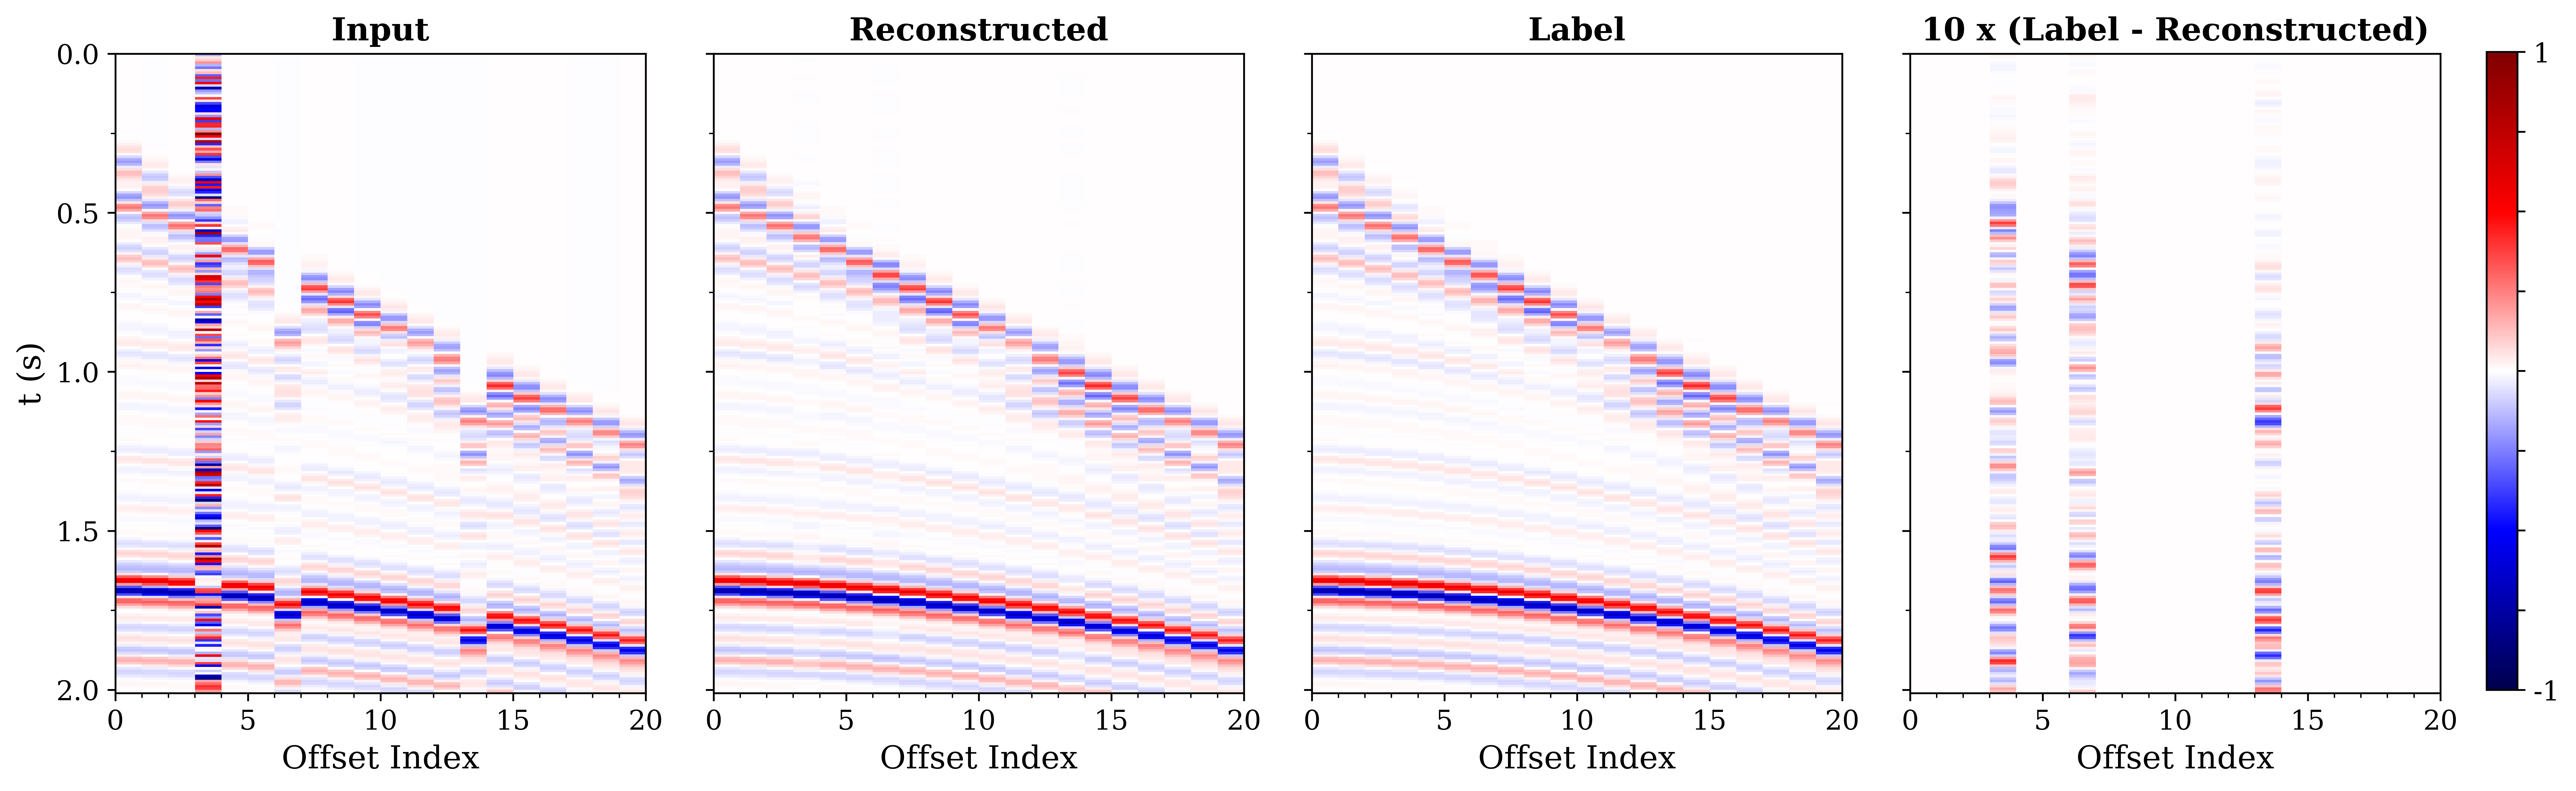

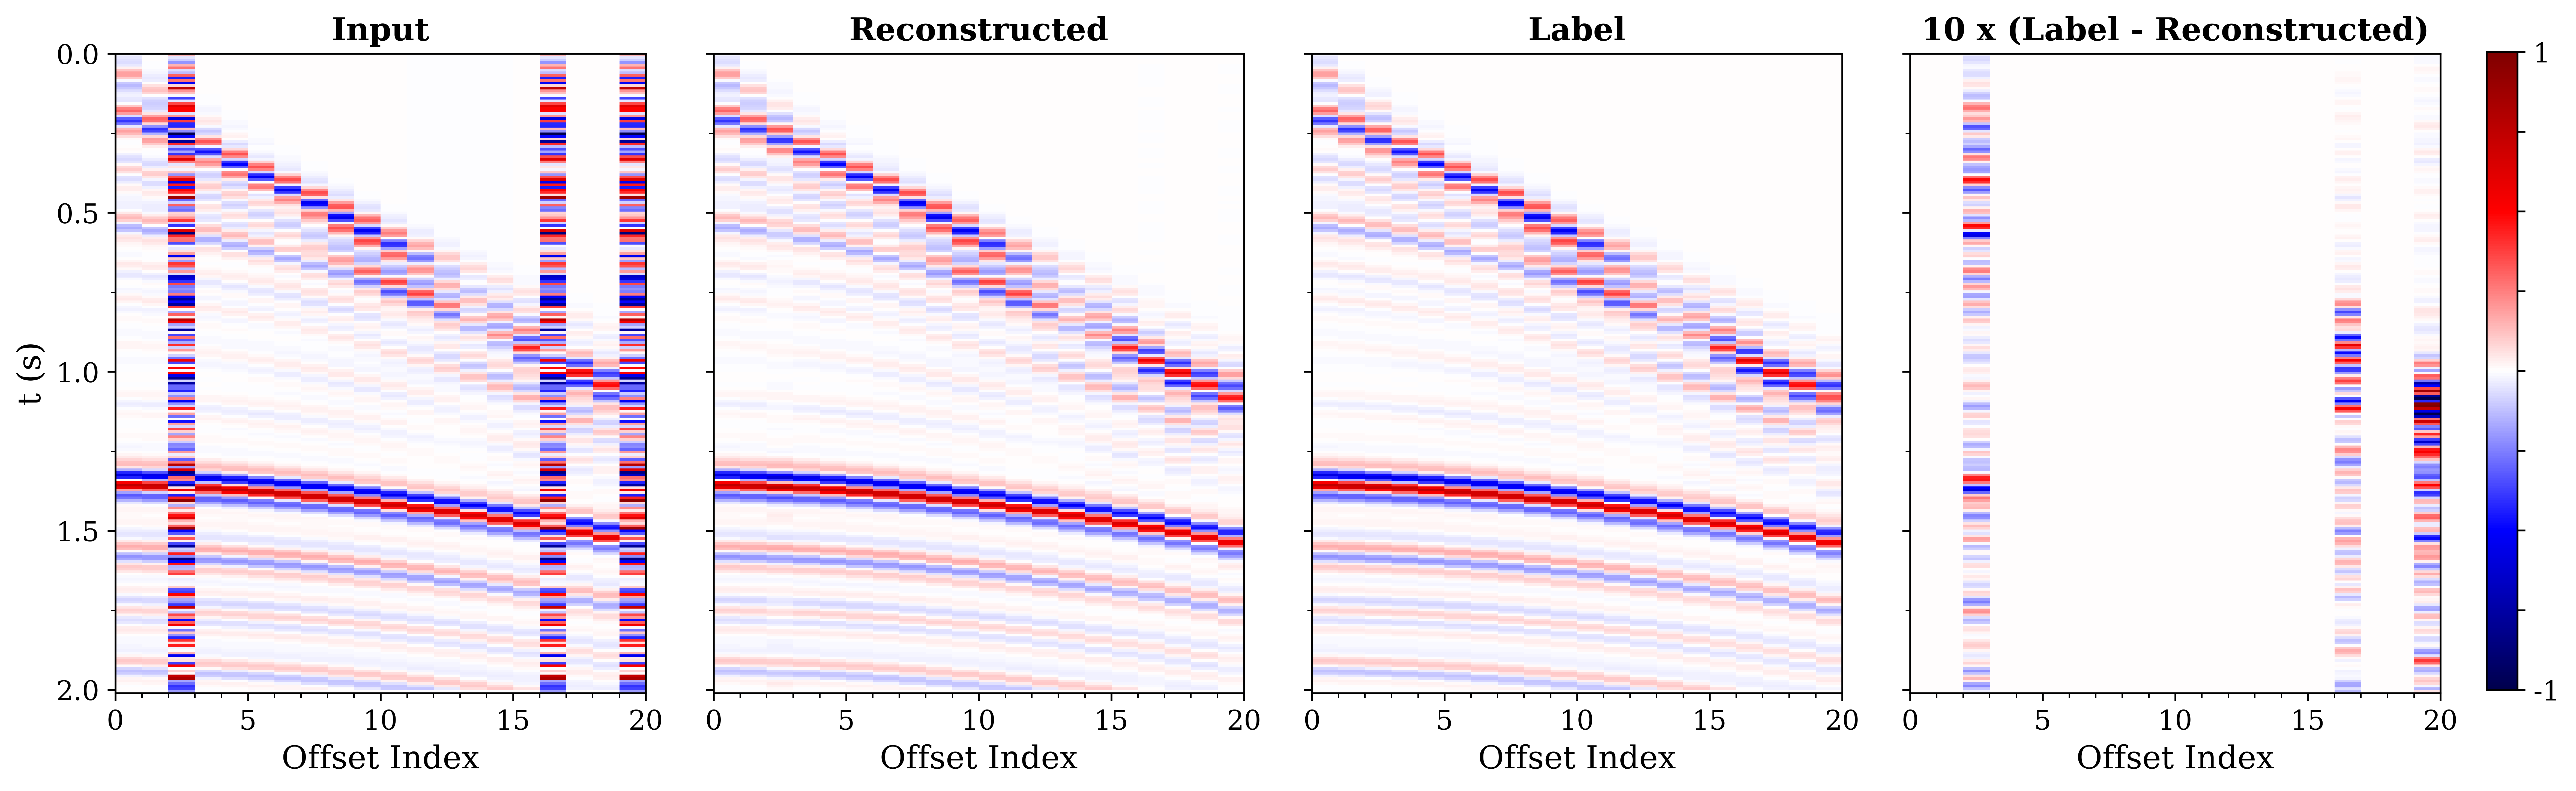

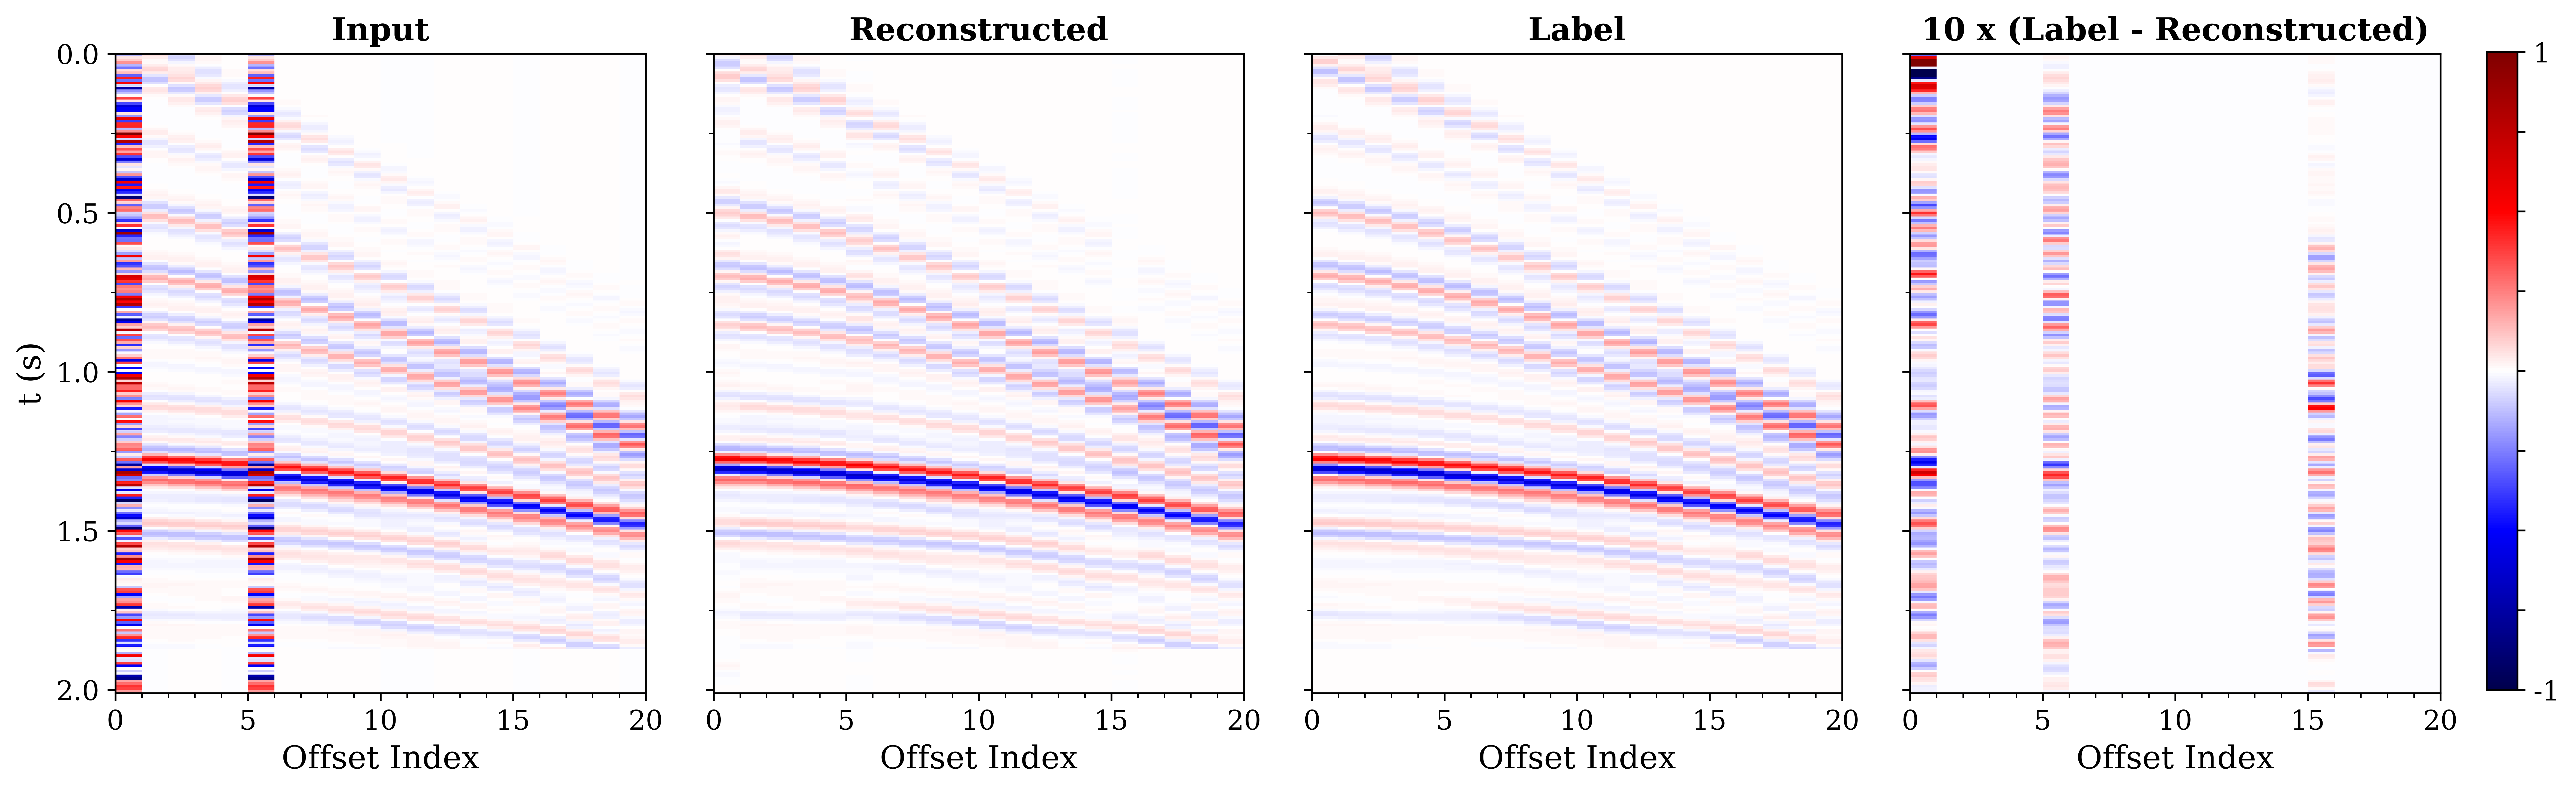

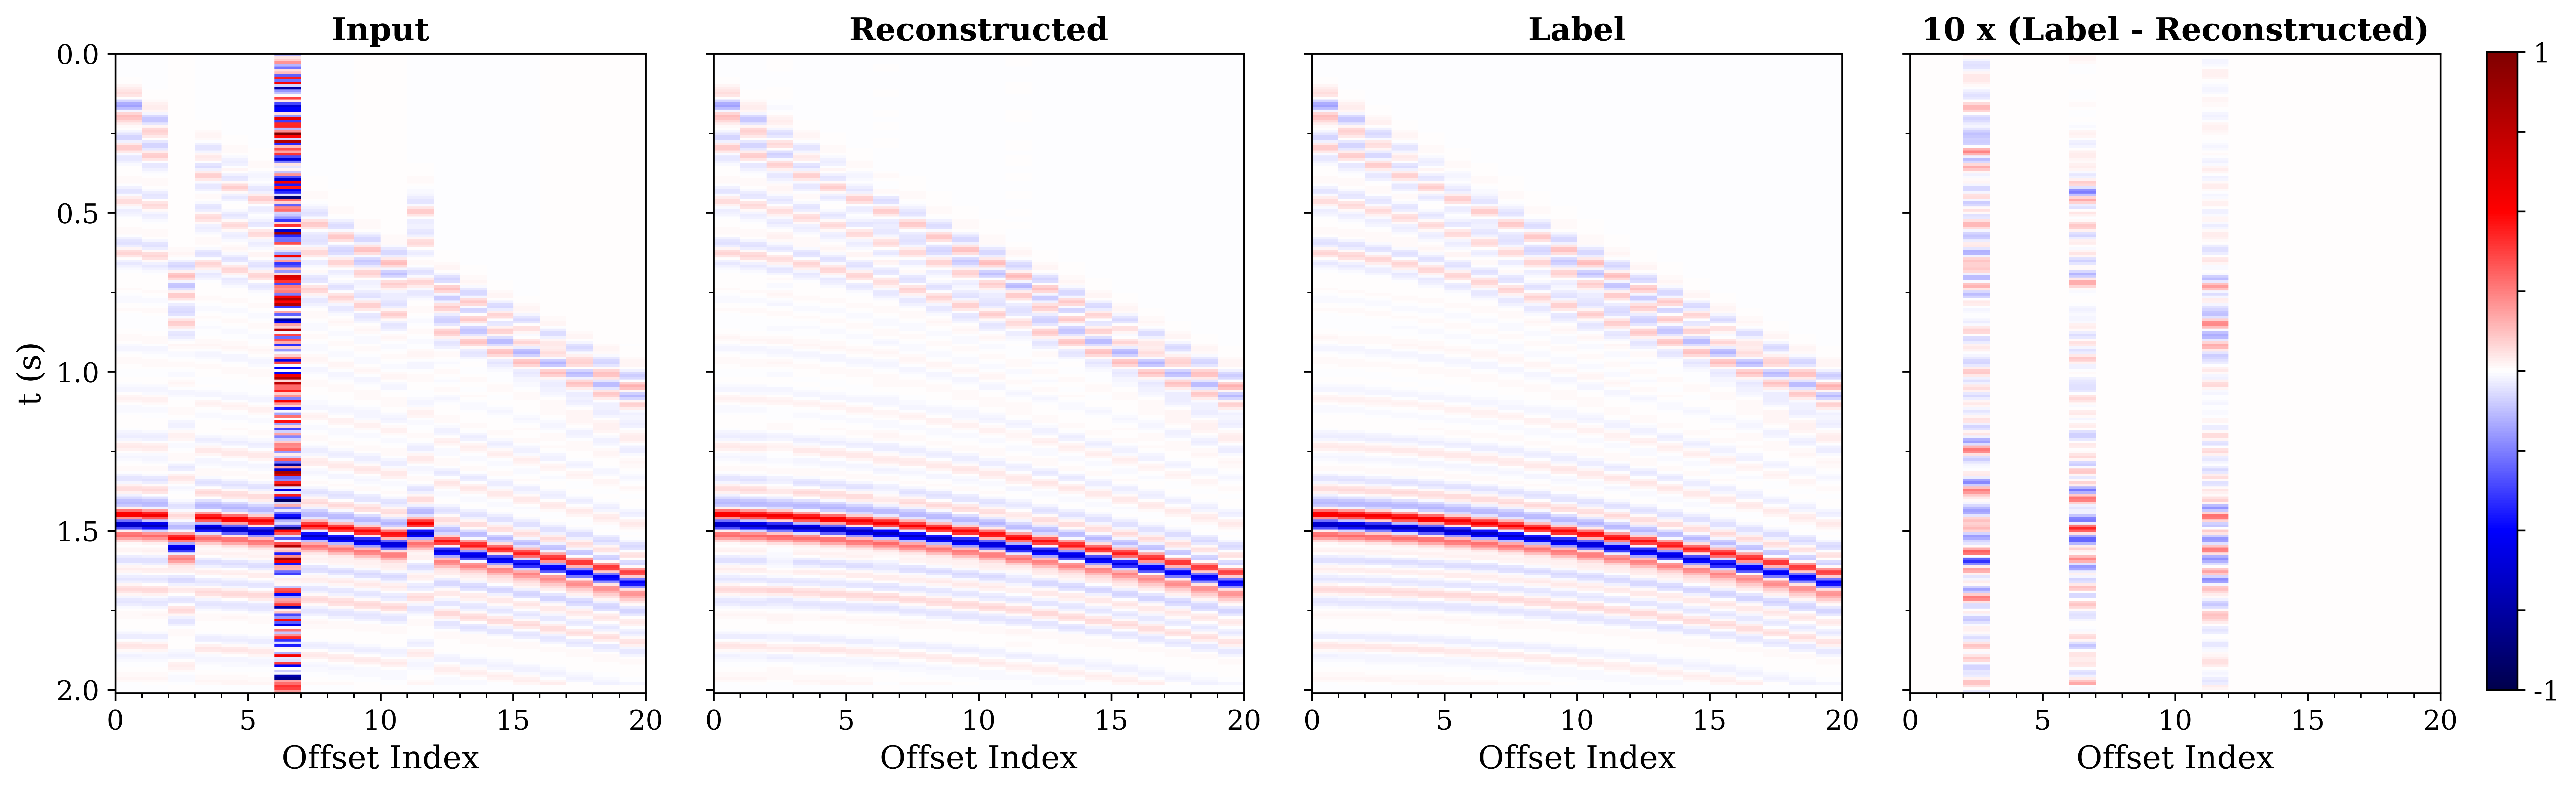

In [21]:
model.eval()

idx = torch.randint(len(test_data), (4,))
print(idx)

inputs_embeds = test_data.encodings['inputs_embeds'][idx]
labels = test_data.encodings['labels'][idx]
mask_label = test_data.encodings['mask_label'][idx]
with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device).float())

for X, y, z, mask in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels.cpu(), mask_label.cpu()):
    f, ax = plt.subplots(1, 4, figsize=(15, 7.5), sharey=True, sharex=False)
    f.tight_layout()
    ax[0].imshow(X.detach().swapaxes(0, 1) - X.mean(dim=1), aspect=12, vmin=-1, vmax=1, cmap='seismic', 
                extent=[0, 20, 271*8/1000, 0])
    ax[0].set_title("Input", fontsize=14)
    ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0].set_xlabel("Offset Index")
    ax[0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[0].set_ylabel("t (s)")
    output = torch.where(mask == 0, X.float(), y)
    ax[1].imshow(output.detach().swapaxes(0, 1) - output.mean(), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                extent=[0, 20, 271*8/1000, 0])
    ax[1].set_title("Reconstructed", fontsize=14)
    ax[1].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[1].set_xlabel("Offset Index")
    ax[2].imshow(z.detach().swapaxes(0, 1) - z.mean(), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                extent=[0, 20, 271*8/1000, 0])
    ax[2].set_title("Label", fontsize=14)
    ax[2].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[2].set_xlabel("Offset Index")
    diff = 10 * (z - output)
    im4 = ax[3].imshow(diff.detach().swapaxes(0, 1), aspect=12, vmin=-1, vmax=1, cmap='seismic',
                      extent=[0, 20, 271*8/1000, 0])
    ax[3].set_title("10 x (Label - Reconstructed)", fontsize=14)
    ax[3].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[3].set_xlabel("Offset Index")
    plt.ylim(2.01, 0)
        
    cbar_ax = f.add_axes([1, 0.255, 0.0125, 0.52])
    cbar = f.colorbar(im4, cax=cbar_ax)
    cbar.set_ticks(np.arange(-1, 1.25, .25))
    cbar.set_ticklabels([-1, "", "", "", "", "", "", "", 1])

## Finalize

In [24]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_valid_loss_arr = np.array(avg_valid_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_valid_loss_arr = np.array(avg_valid_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/pretrain
Saved successfully to ./results/pretrain


## References

Devlin, J., M.-W. Chang, K. Lee, and K. Toutanova, 2018, Bert: Pre-training of deep bidirectional transformers for language understanding: arXiv preprint arXiv:1810.04805.

Harsuko, R., and T. Alkhalifah, 2022, Storseismic: An approach to pre-train a neural network to store seismic data features: 83rd EAGE Annual Conference & Exhibition, European Association of Geoscientists & Engineers, 1–5.

Xiong, R., Yang, Y., He, D., Zheng, K., Zheng, S., Xing, C., Zhang, H., Lan, Y., Wang, L. and Liu, T., 2020, November. On layer normalization in the transformer architecture. In International Conference on Machine Learning (pp. 10524-10533). PMLR.